## 프로젝트: 더 멋진 번역기 만들기

In [1]:
import tensorflow as tf
import numpy
import matplotlib

print(tf.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.6.0
1.21.4
3.4.3


### 데이터 다운로드 (클라우드 유저용)

### 데이터 정제 및 토큰화

In [2]:
#병렬데이터 중복 제거
def duplication_remover(enc_corpus, dec_corpus ):
    cleaned_corpus = set(zip(enc_corpus, dec_corpus))
    see = list(cleaned_corpus)
    see[:5]
    return list(cleaned_corpus)

In [3]:
#data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = "./data/korean-english-park.train.ko"
eng_path = "./data/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # [[YOUR CODE]]
    enc_corpus = kor
    dec_corpus = eng
    cleaned_corpus = duplication_remover(enc_corpus, dec_corpus )

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [4]:
cleaned_corpus[10]

('이밖에 가솔린(휘발유)의 재고는 190만 배럴로 당초 전문가들이 예상한 것보다 130만 배럴 더 올랐다.',
 'And supplies of gasoline rose by 1.9 million barrels, more than the 1.3 million-barrel increase analysts had expected.')

> * 모든 입력을 소문자로 변환합니다.   -> ok
> * 알파벳, 문장부호, 한글만 남기고 모두 제거합니다. ->ok
> * 문장부호 양옆에 공백을 추가합니다.  -> ok
> * 문장 앞뒤의 불필요한 공백을 제거합니다.->ok

In [5]:
#For korean

import re

def preprocess_sentence_kor(sentence): 
    sentence = sentence.strip()

    # Add spaces around punctuation
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # Remove consecutive spaces
    sentence = re.sub(r'[" "]+', " ", sentence)

    # Remove all characters except Korean, spaces, and punctuation
    sentence = re.sub(r"[^가-힣0-9a-zA-Z?.!,]+", " ", sentence)

    
    # Remove leading/trailing spaces
    sentence = sentence.strip()

    #if s_token:
    #    sentence = '<start> ' + sentence

    #if e_token:
    #    sentence += ' <end>'

    return sentence

In [6]:
#For English

def preprocess_sentence_en(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    # Replace to lower characters
    sentence = sentence.lower()
    
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

### Sentencepiece를 활용하여 학습한 tokenizer를 생성

In [7]:

import sentencepiece as spm

def sentencepiece_learning(corpus, vocab_size, lang, pad_id, bos_id, eos_id, unk_id):

    temp_file = './data/korean-english-park.train.ko.temp'
    #temp_file = os.getenv('HOME')+'/aiffel/workspace/goingdeeper/sp_tokenizer/data/korean_spm_bpe_10k.vocab'


    with open(temp_file, 'w') as f:
        for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
            f.write(str(row) + '\n')


    spm.SentencePieceTrainer.train(
        input=temp_file,
        model_prefix=f"{lang}",
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id
    )
    
    #return korean_spm

In [8]:
def read_sp_vocab(lang):
    
    with open('./'+ lang +'.vocab', 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})
        
    return word_index, index_word
    

In [9]:
def sp_tokenize(tokenizer, corpus):

    tensor = []

    for sen in corpus:
        tokensIDs = tokenizer.EncodeAsIds(sen)
        tensor.append(tokenizer.EncodeAsIds(sen))

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tokenizer


In [10]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, vocab_size, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    # [[YOUR CODE]]
    # voca, model 생성
    sentencepiece_learning(corpus, vocab_size, lang, pad_id, bos_id, eos_id, unk_id)
    
    # korean_spm.voca 읽어오기 
    word_index, index_word = read_sp_vocab(lang)
    
    #Sentence Piece instance 만들고 korean_spm.model load하기
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f"{lang}.model")
    
    tokenizer = sp_tokenize(tokenizer, corpus)
    
    return tokenizer

### 전처리 함수, Tokenize 실행

In [11]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for k, e in cleaned_corpus:
    #k, e = pair.split("\t")
    kor_corpus.append(preprocess_sentence_kor(k))
    eng_corpus.append(preprocess_sentence_en(e, s_token=True, e_token=True))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whi

True

In [12]:
len(ko_tokenizer), len(en_tokenizer)

(20000, 20000)

### 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별

In [13]:
from tqdm.notebook import tqdm

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# Keep only sentences with token length less than or equal to 50
for idx in tqdm(range(len(kor_corpus))):
    kor_tokenized = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    eng_tokenized = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    if len(kor_tokenized) <= 50 and len(eng_tokenized) <= 50:
        src_corpus.append(kor_tokenized)
        tgt_corpus.append(eng_tokenized)

# Pad the sequences to create training data
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')


  0%|          | 0/78968 [00:00<?, ?it/s]

### 모델 설계

A transformer is a type of neural network architecture introduced in the paper "Attention Is All You Need" by Vaswani et al. (2017). It is commonly used for natural language processing tasks such as machine translation, text generation, and text classification.

To implement a transformer, you will need several functions and classes to define the different components of the architecture. Here are some of the key components you will need:

1. **Multi-head attention**: This is a core component of the transformer architecture that allows the model to weigh the importance of different parts of the input sequence when making predictions. You will need to implement a function or class to compute the scaled dot-product attention and combine multiple attention heads.

2. **Feed-forward neural network**: The transformer architecture includes a feed-forward neural network in each layer, applied to each position separately and identically. You will need to implement a function or class to define this feed-forward neural network.

3. **Layer normalization**: The transformer architecture uses layer normalization to stabilize the training process. You will need to implement a function or class to perform layer normalization.

4. **Positional encoding**: The transformer architecture does not have any inherent notion of position, so it relies on positional encoding to incorporate information about the relative positions of the elements in the input sequence. You will need to implement a function or class to compute the positional encoding.

5. **Encoder and decoder**: The transformer architecture consists of an encoder and a decoder, each composed of multiple layers of multi-head attention and feed-forward neural networks. You will need to implement classes to define the encoder and decoder.

6. **Masking**: The transformer architecture uses masking to prevent the model from attending to certain positions in the input sequence. You will need to implement functions to generate the appropriate masks for the encoder and decoder.

Once you have implemented these components, you can combine them to create a complete transformer model. There are many resources available online that provide detailed explanations and examples of how to implement a transformer, so you may find it helpful to refer to these resources as well.

### 훈련하기

### Positional Encoding

In [14]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

### Multi-head attention 

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
      
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### Feed-forward neural network

In [16]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### Encoder 레이어 구현하기

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

### Decoder 레이어 구현하기

In [18]:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer 완성하기

In [21]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # Step 1: Embedding
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        # Step 2: Encoder
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        # Step 3: Decoder
        dec_out, dec_attns, dec_enc_attns = \
            self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        # Step 4: Out Linear
        logits = self.fc(dec_out)
        return logits, enc_attns, dec_attns, dec_enc_attns



### Learning Scheduler

In [22]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)


In [23]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### Loss Function

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### Attention 시각화 함수

In [25]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

### 번역 생성 함수

In [60]:
#그래프 한글표현 인스톨?

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


In [61]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence_kor(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, 
                                                                 combined_mask, dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

### 번역 생성 및 Attention 시각화 결합

In [62]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [63]:
#masking
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

### Train Step 함수 정의

In [86]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    # Compute the loss using tf.GradientTape
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # Compute the gradients and update the model weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns


In [87]:
len(enc_train), len(dec_train)

(58926, 58926)

In [88]:
#from tqdm import tqdm.tqdm_notebook #tqdm.notebook.tqdm
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt

def train_evaluate(epoch, enc_train, dec_train, optimizer, ko_tokenizer, en_tokenizer, src_vocab_size, tgt_vocab_size):
    
    print('epoch :', epoch)
    print('batch_size :', batch_size)
    print('vocab_size :', vocab_size )
    
    examples = [
                "오바마는 대통령이다.",
                "시민들은 도시 속에 산다.",
                "커피는 필요 없다.",
                "일곱 명의 사망자가 발생했다."
    ]

    transformer = Transformer(n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len, dropout)
    
    for epoch in range(epoch):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], batch_size))
        random.shuffle(idx_list)
        t = tqdm_notebook(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(enc_train[idx:idx+batch_size],
                        dec_train[idx:idx+batch_size],
                        transformer,
                        optimizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

        for example in examples:
            translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)
        
    plt.plot(total_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()    
    
    transformer.reset_variables()


In [89]:
# Set the hyperparameters
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
pos_len = 200
dropout = 0.1

vocab_sizes = [20000, 30000, 50000]
batch_sizes = [16,32,64]
epochs = [10,15]

epoch : 10
batch_size : 16
vocab_size : 20000


/tmp/ipykernel_1329/994578688.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/3683 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: <start> obama is . <end>
Encoder Layer 1


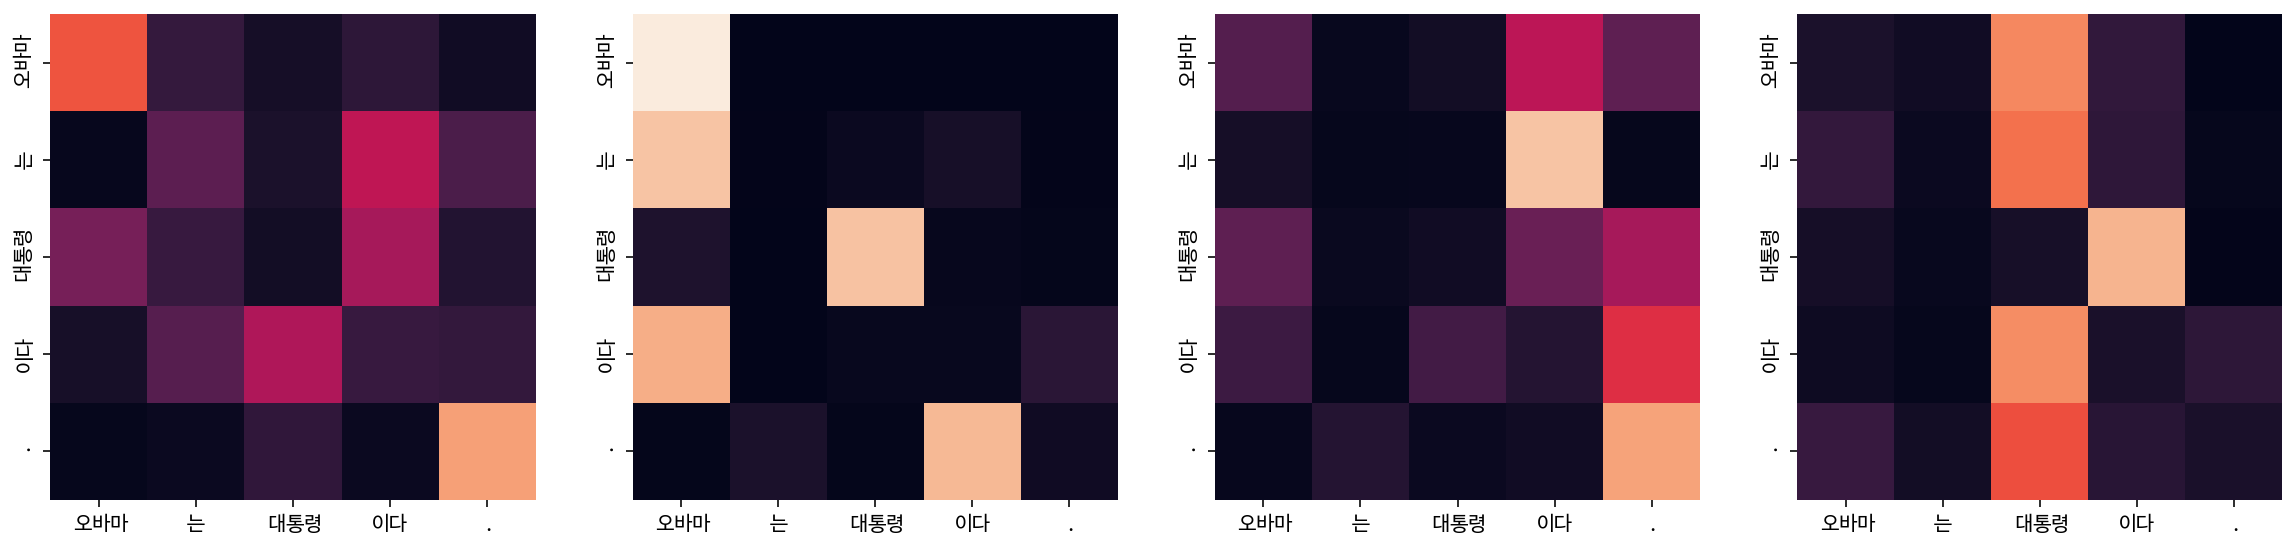

Encoder Layer 2


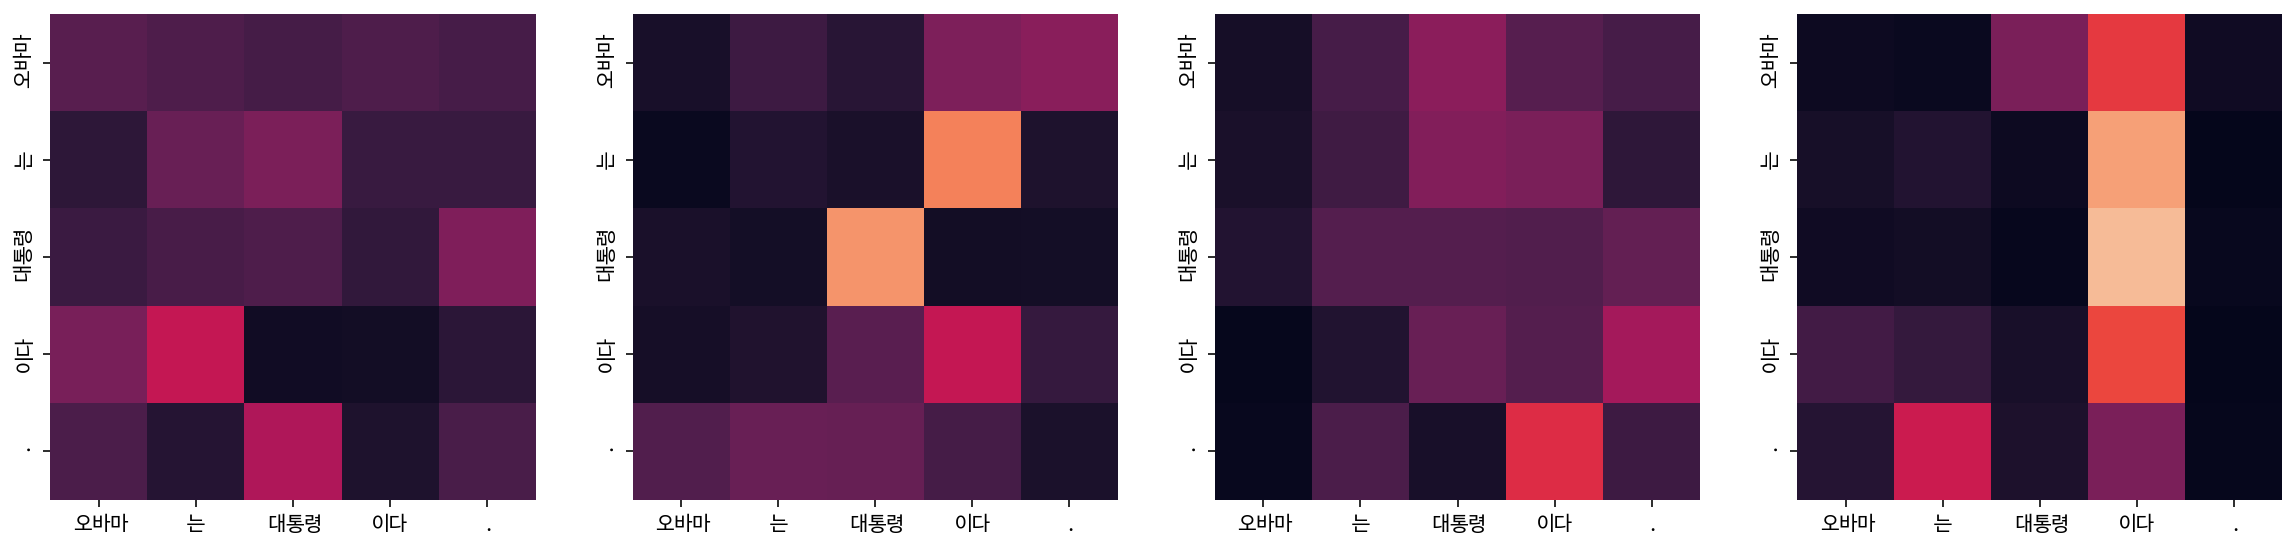

Decoder Self Layer 1


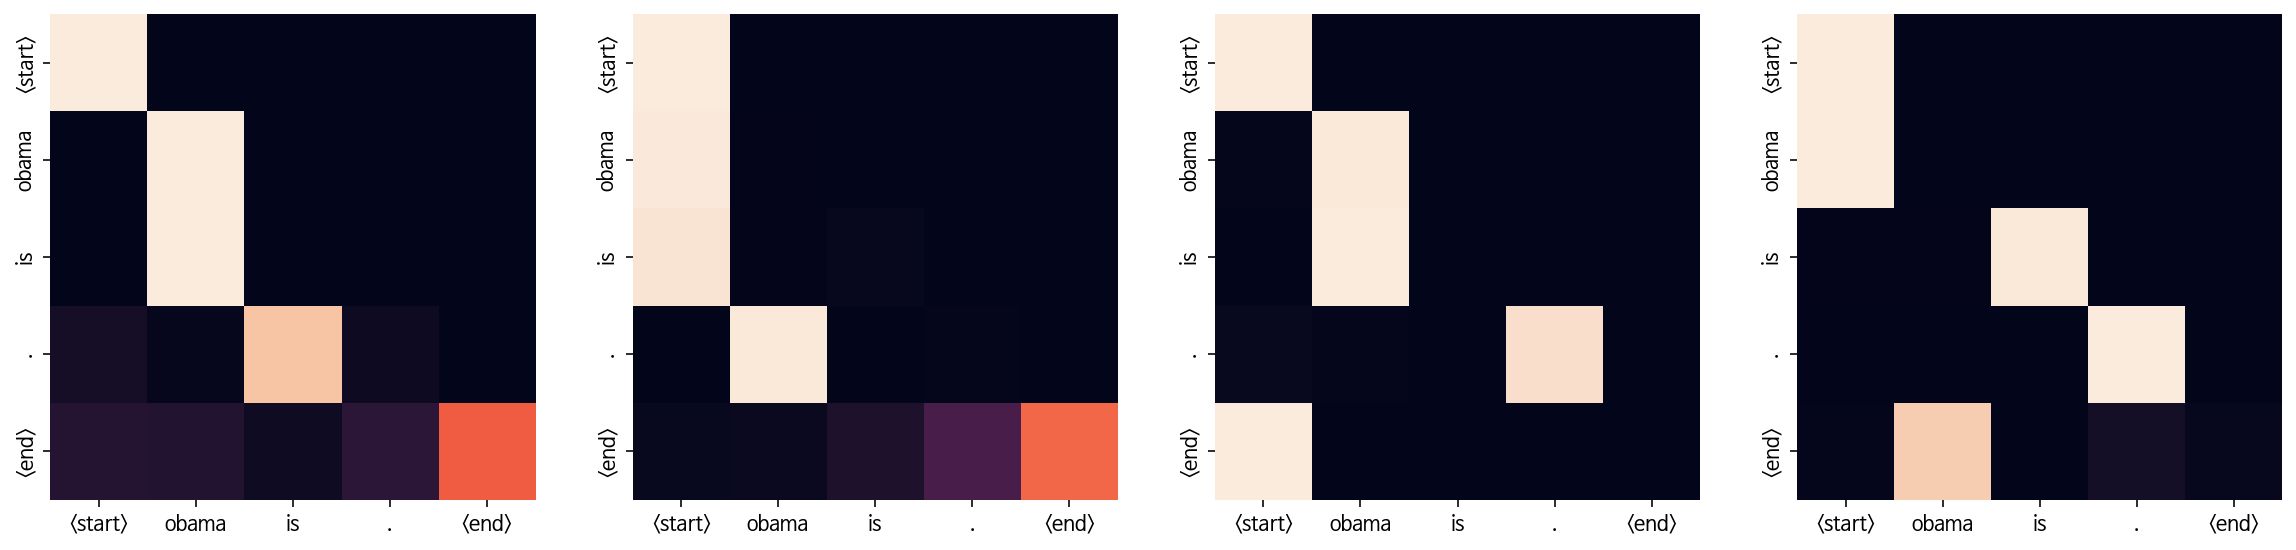

Decoder Src Layer 1


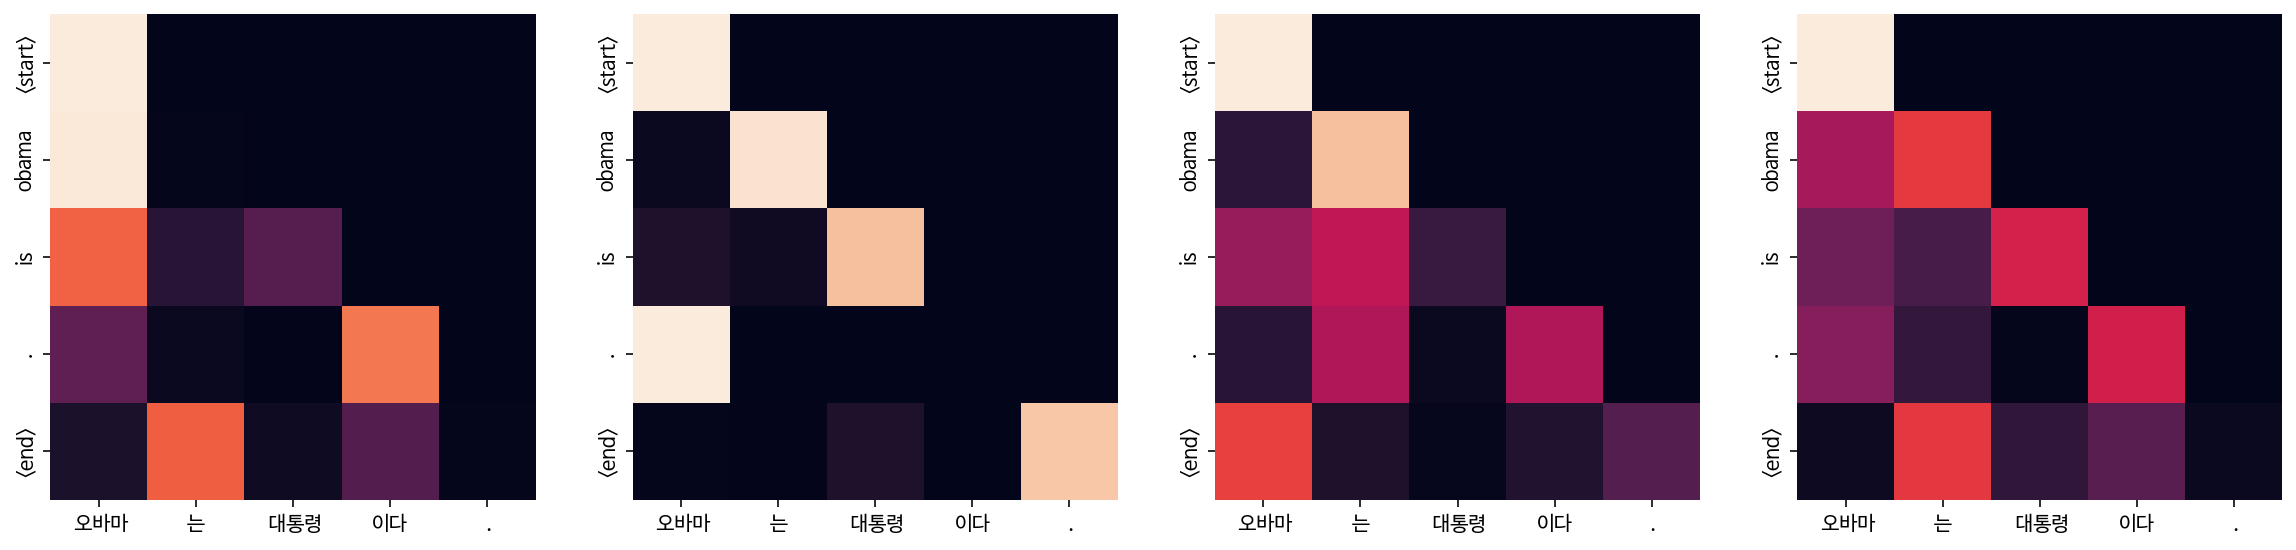

Decoder Self Layer 2


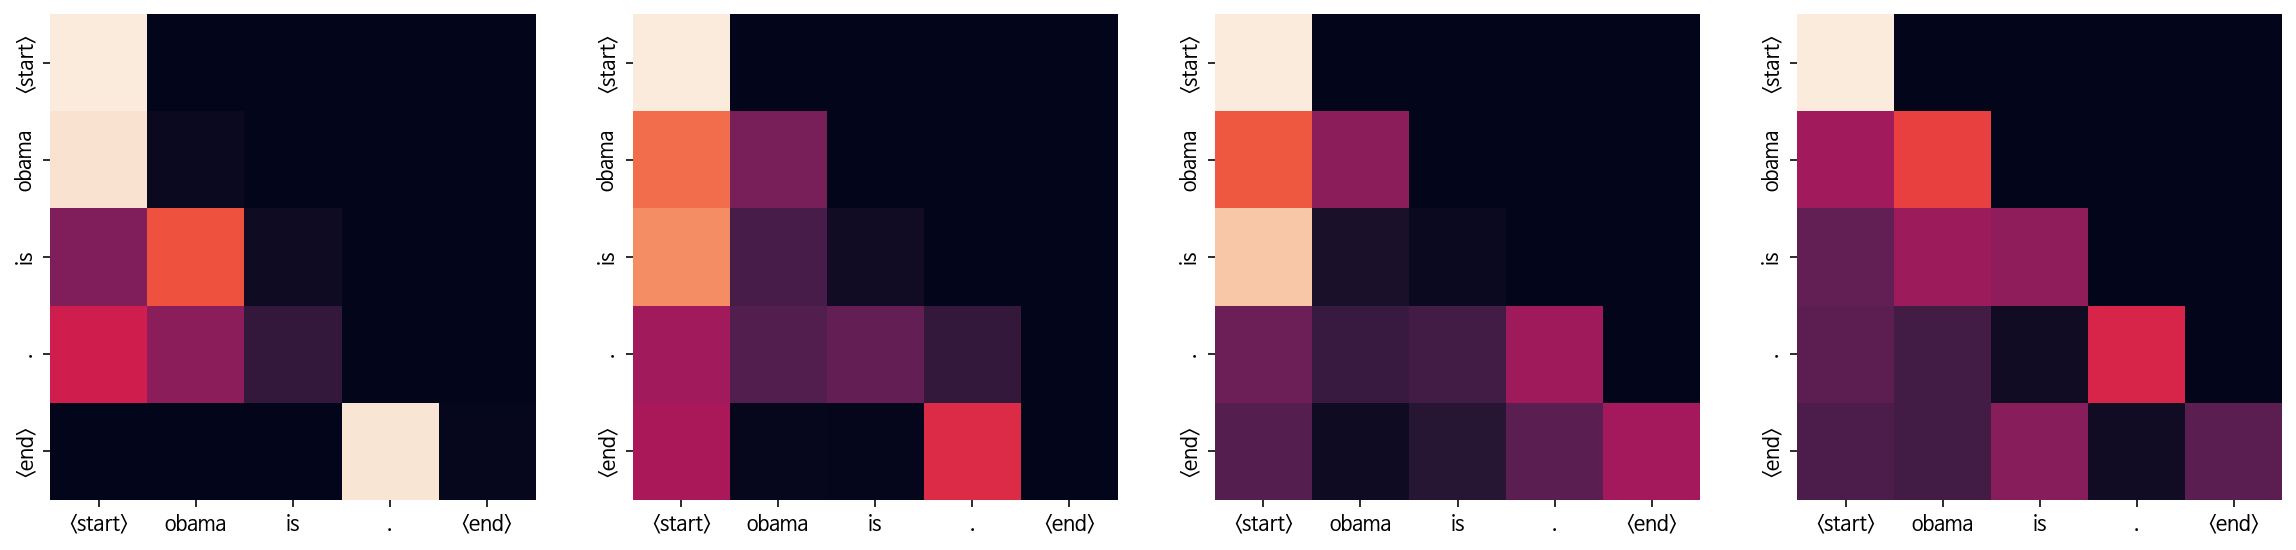

Decoder Src Layer 2


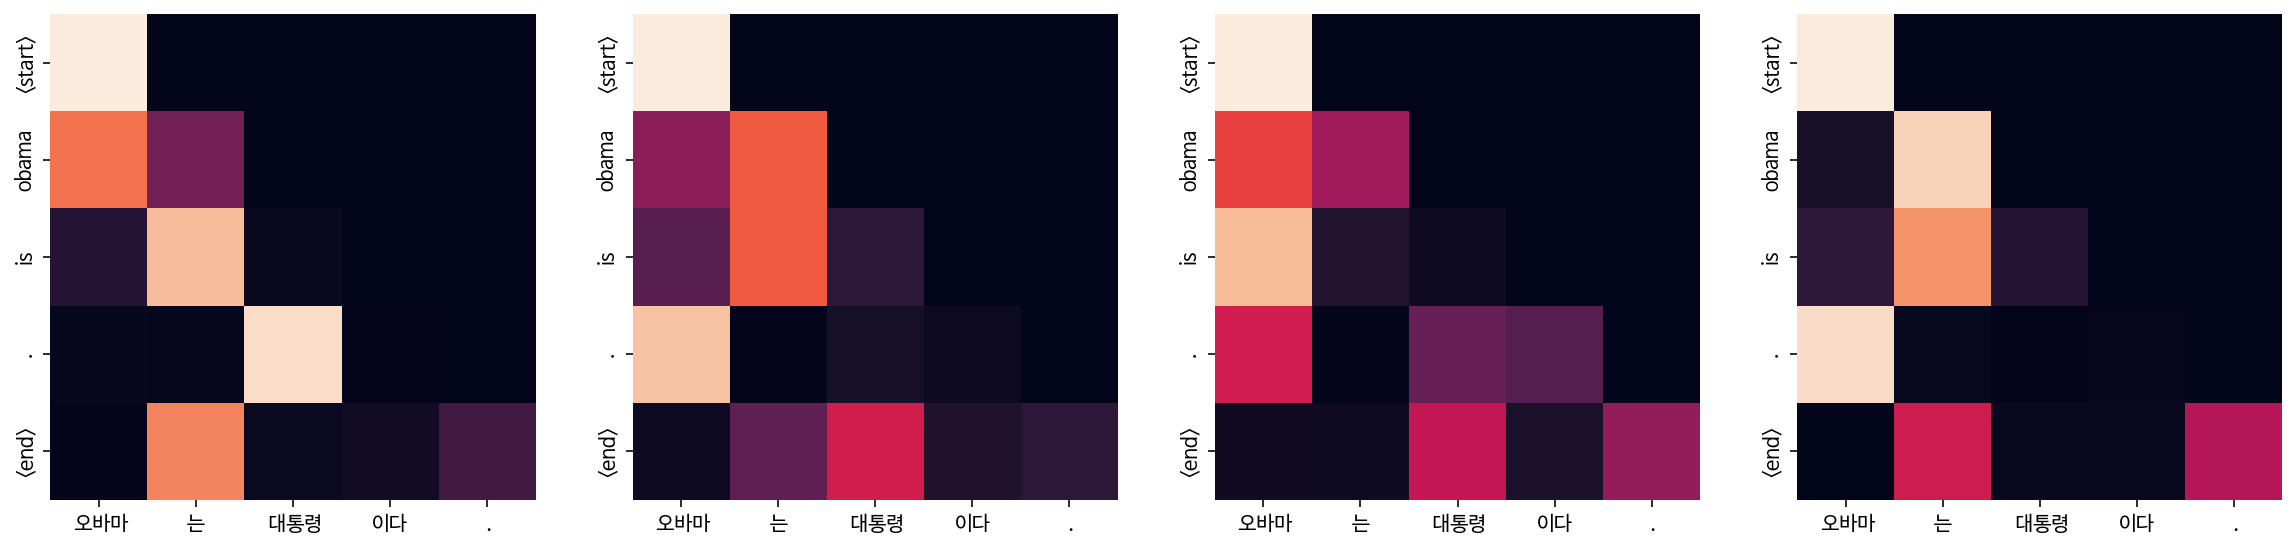

Input: 시민들은 도시 속에 산다.
Predicted translation: <start> the city city city city city city city city city city city city city . <end>
Encoder Layer 1


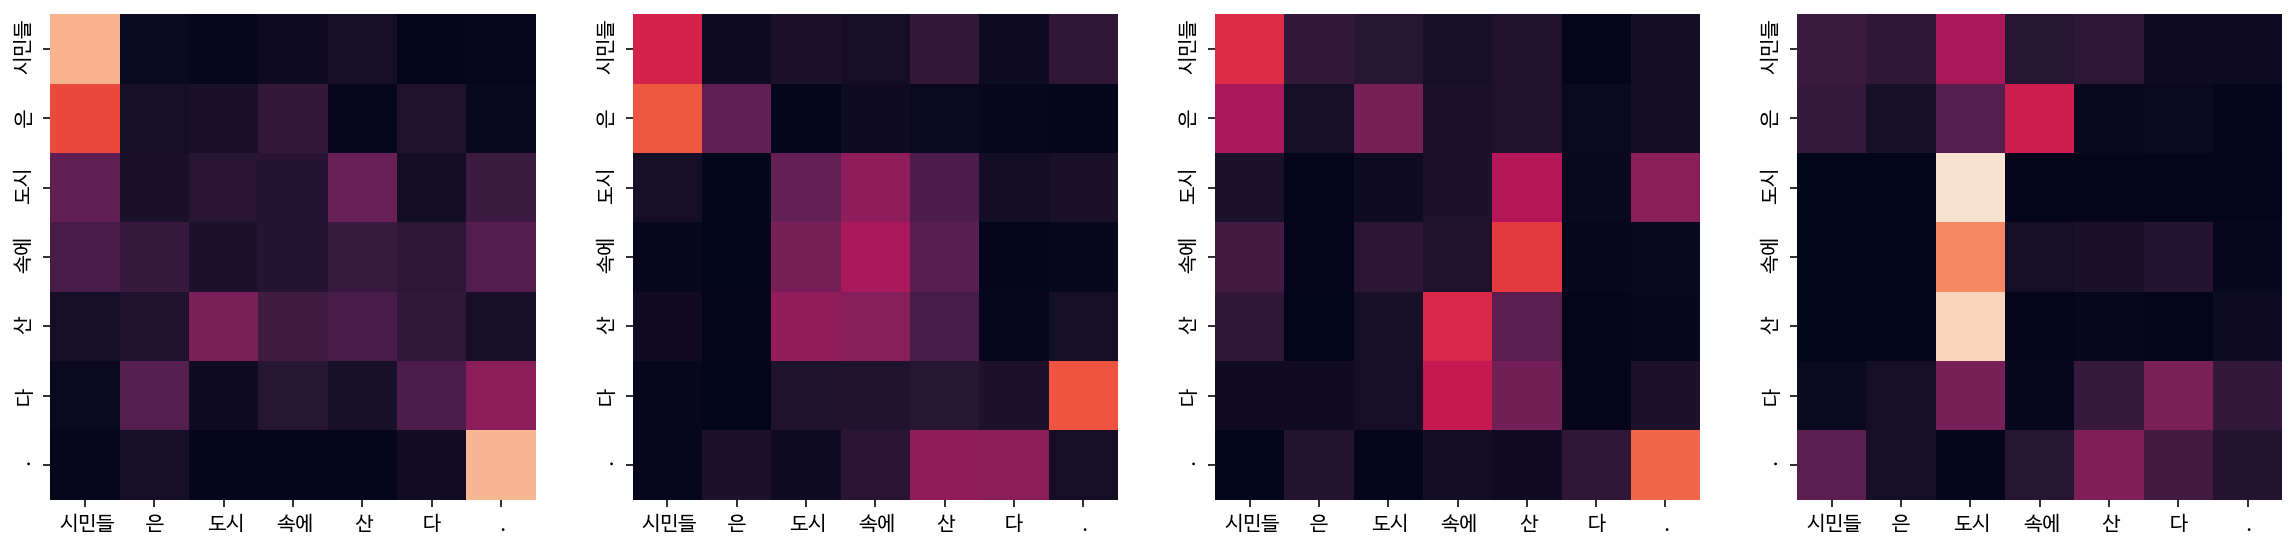

Encoder Layer 2


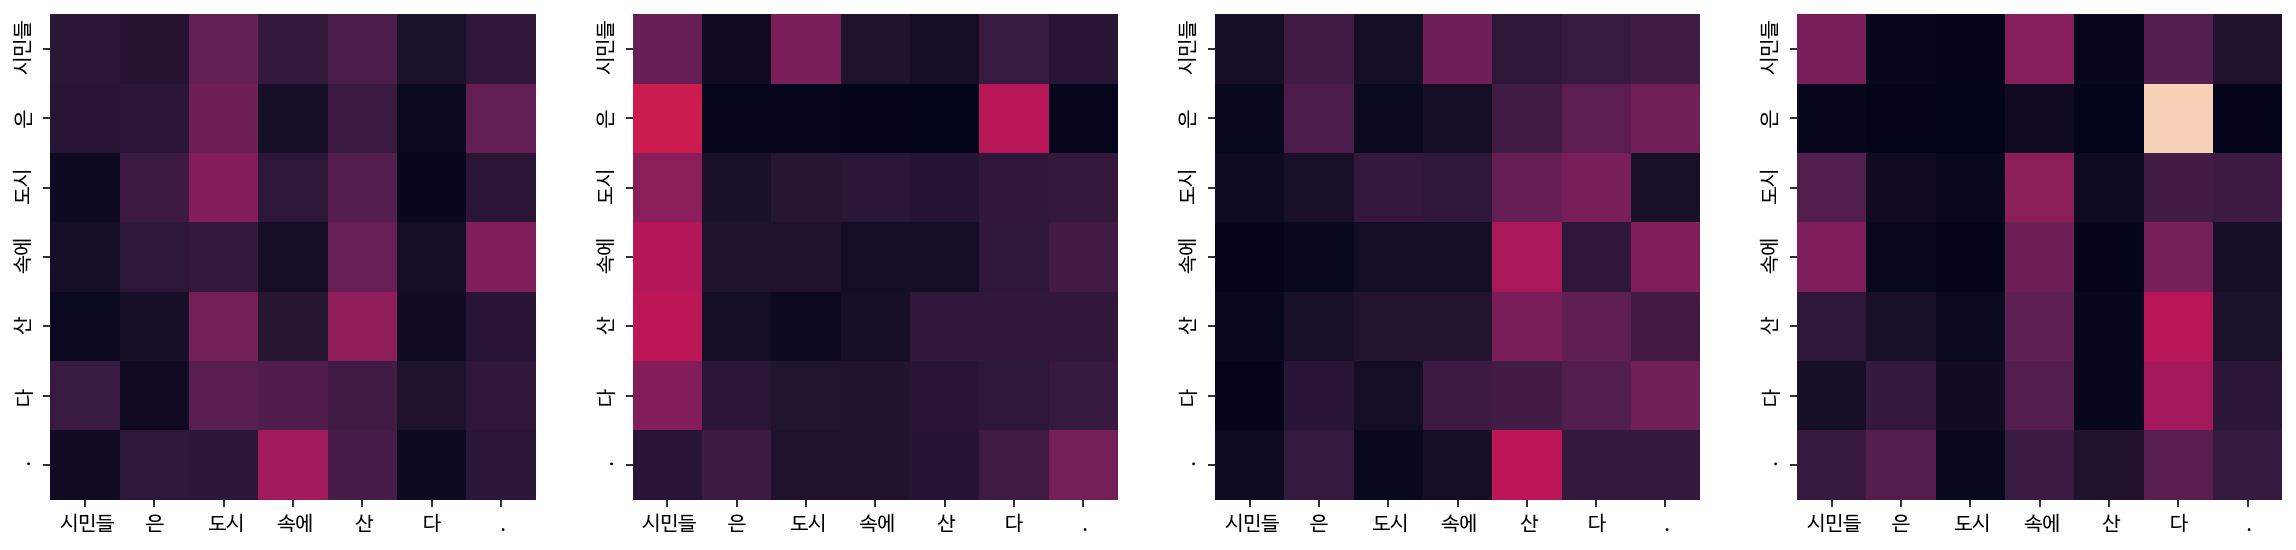

Decoder Self Layer 1


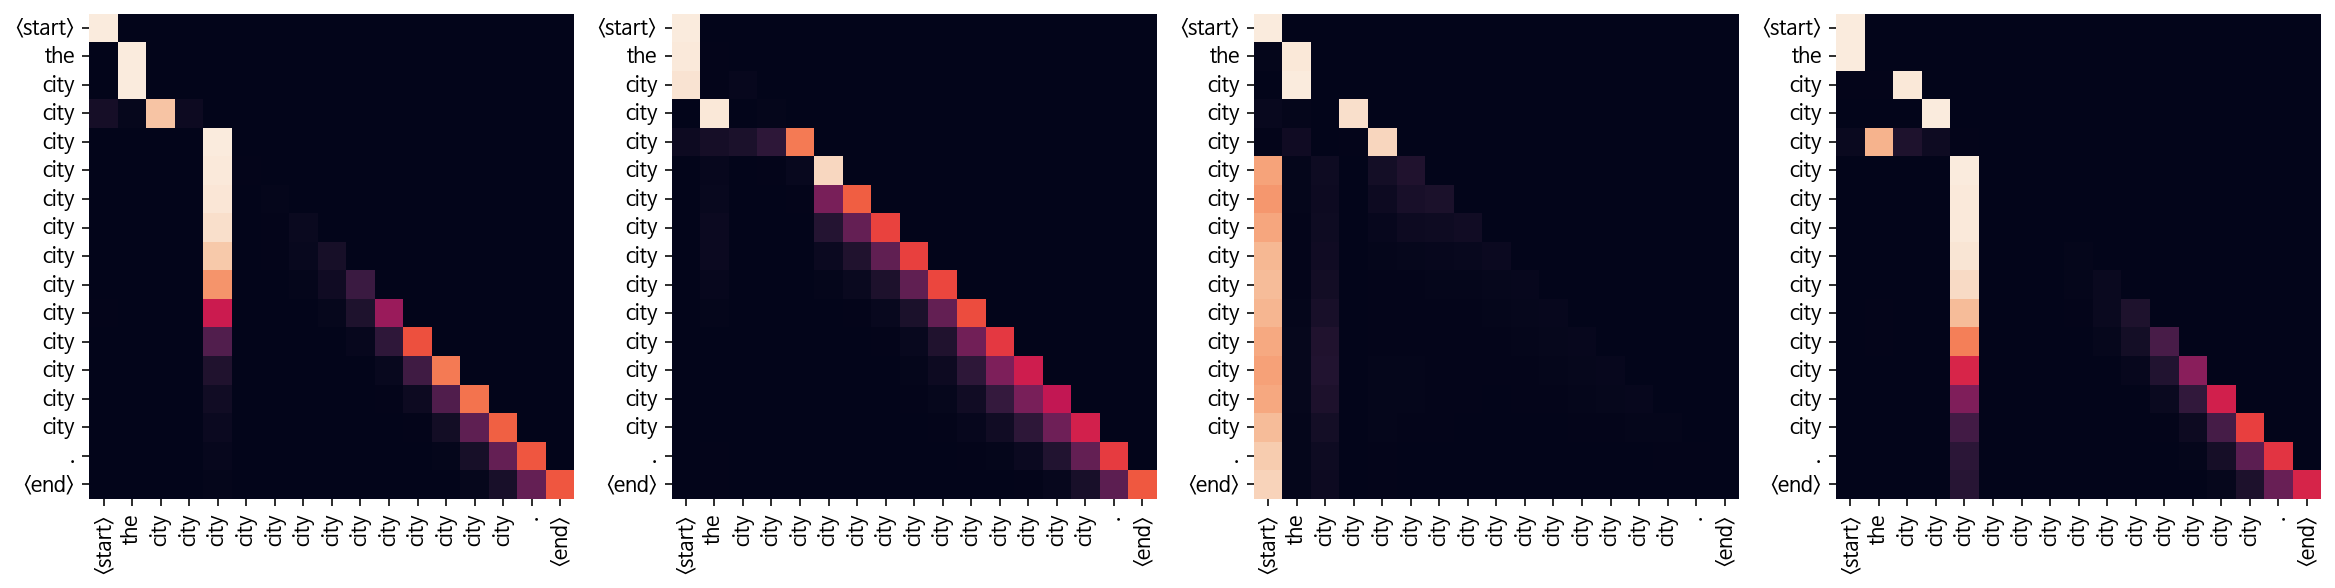

Decoder Src Layer 1


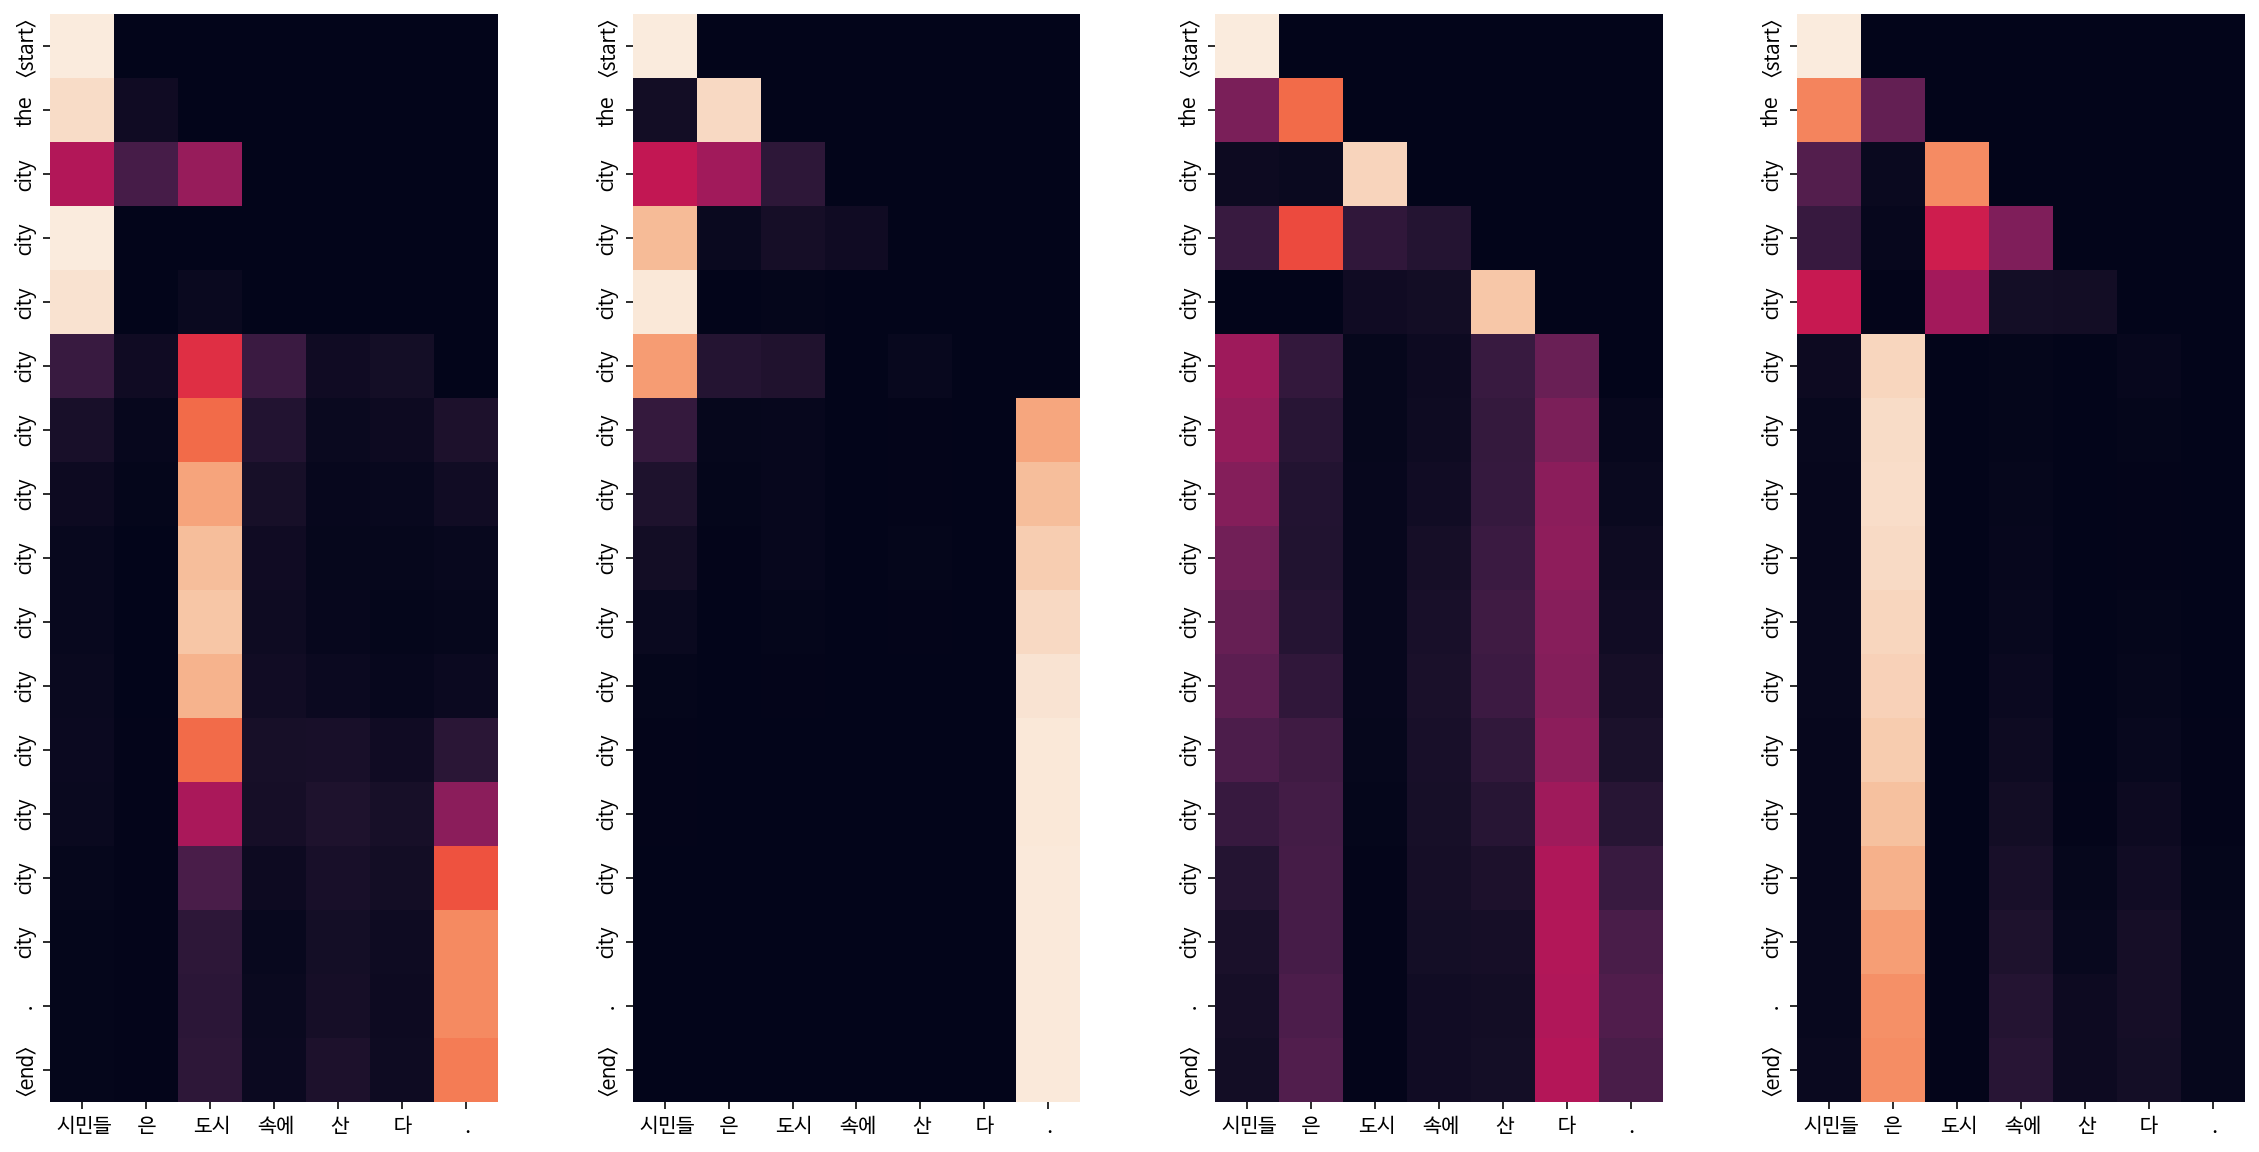

Decoder Self Layer 2


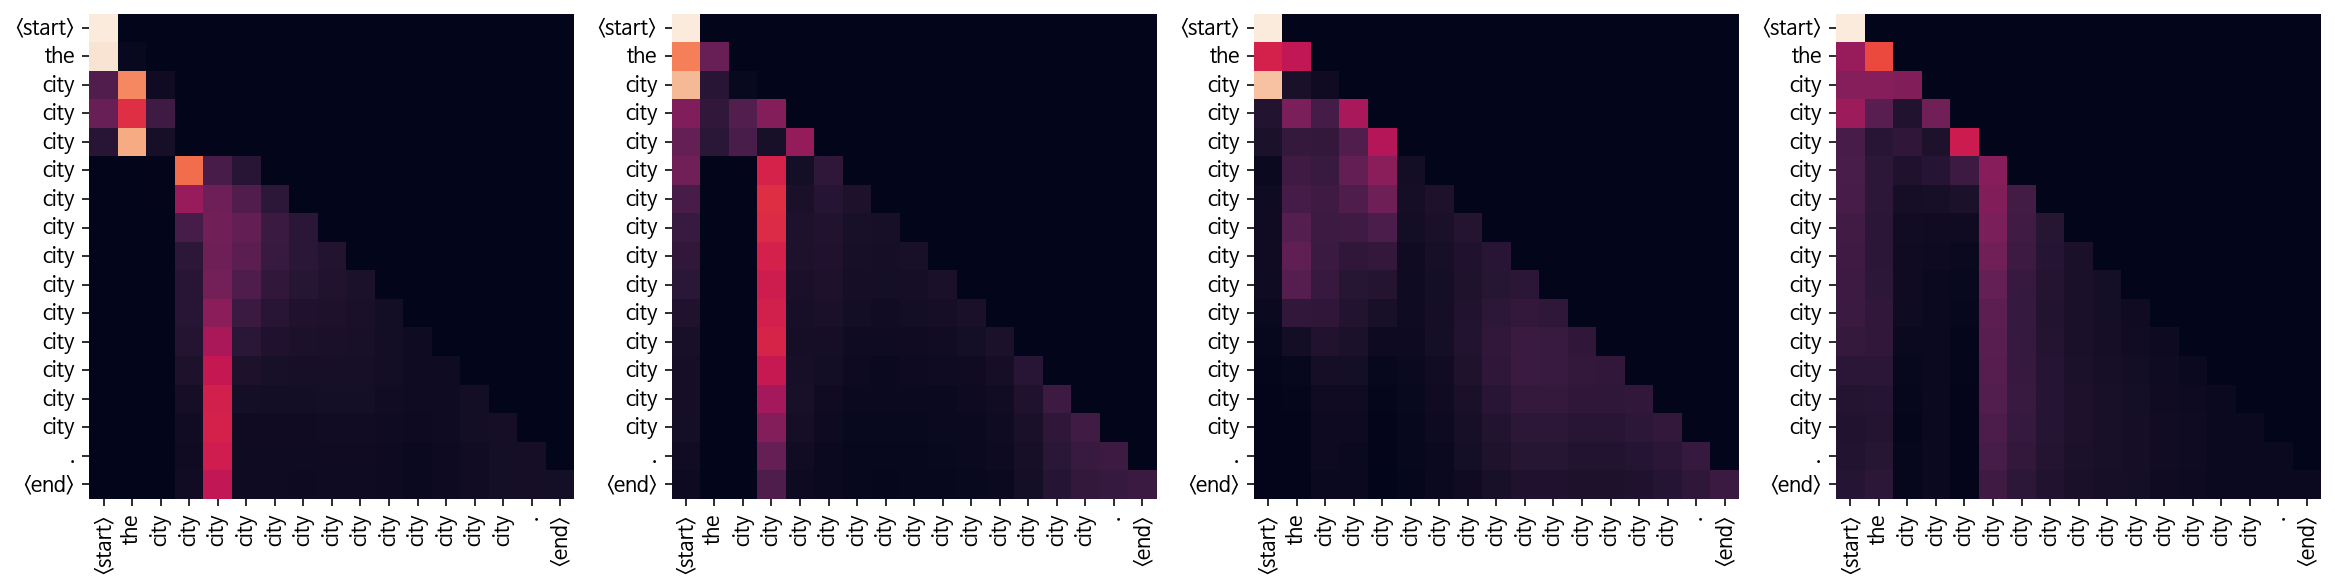

Decoder Src Layer 2


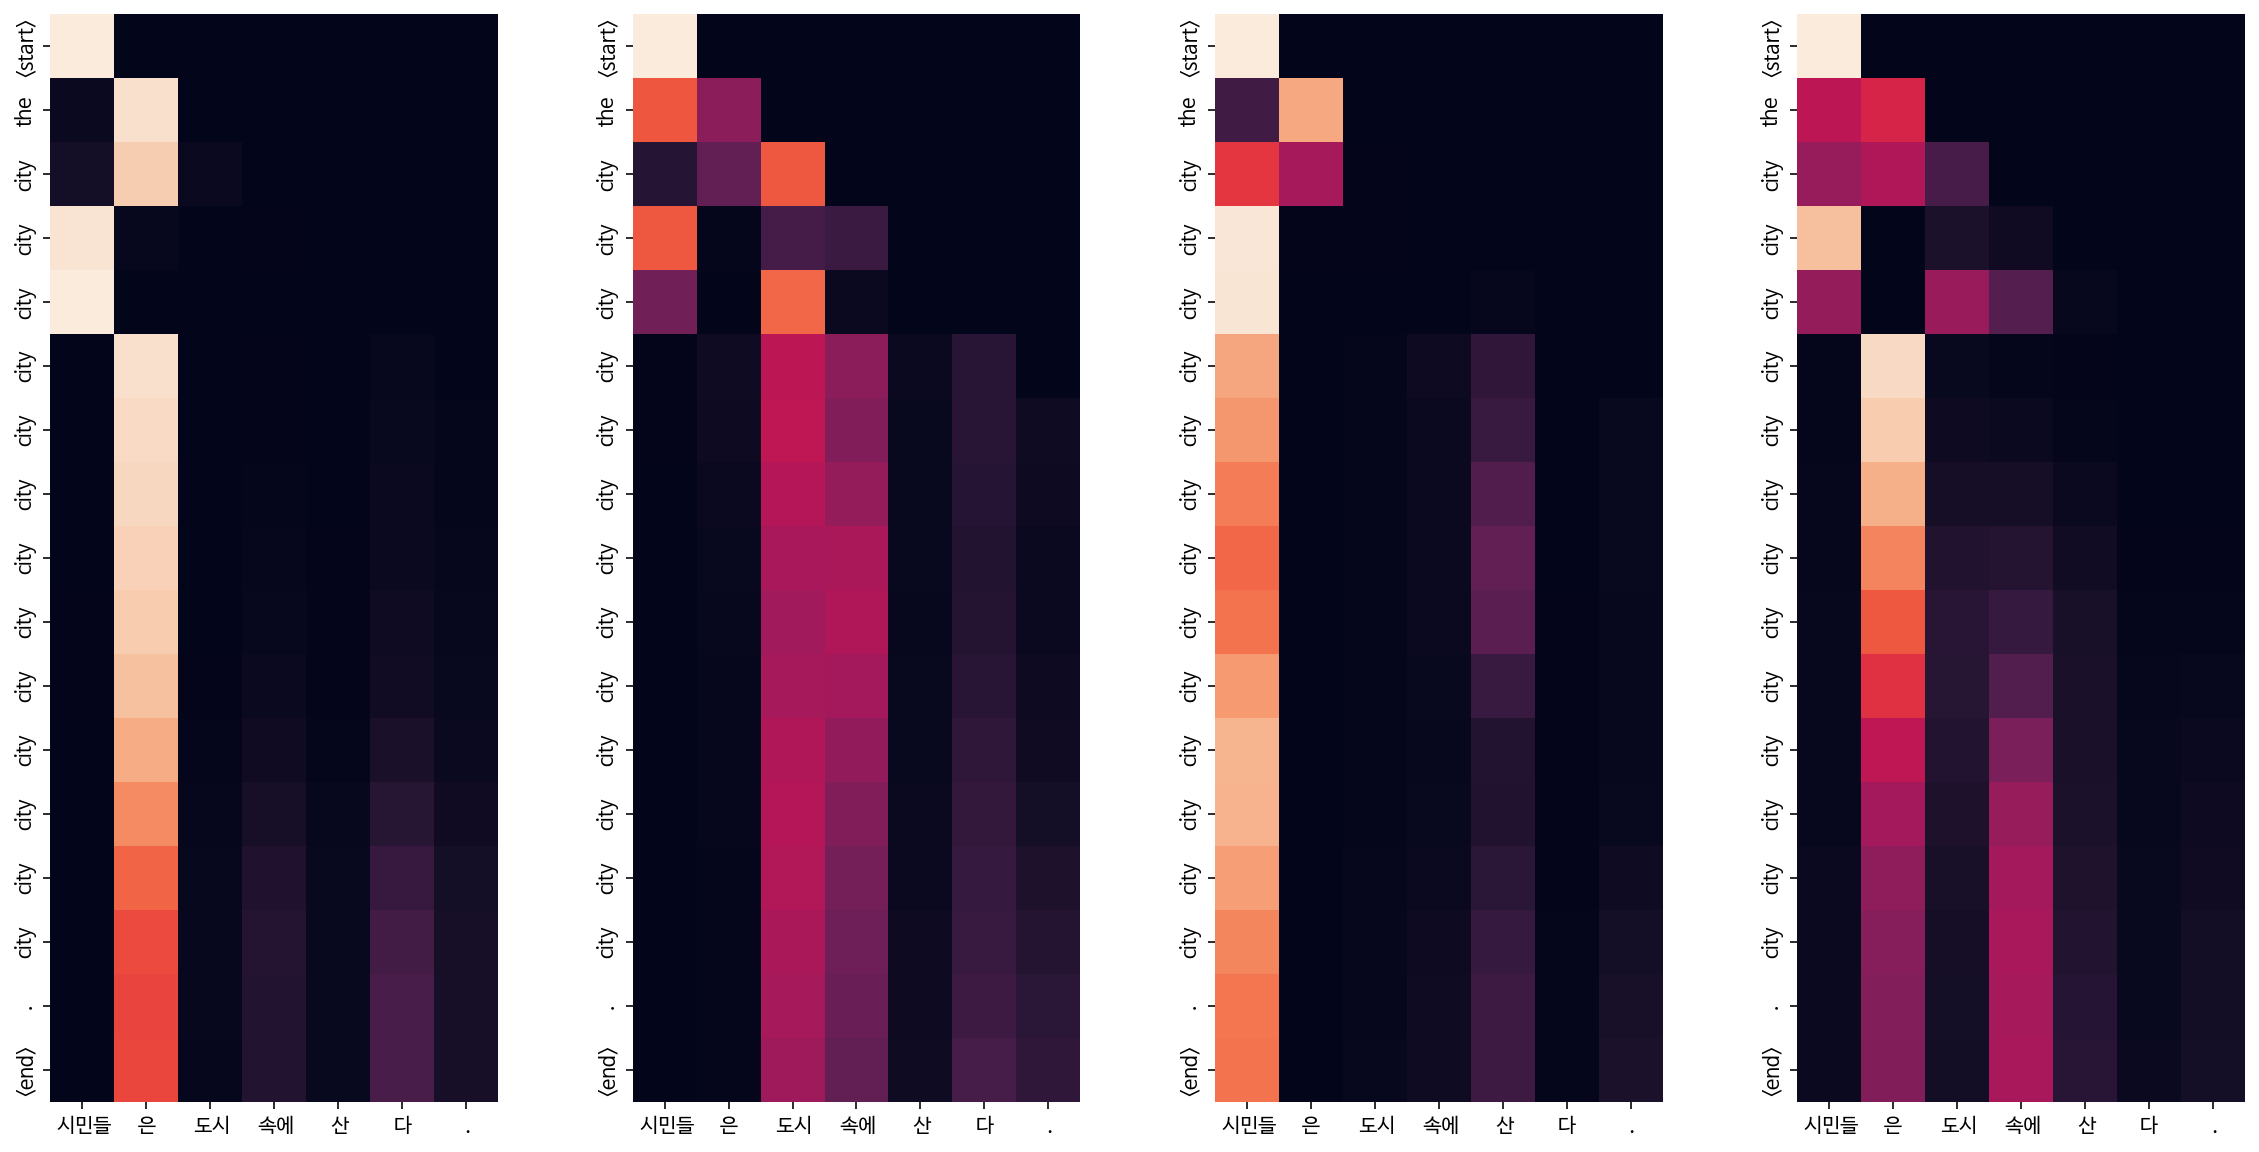

Input: 커피는 필요 없다.
Predicted translation: <start> it s not to do it s not . <end>
Encoder Layer 1


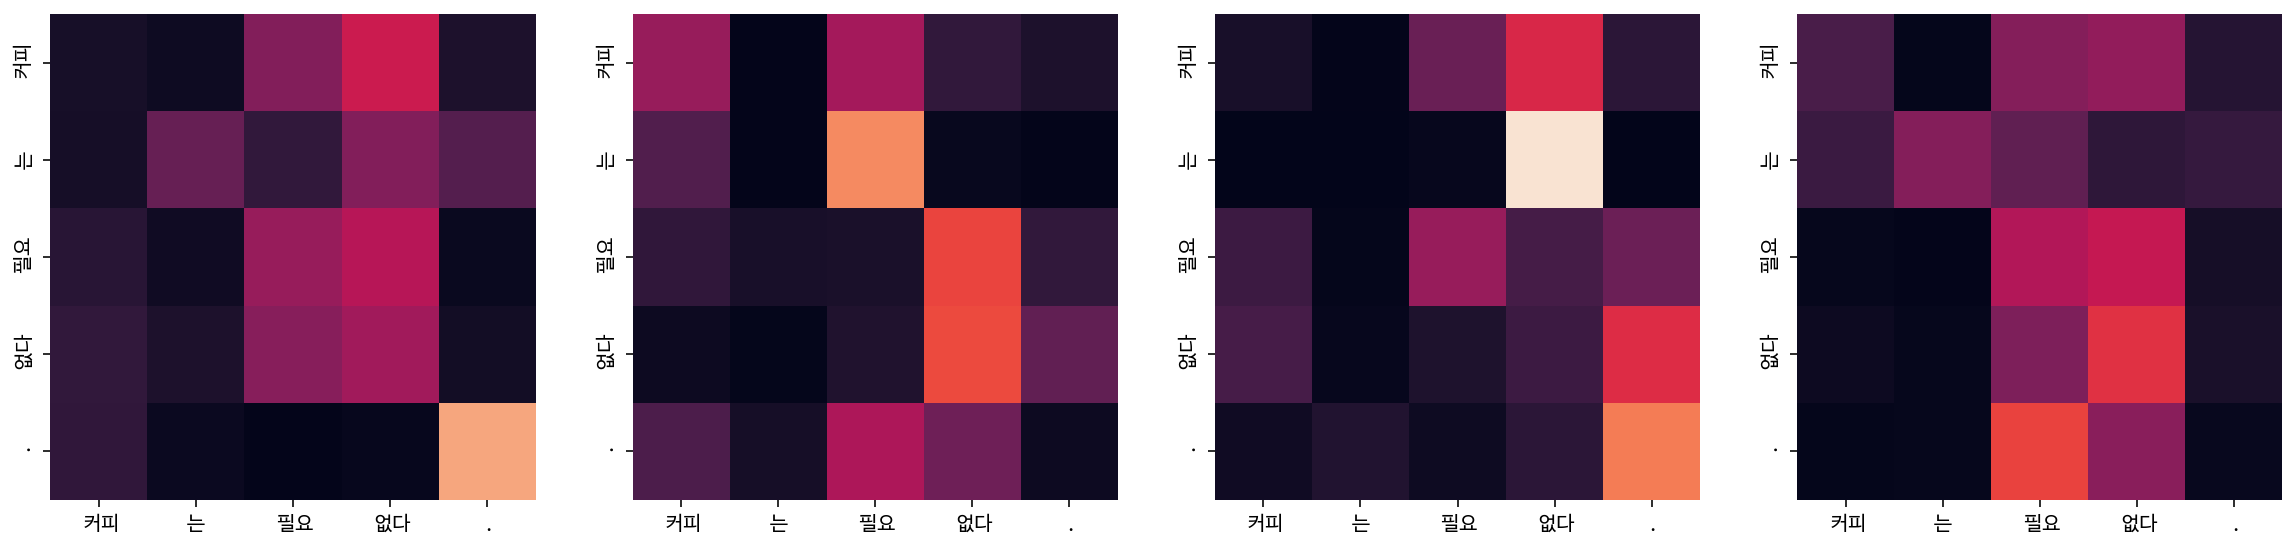

Encoder Layer 2


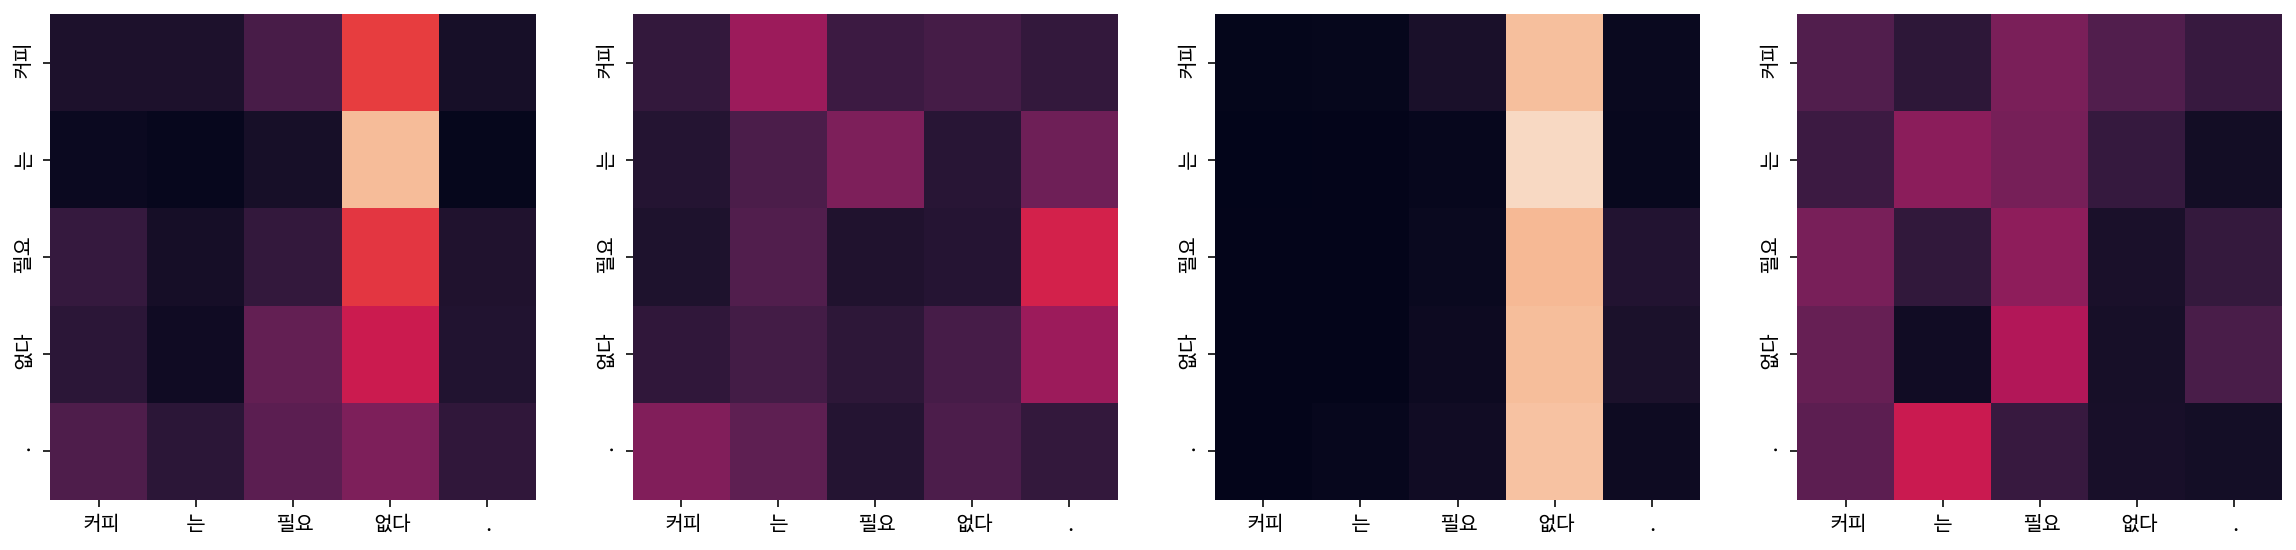

Decoder Self Layer 1


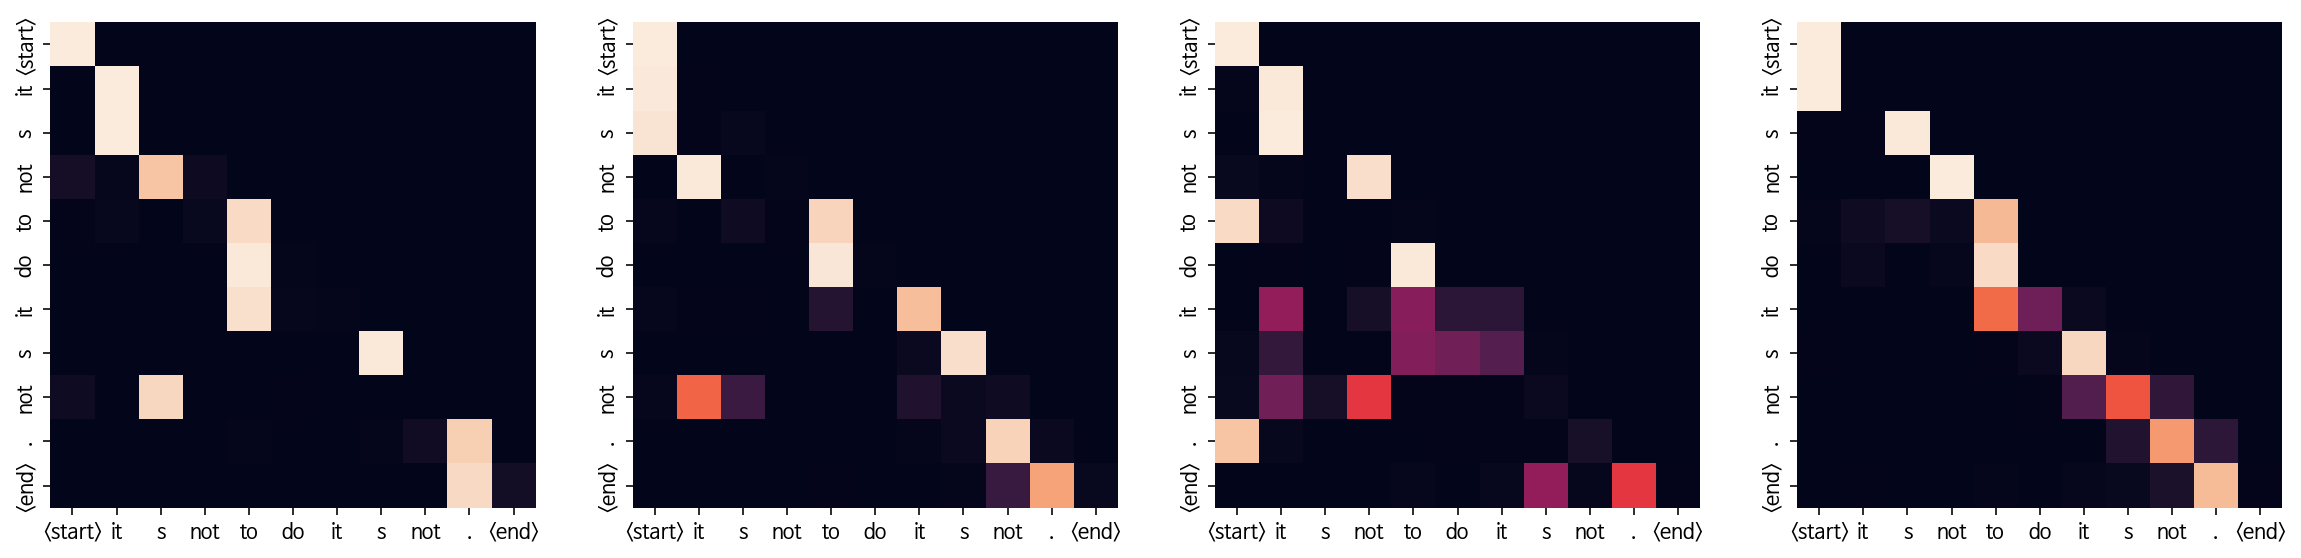

Decoder Src Layer 1


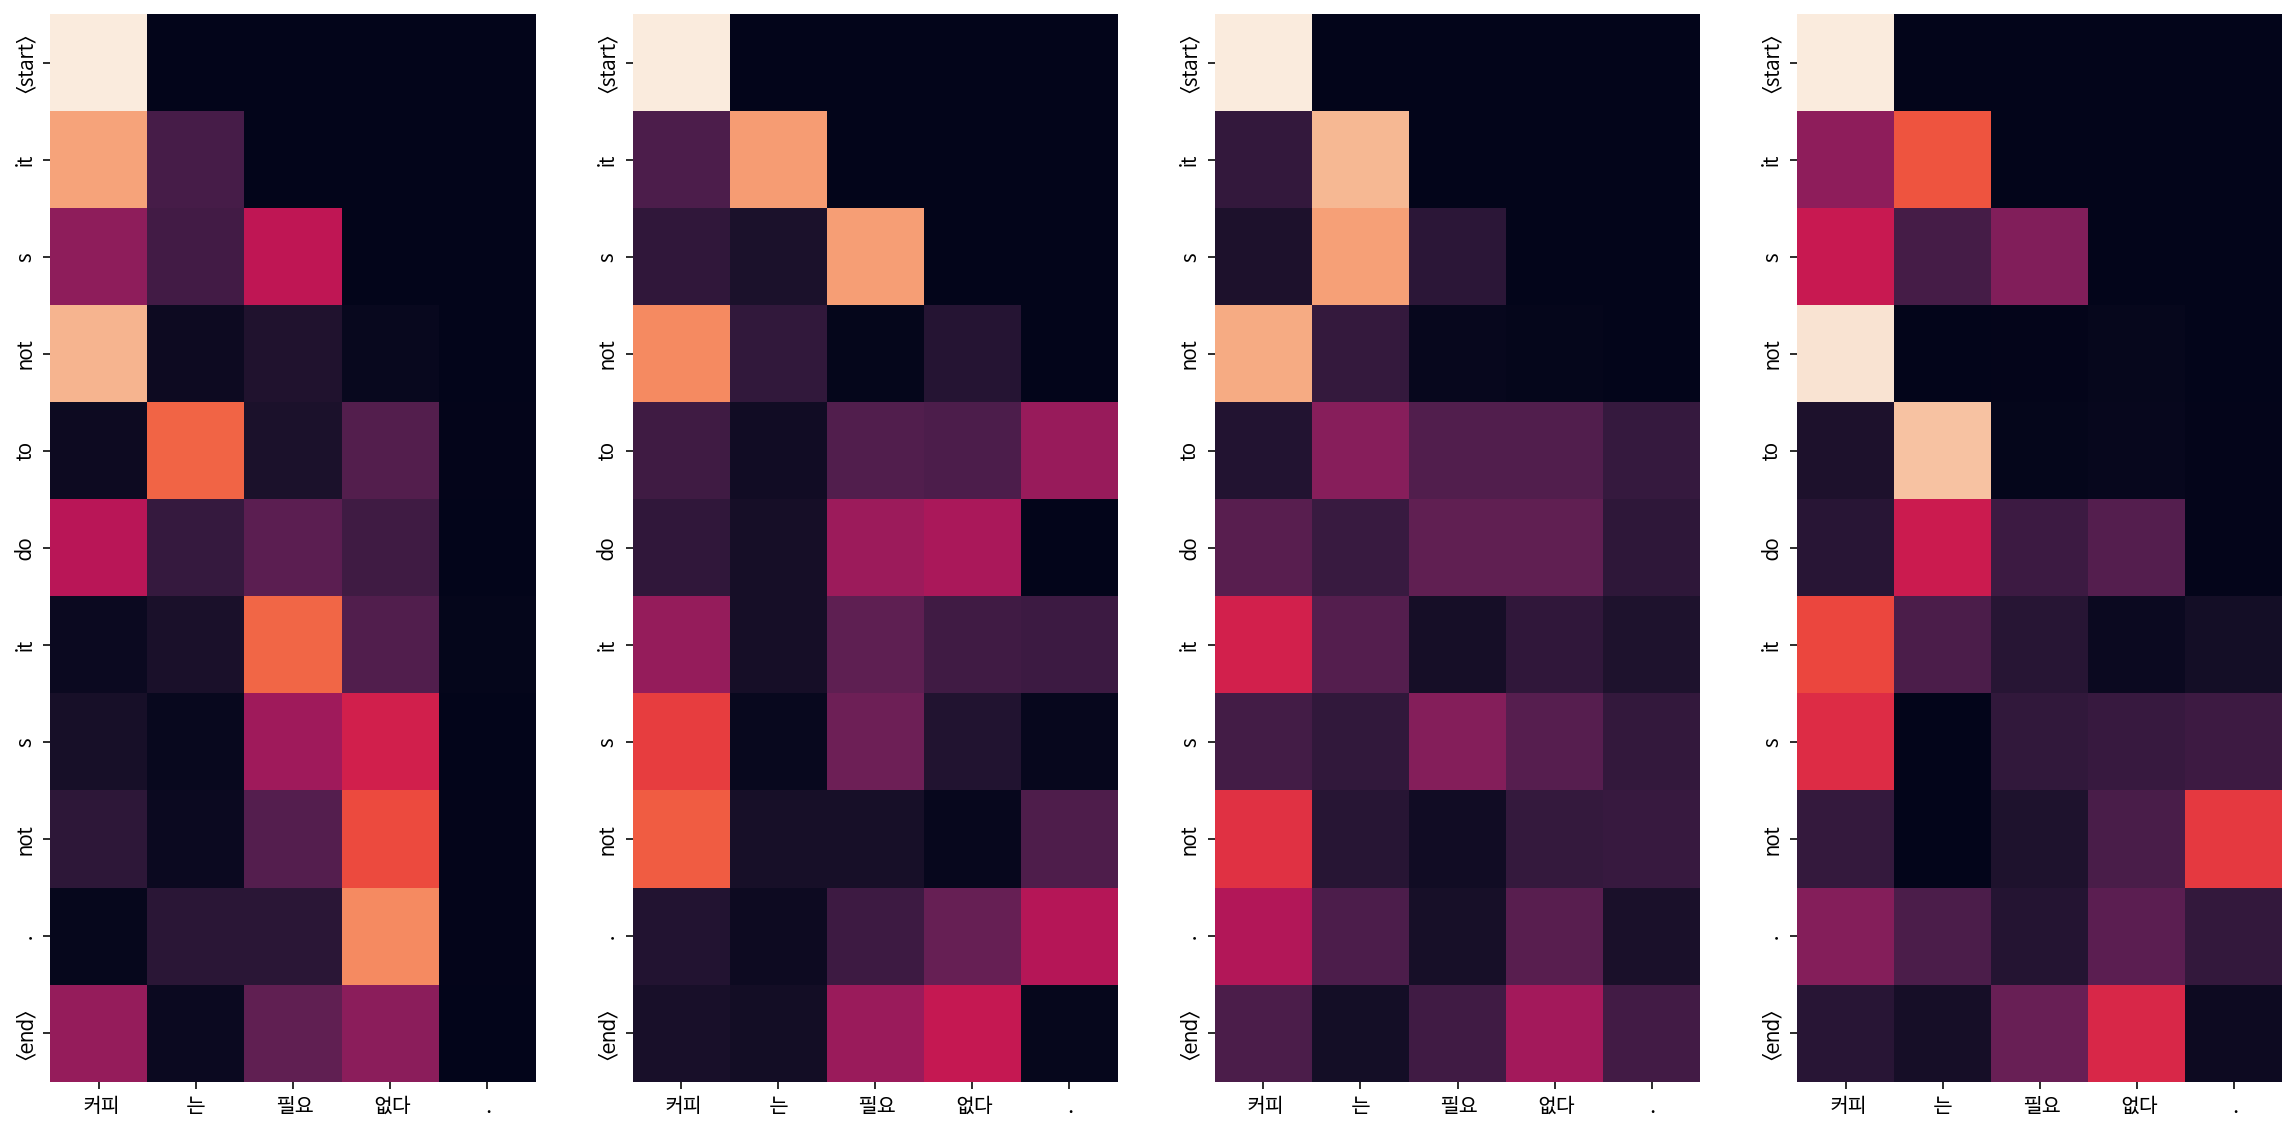

Decoder Self Layer 2


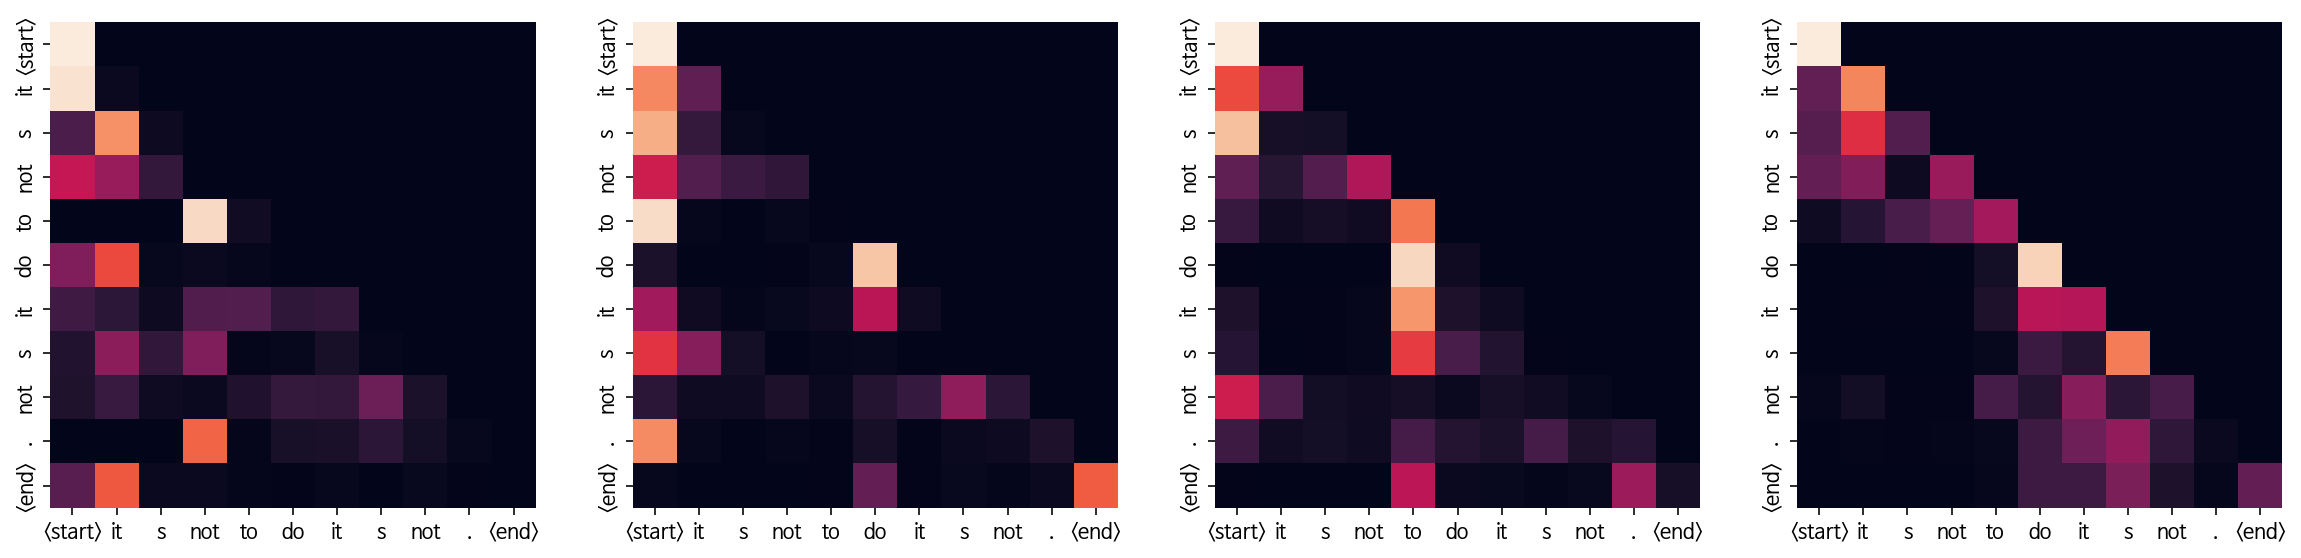

Decoder Src Layer 2


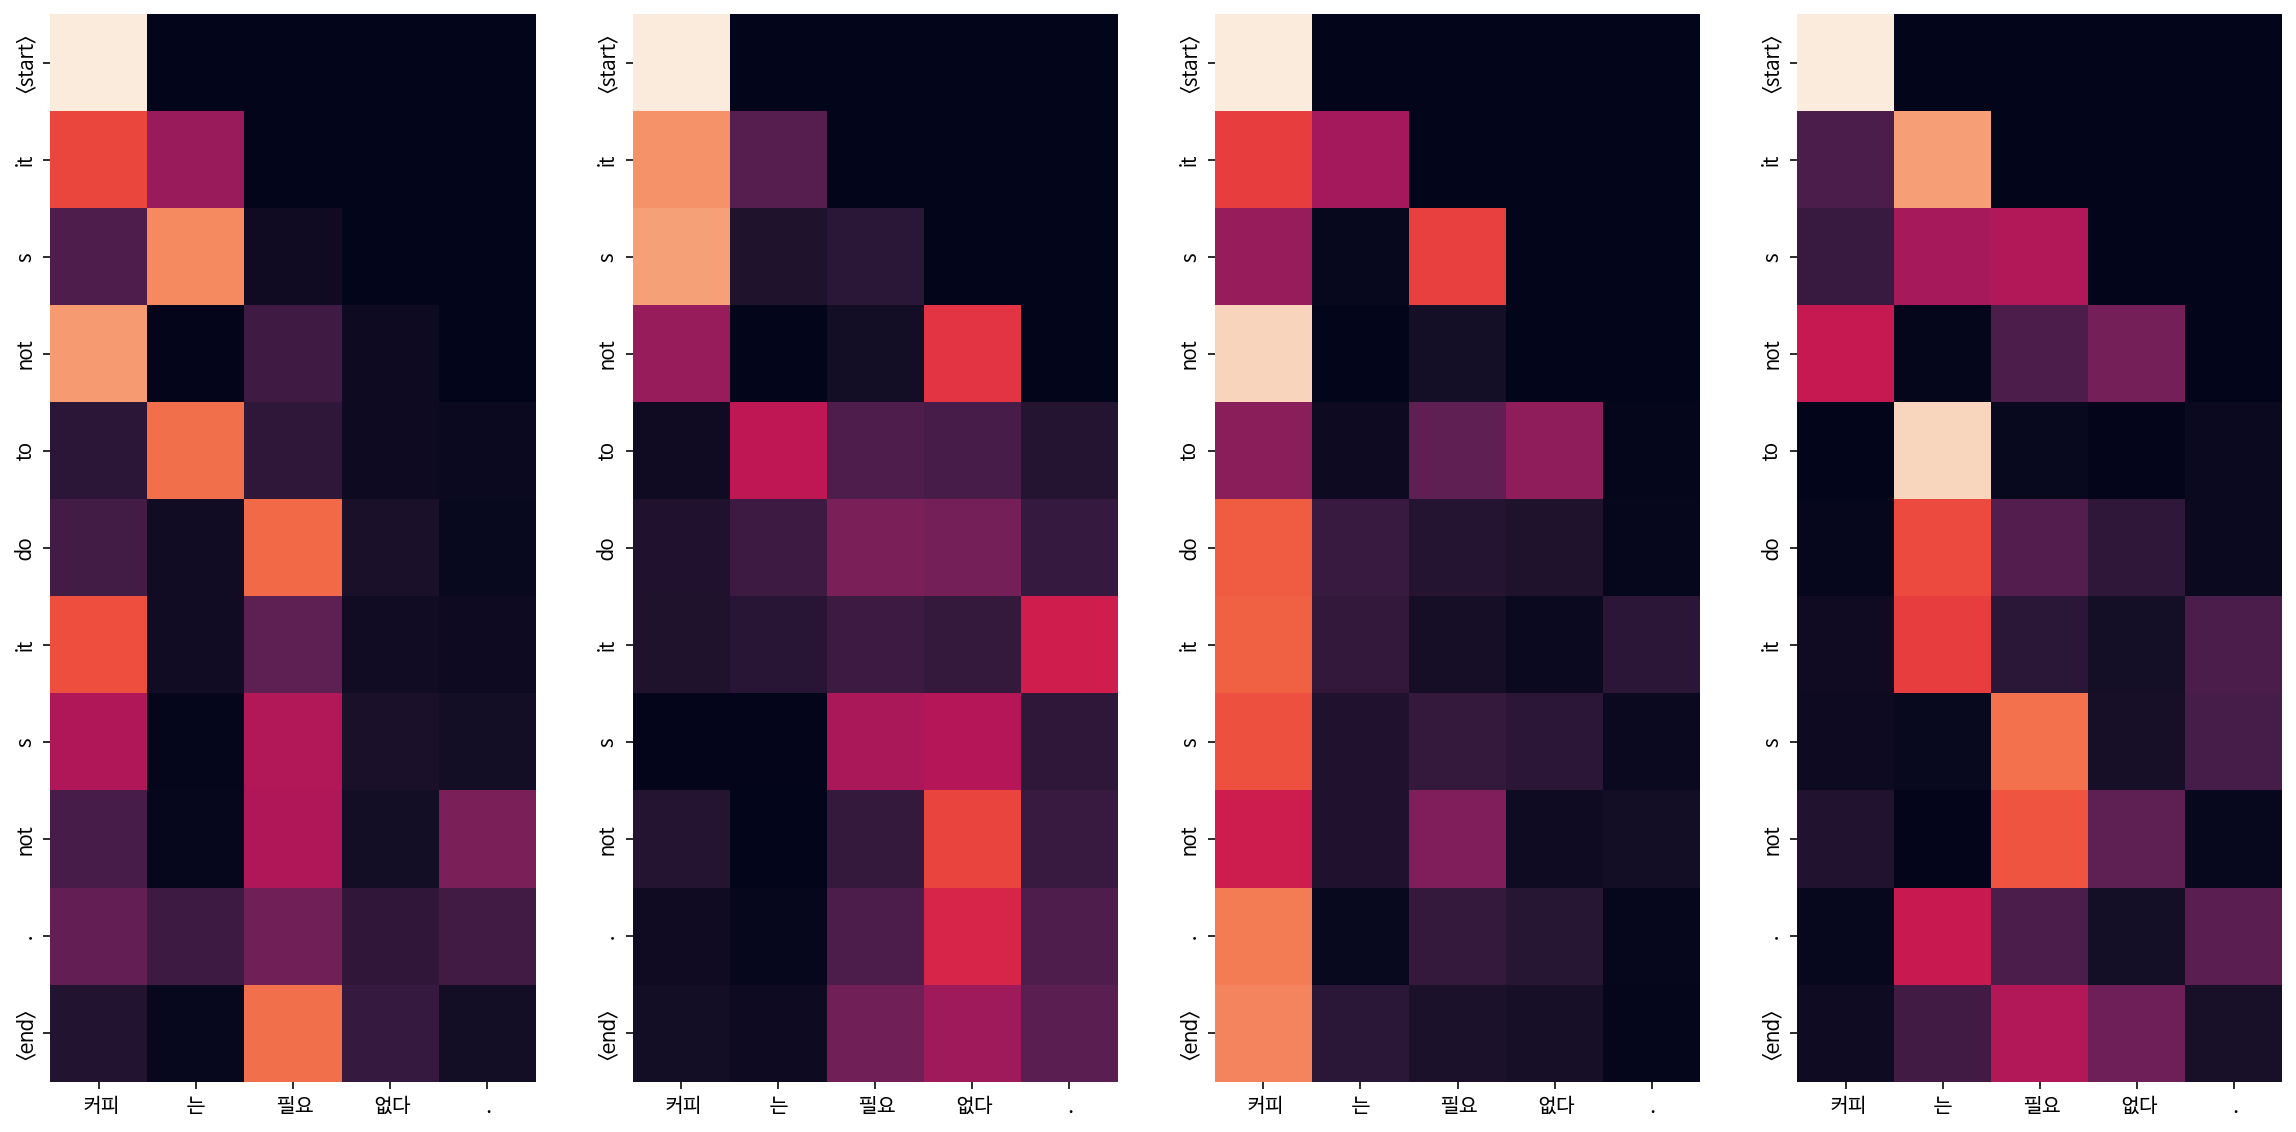

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <start> the death toll was killed . <end>
Encoder Layer 1


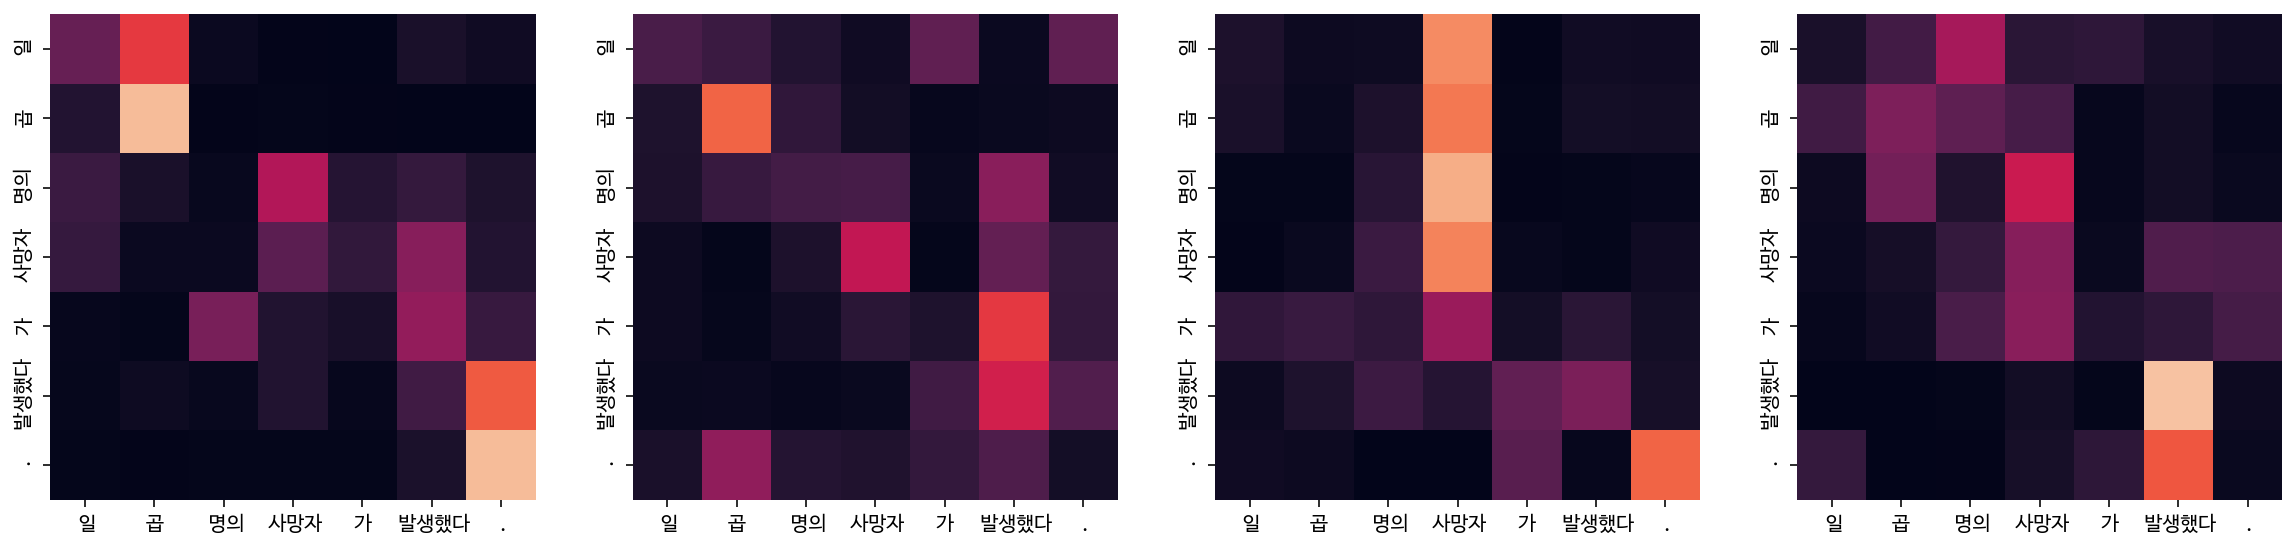

Encoder Layer 2


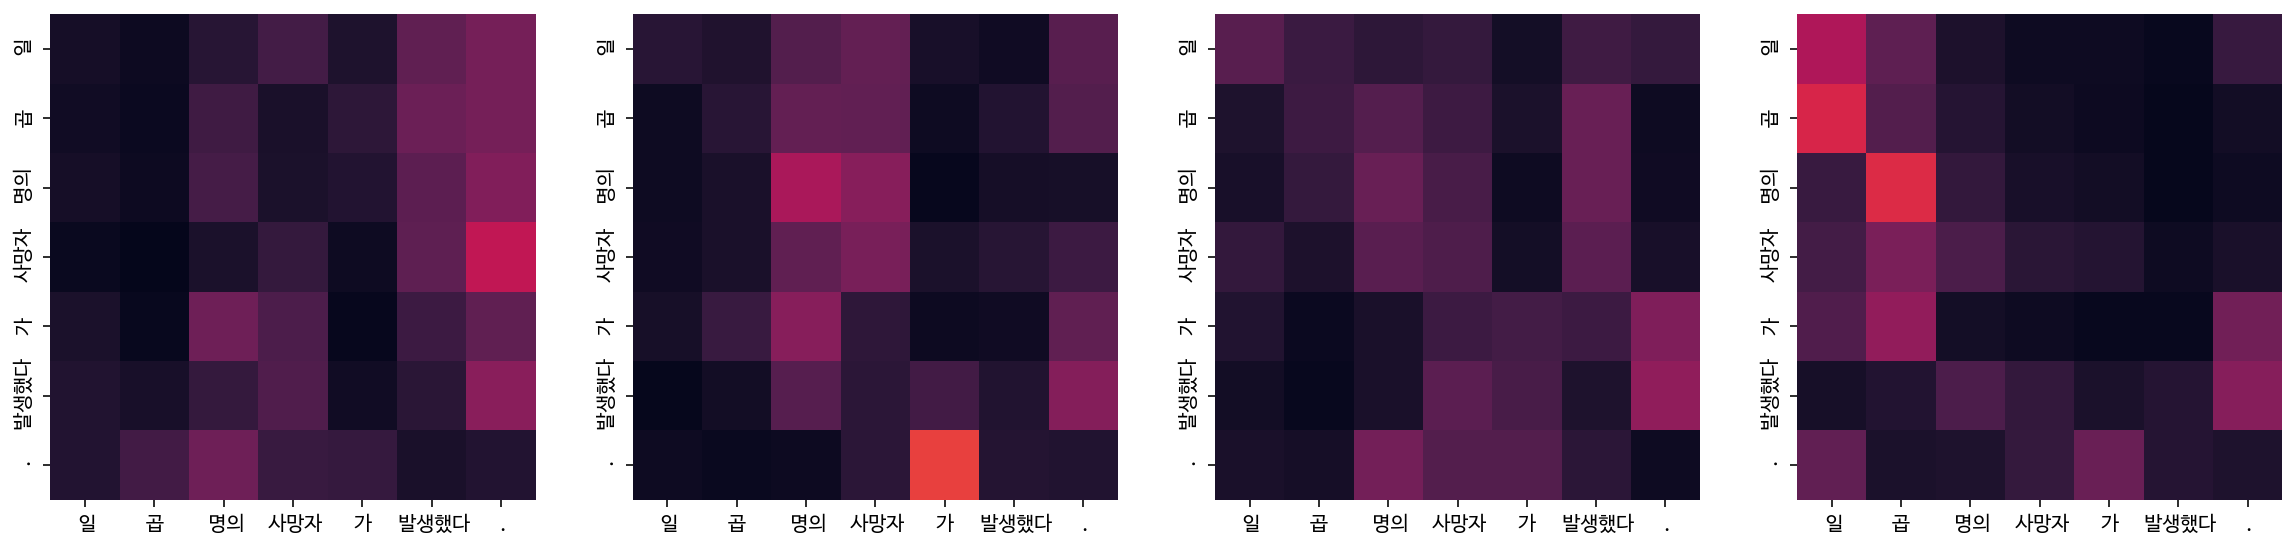

Decoder Self Layer 1


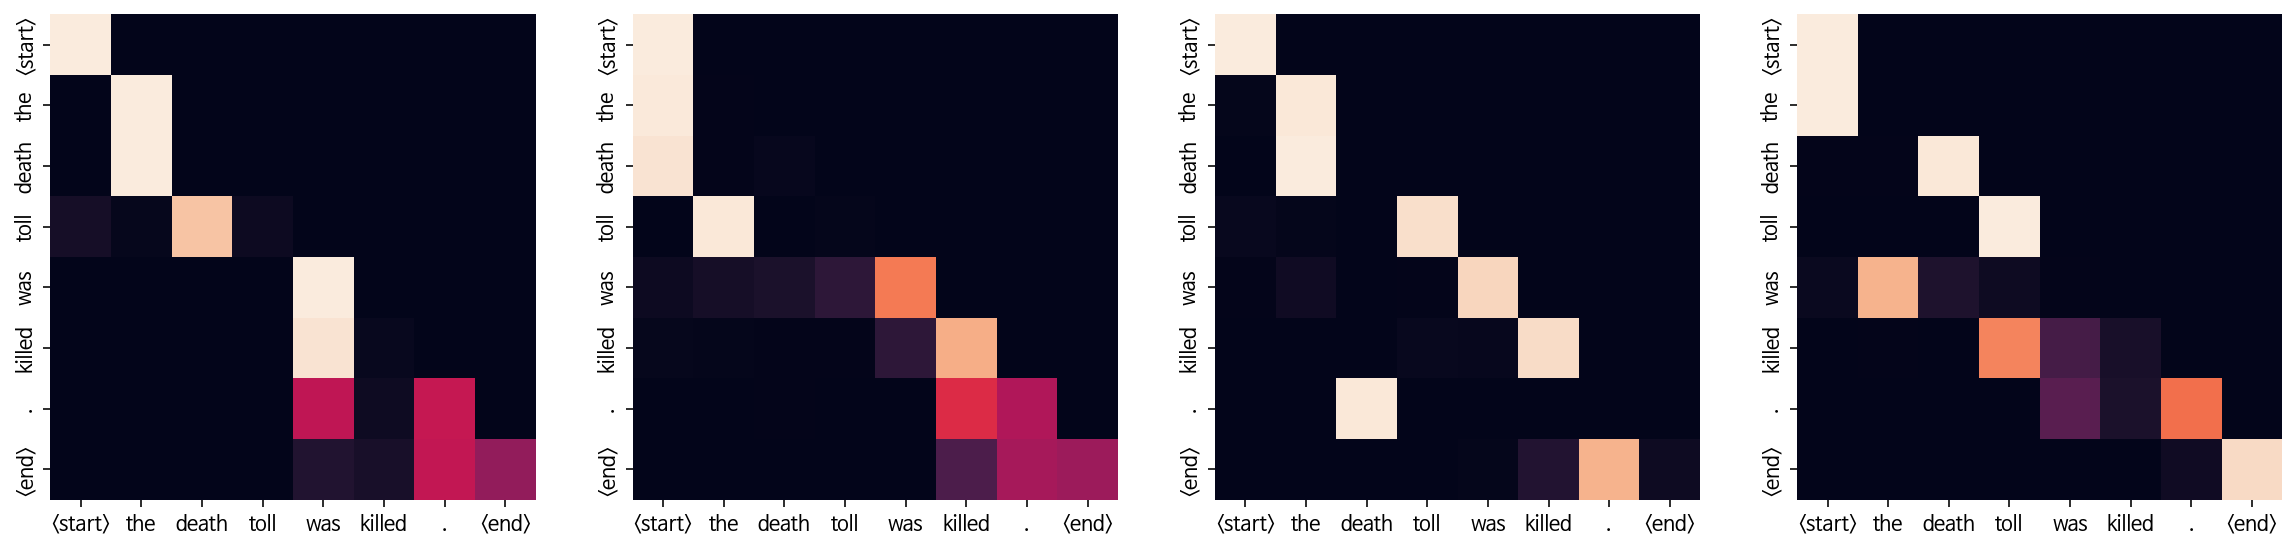

Decoder Src Layer 1


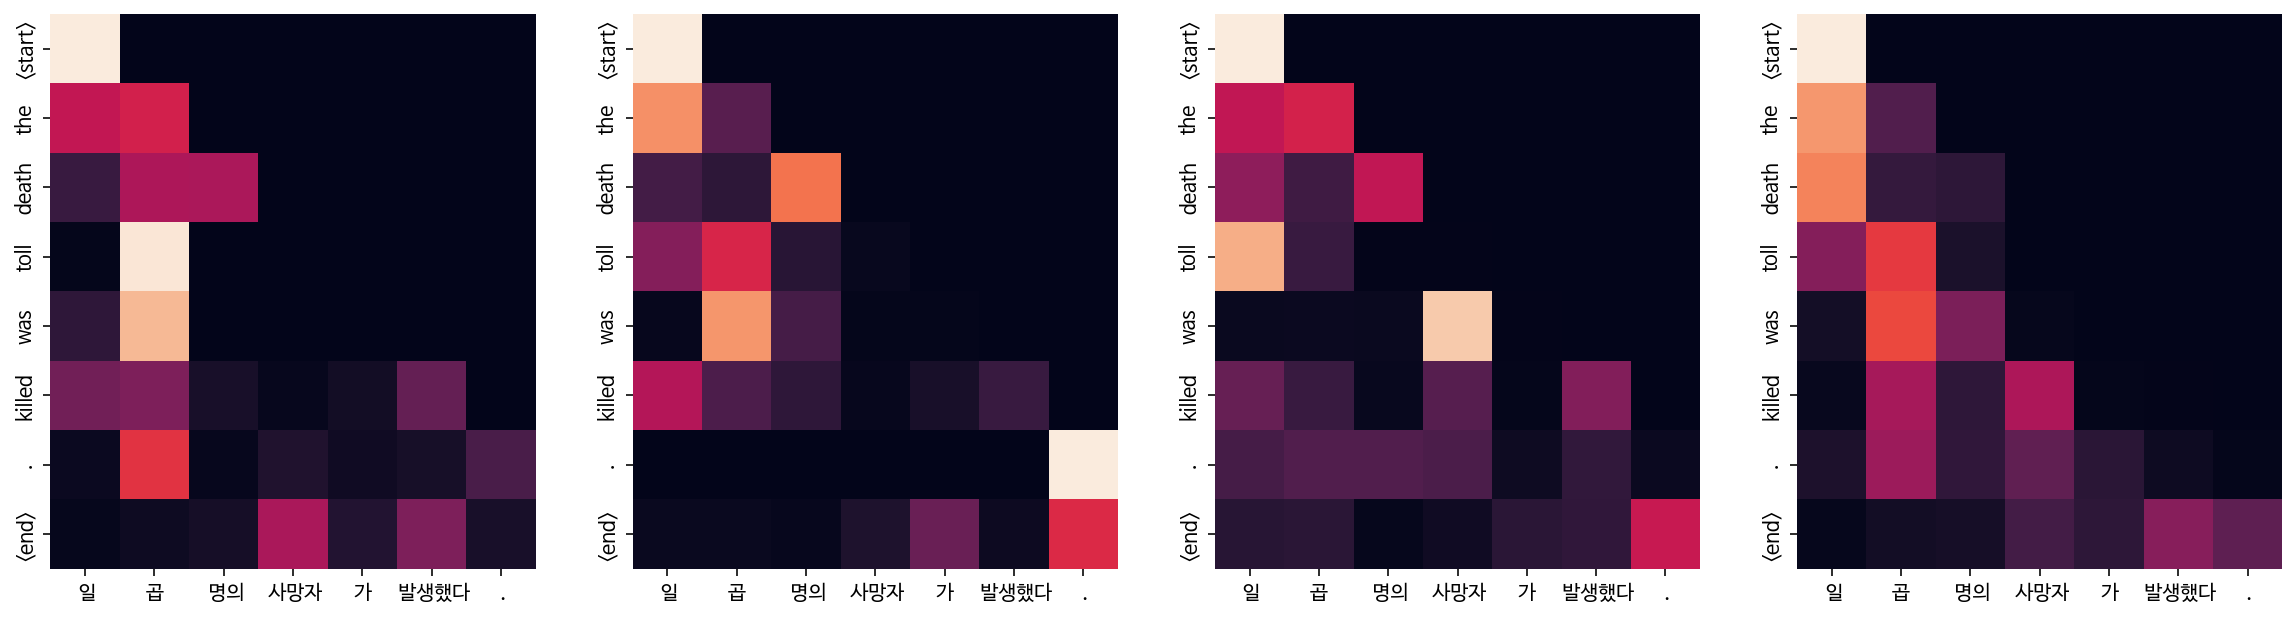

Decoder Self Layer 2


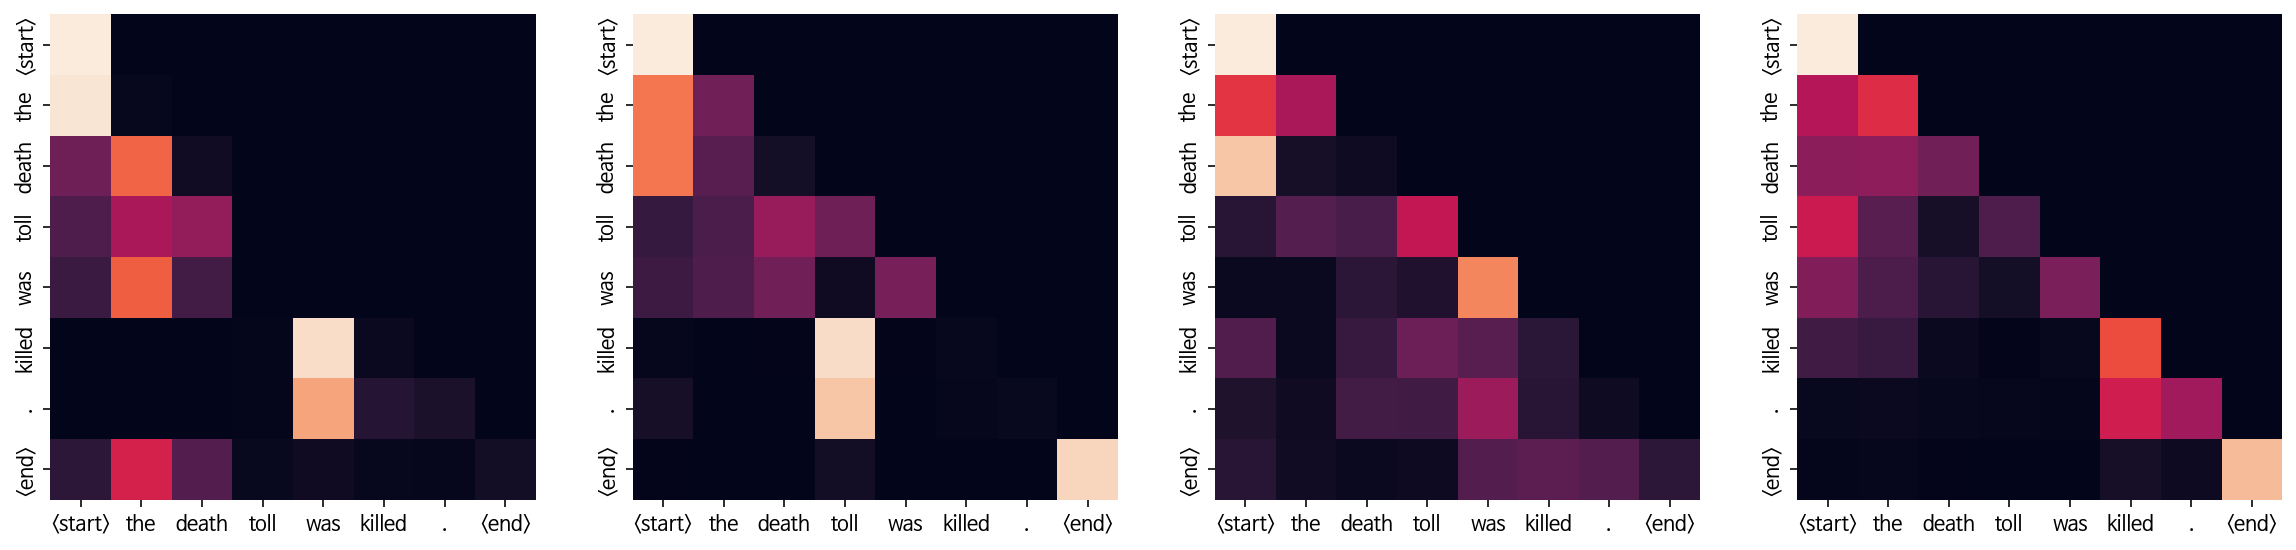

Decoder Src Layer 2


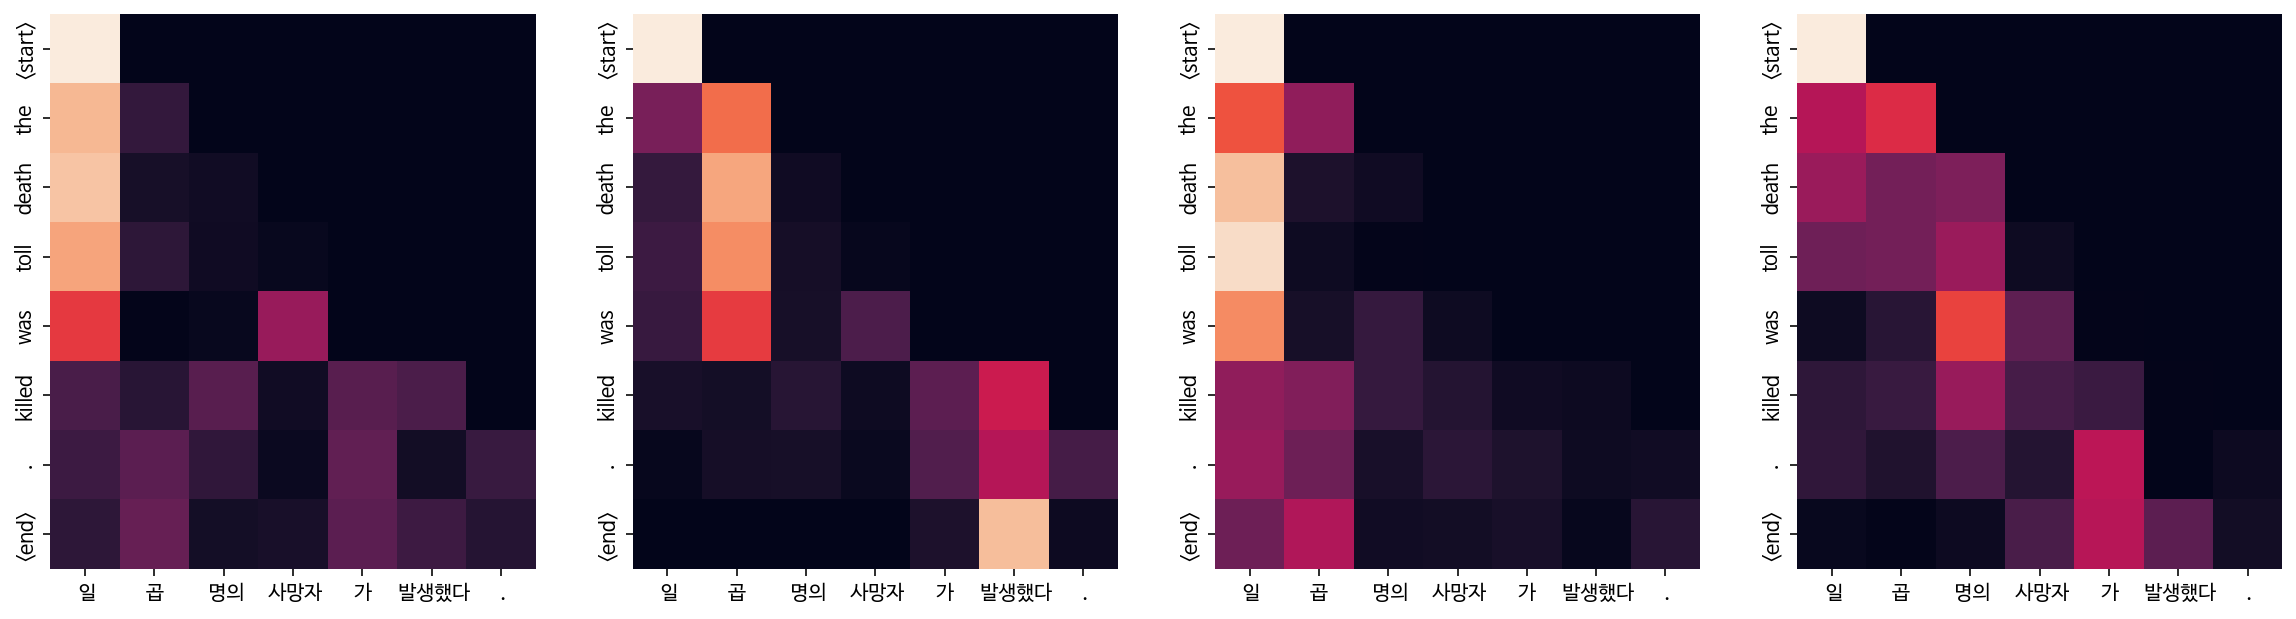

  0%|          | 0/3683 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: <start> obama is the president . <end>
Encoder Layer 1


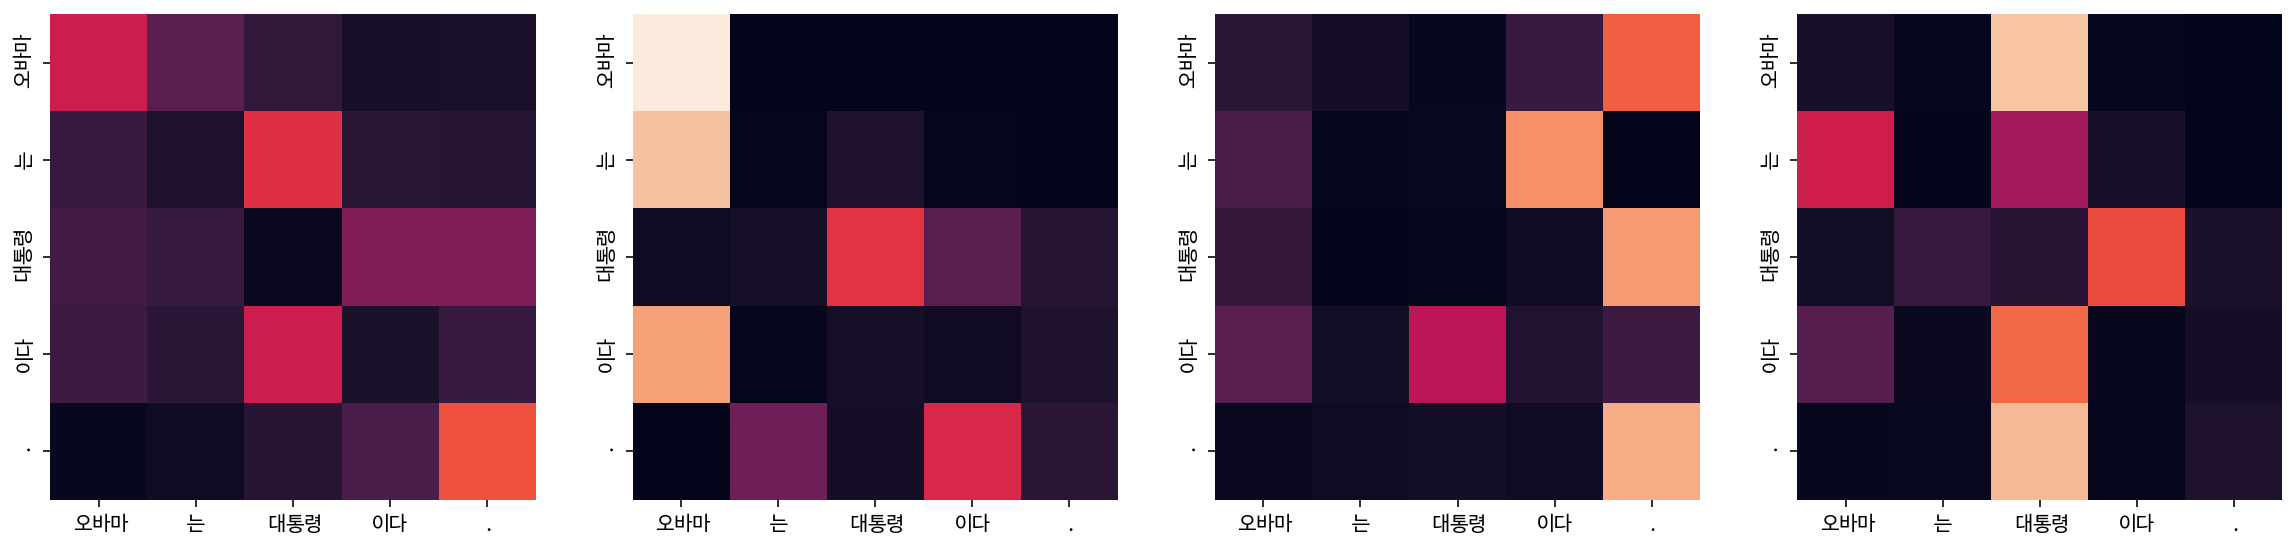

Encoder Layer 2


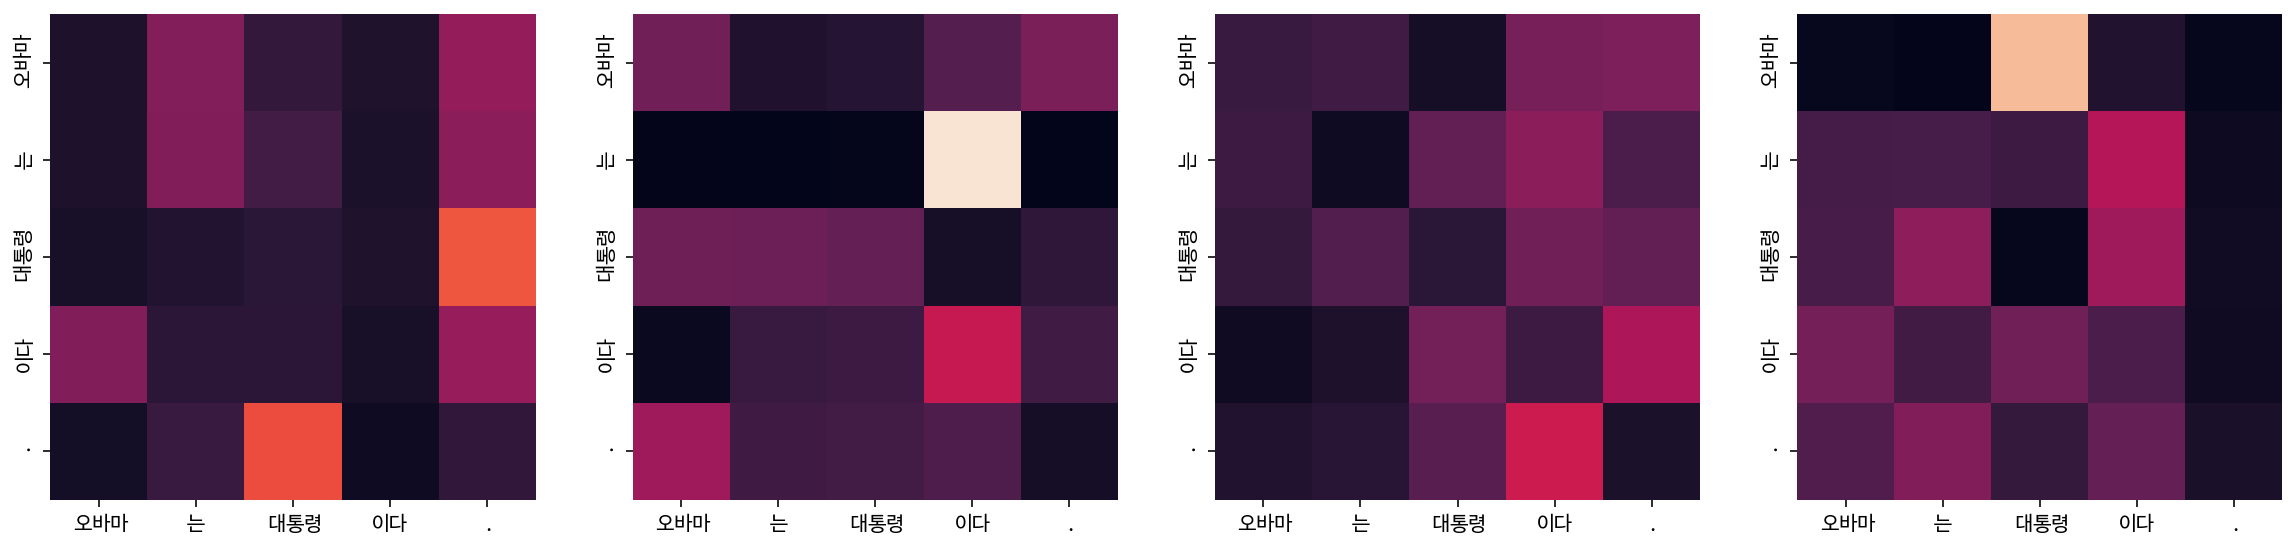

Decoder Self Layer 1


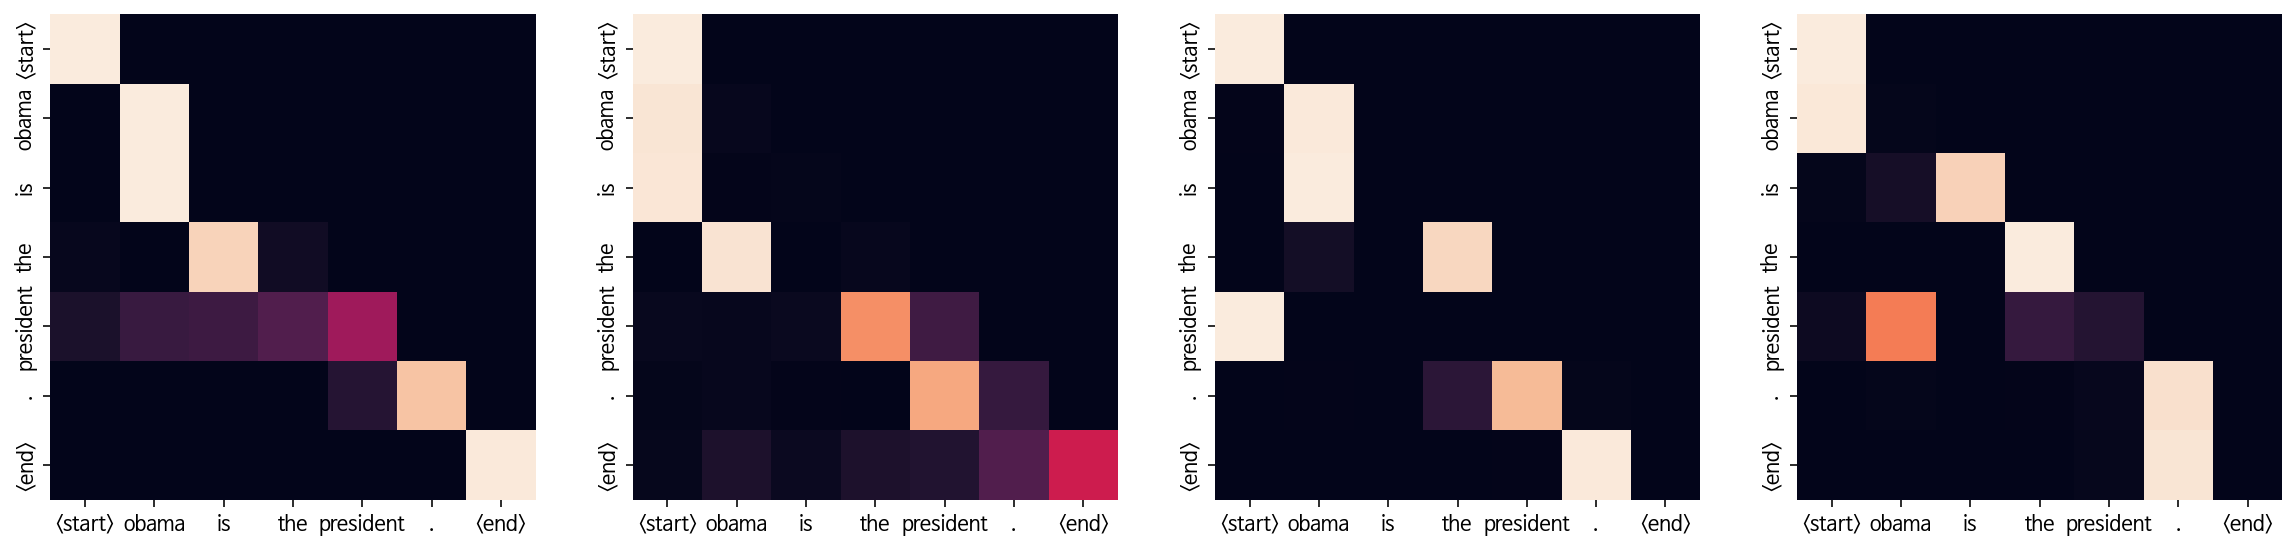

Decoder Src Layer 1


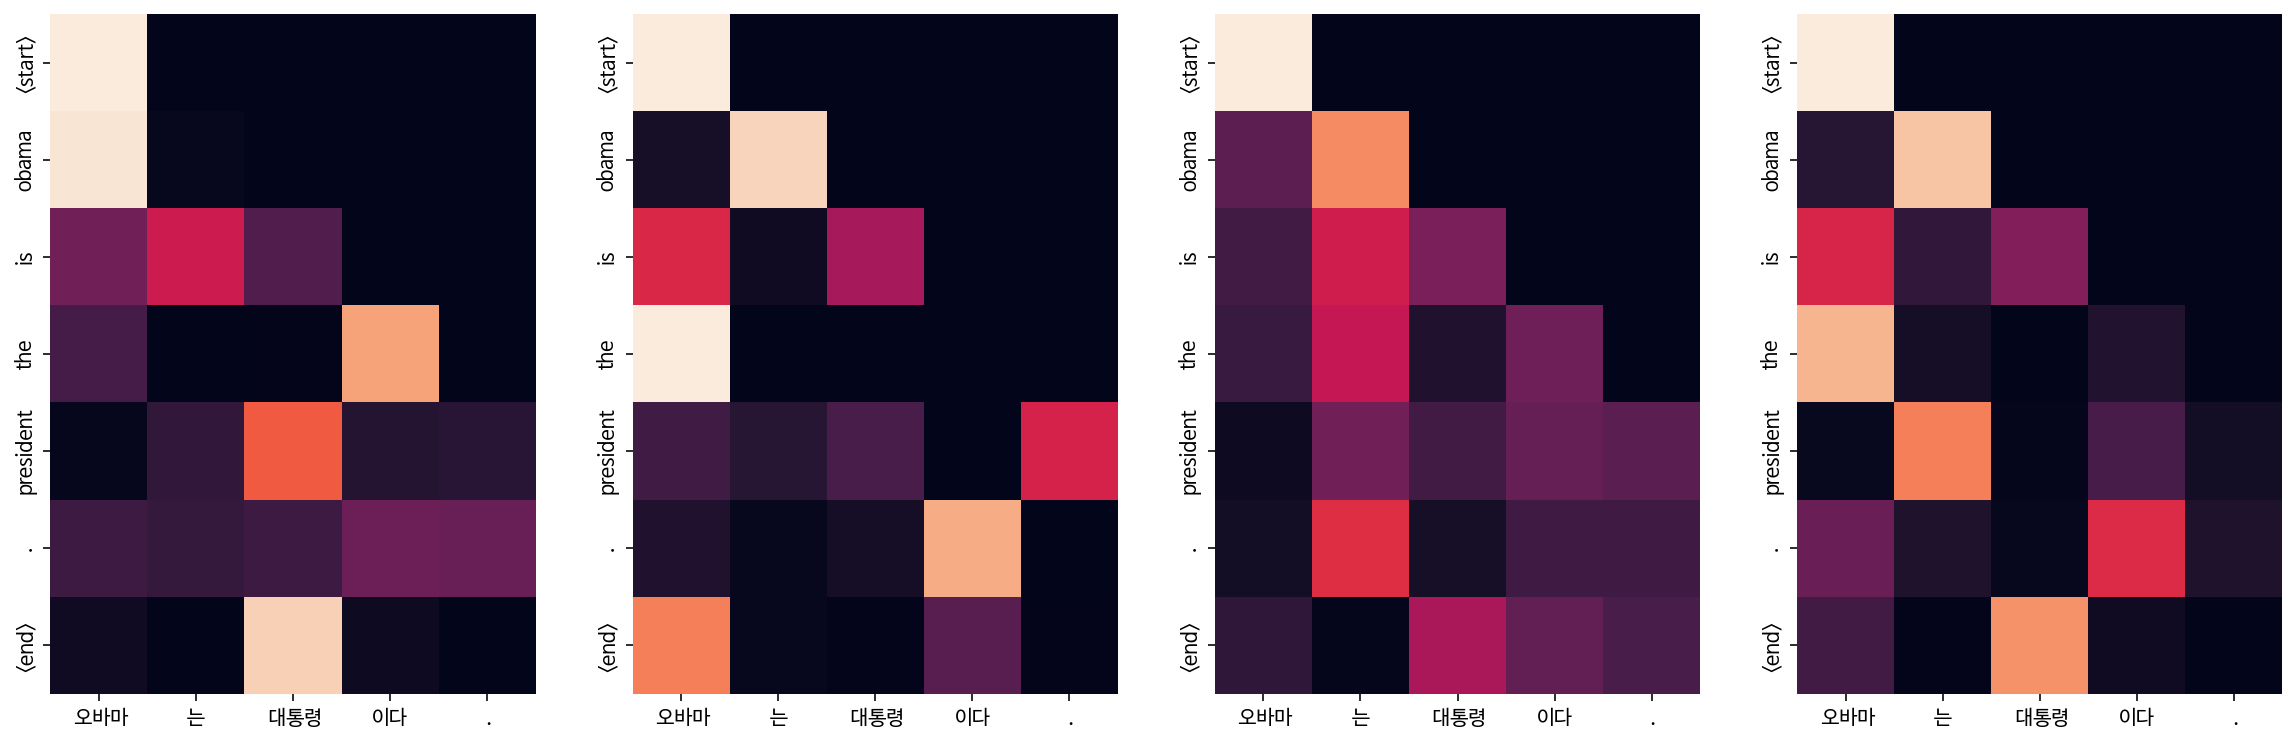

Decoder Self Layer 2


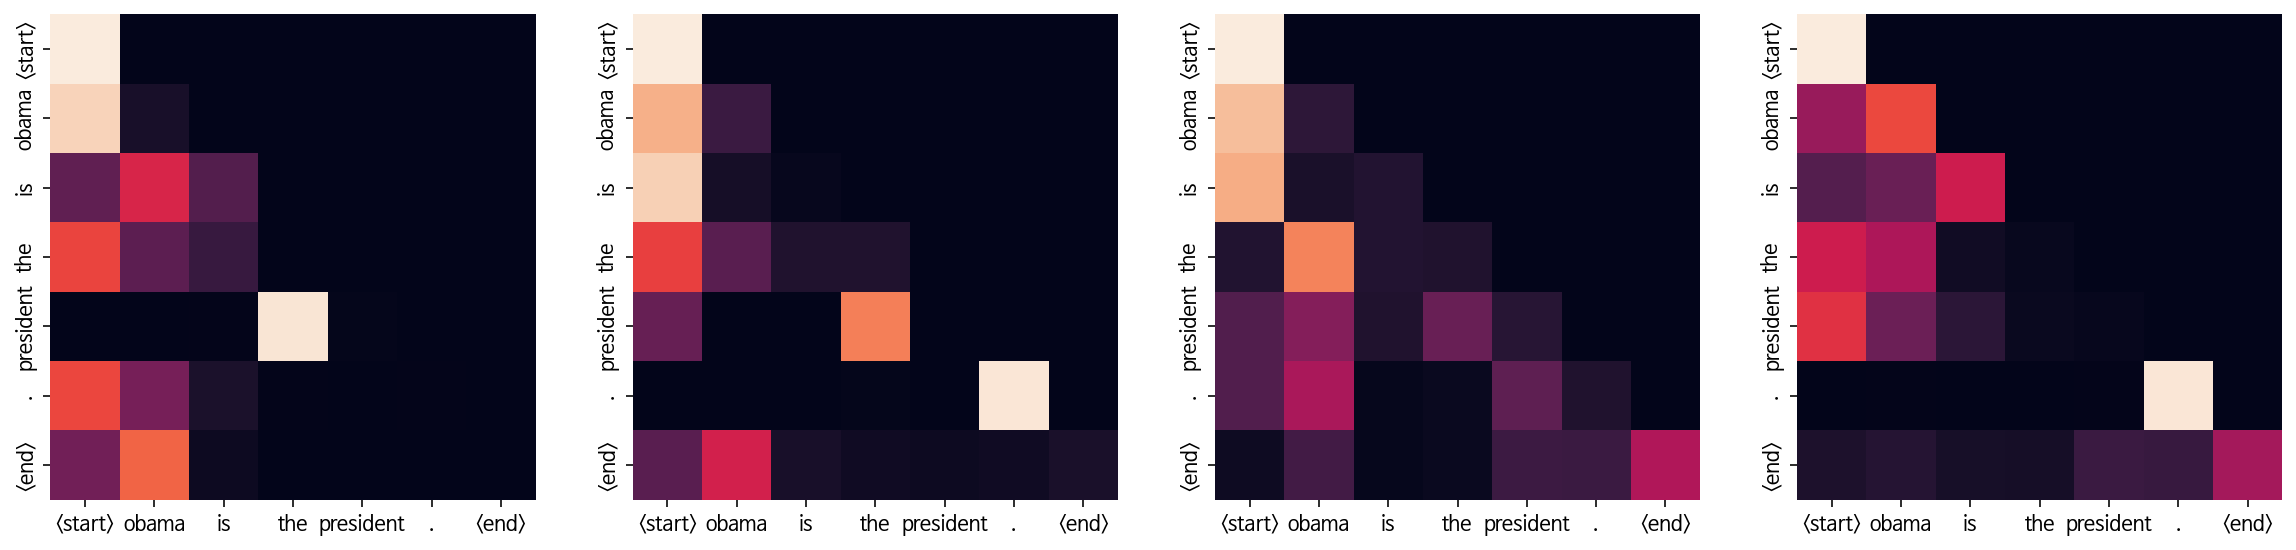

Decoder Src Layer 2


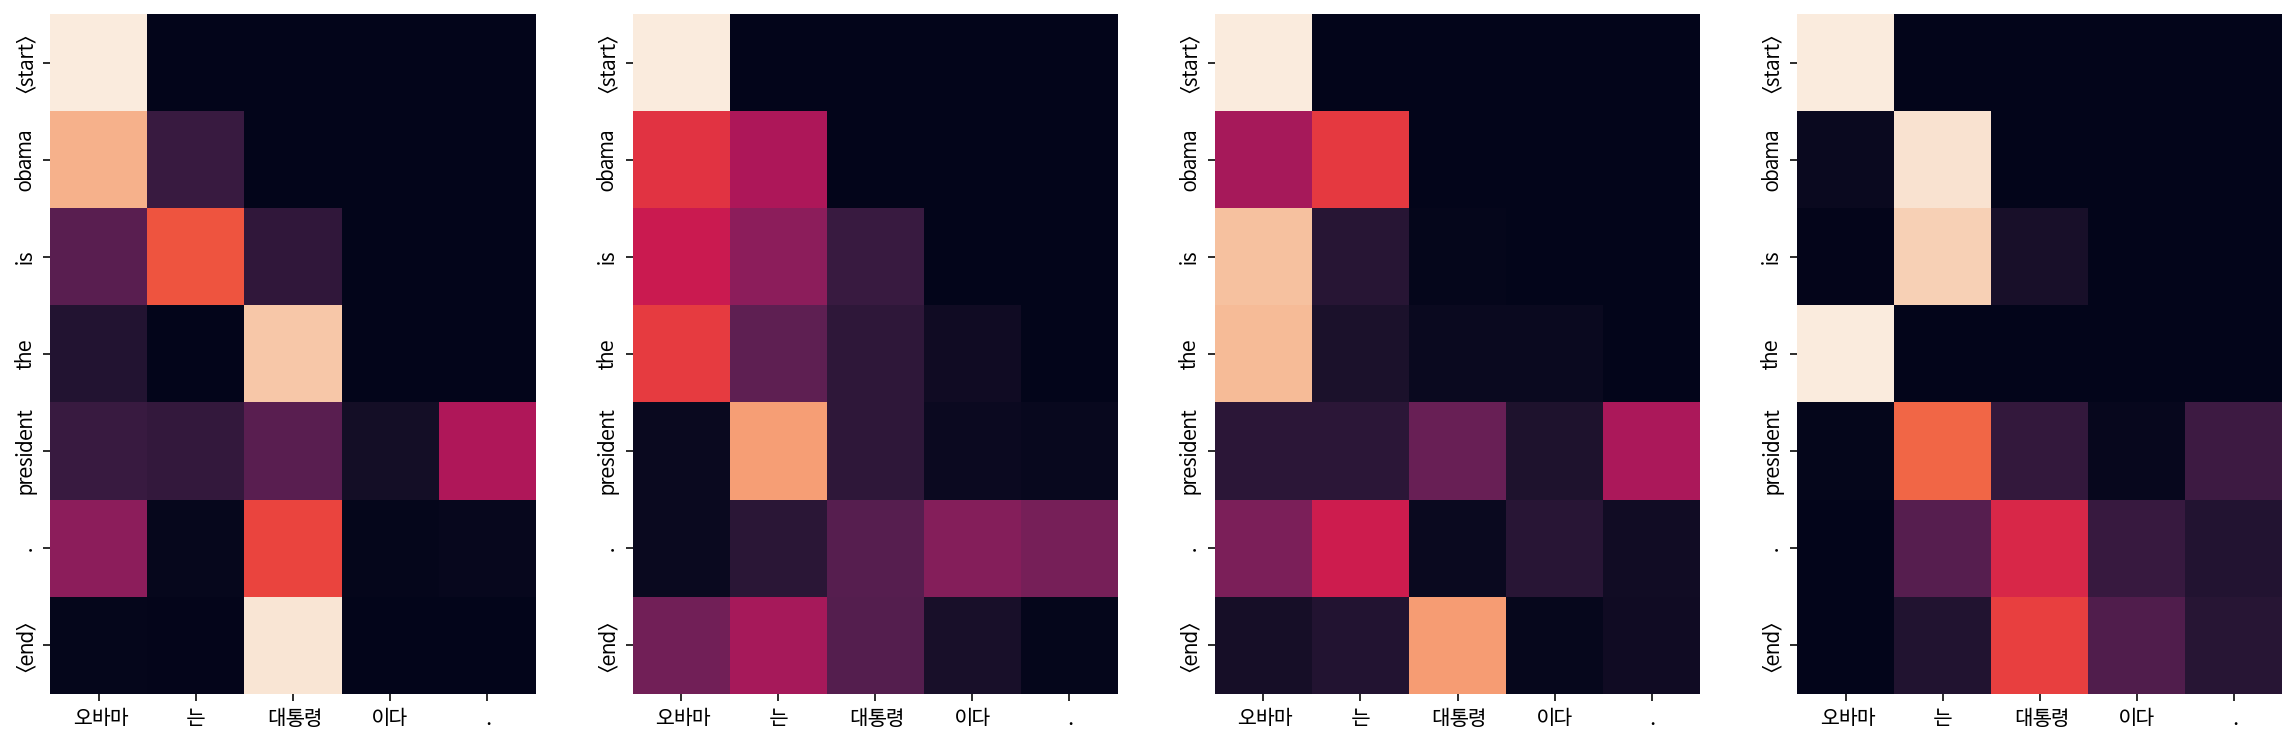

Input: 시민들은 도시 속에 산다.
Predicted translation: <start> the city is the second largest city . <end>
Encoder Layer 1


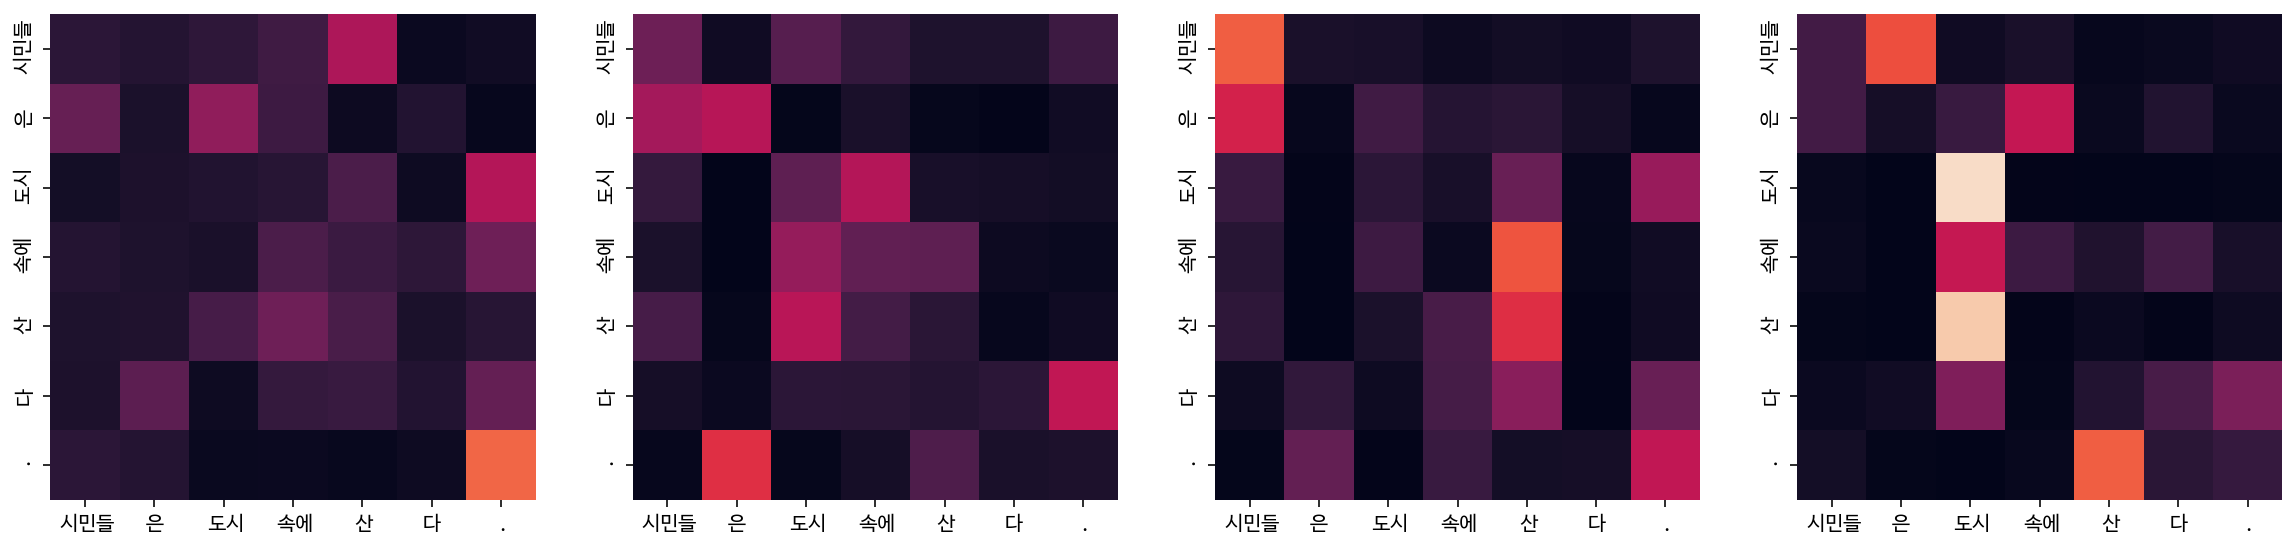

Encoder Layer 2


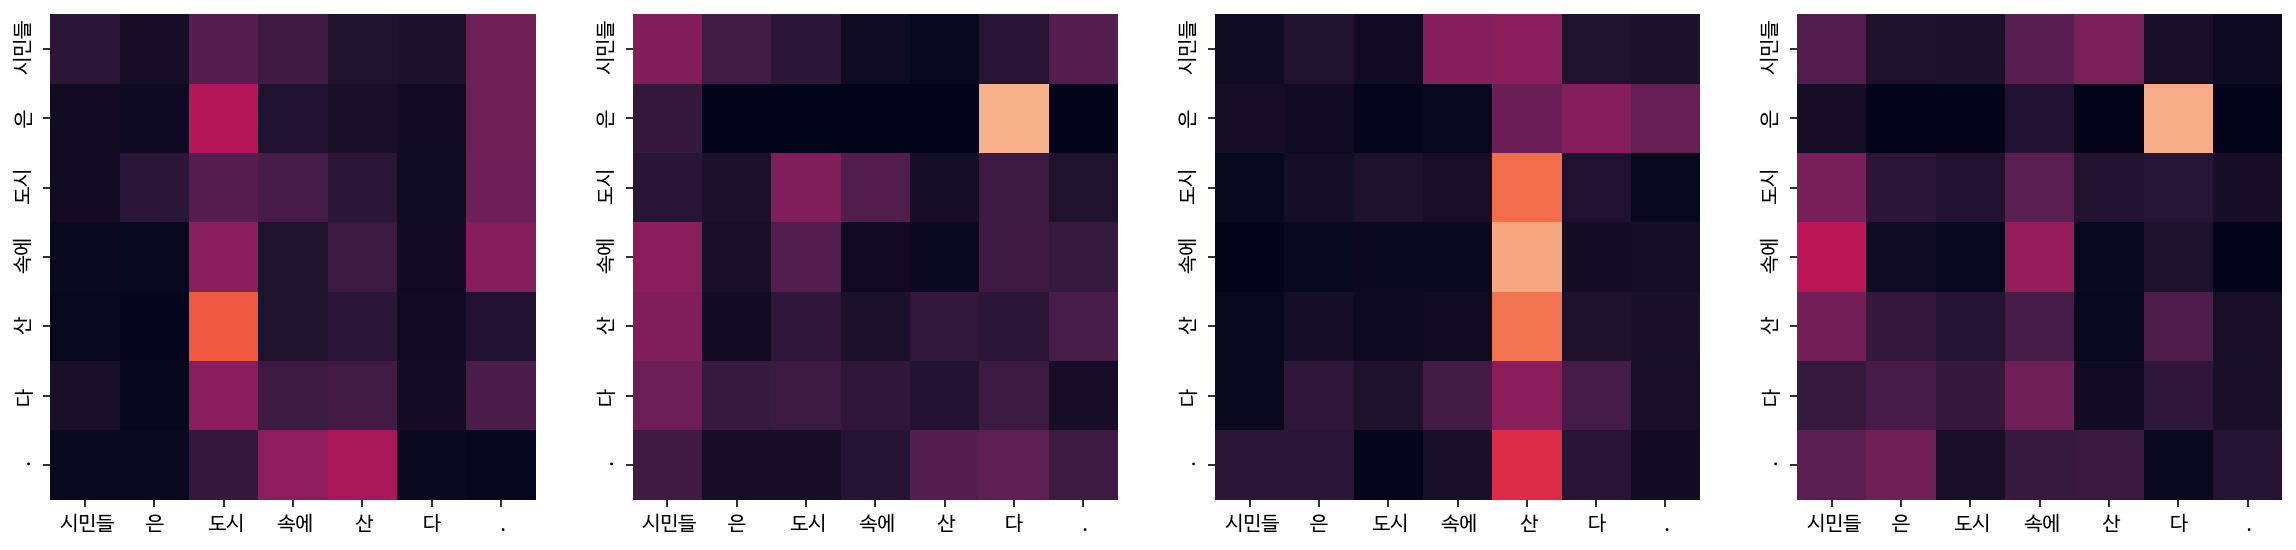

Decoder Self Layer 1


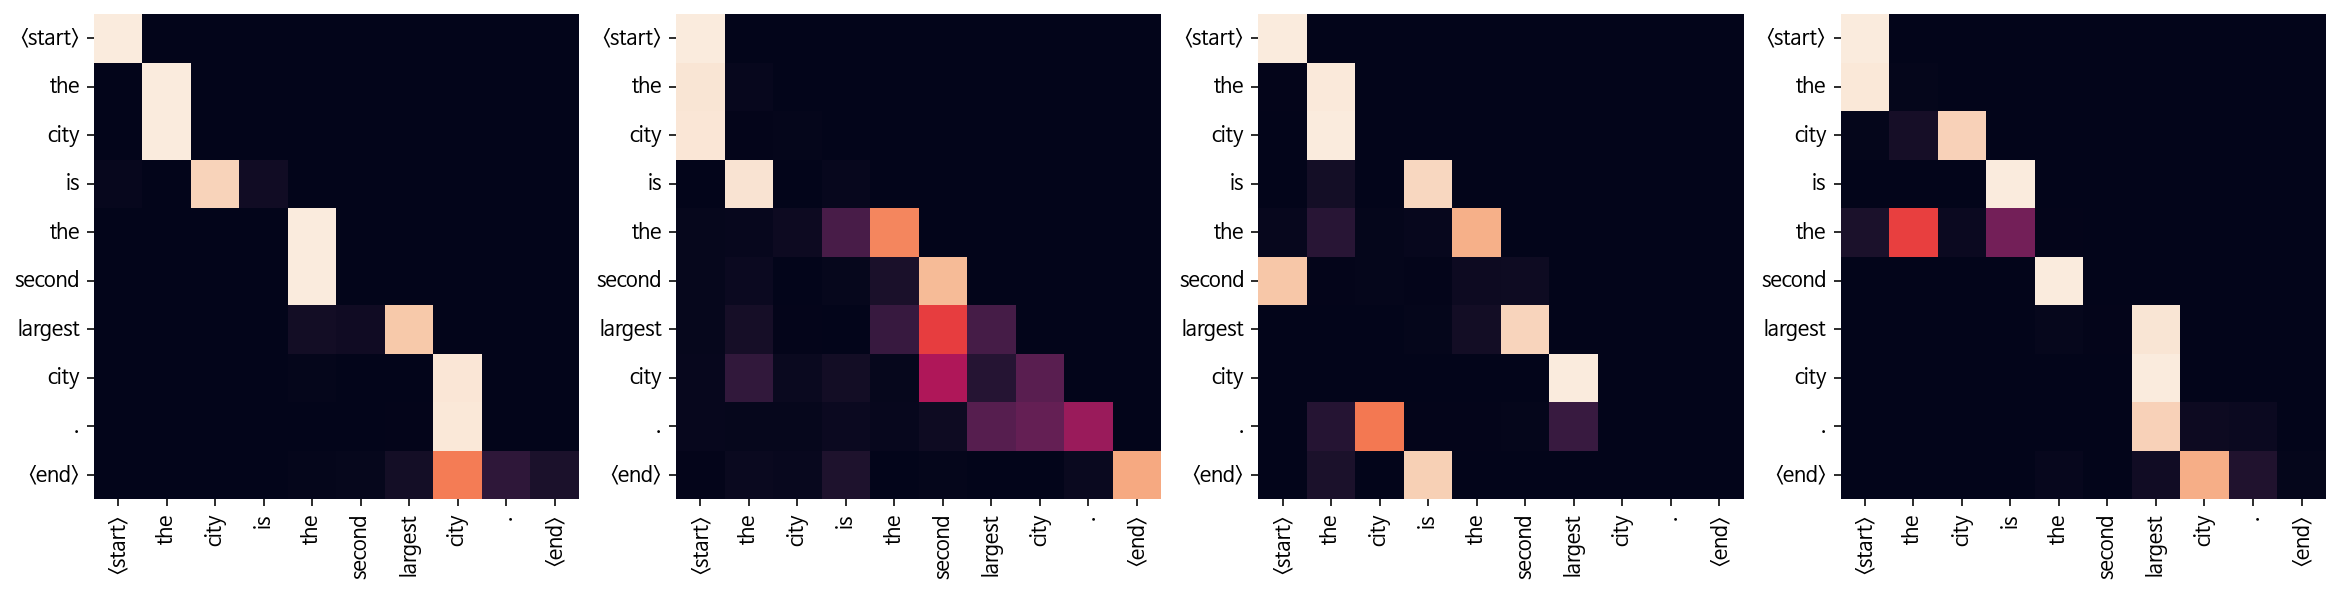

Decoder Src Layer 1


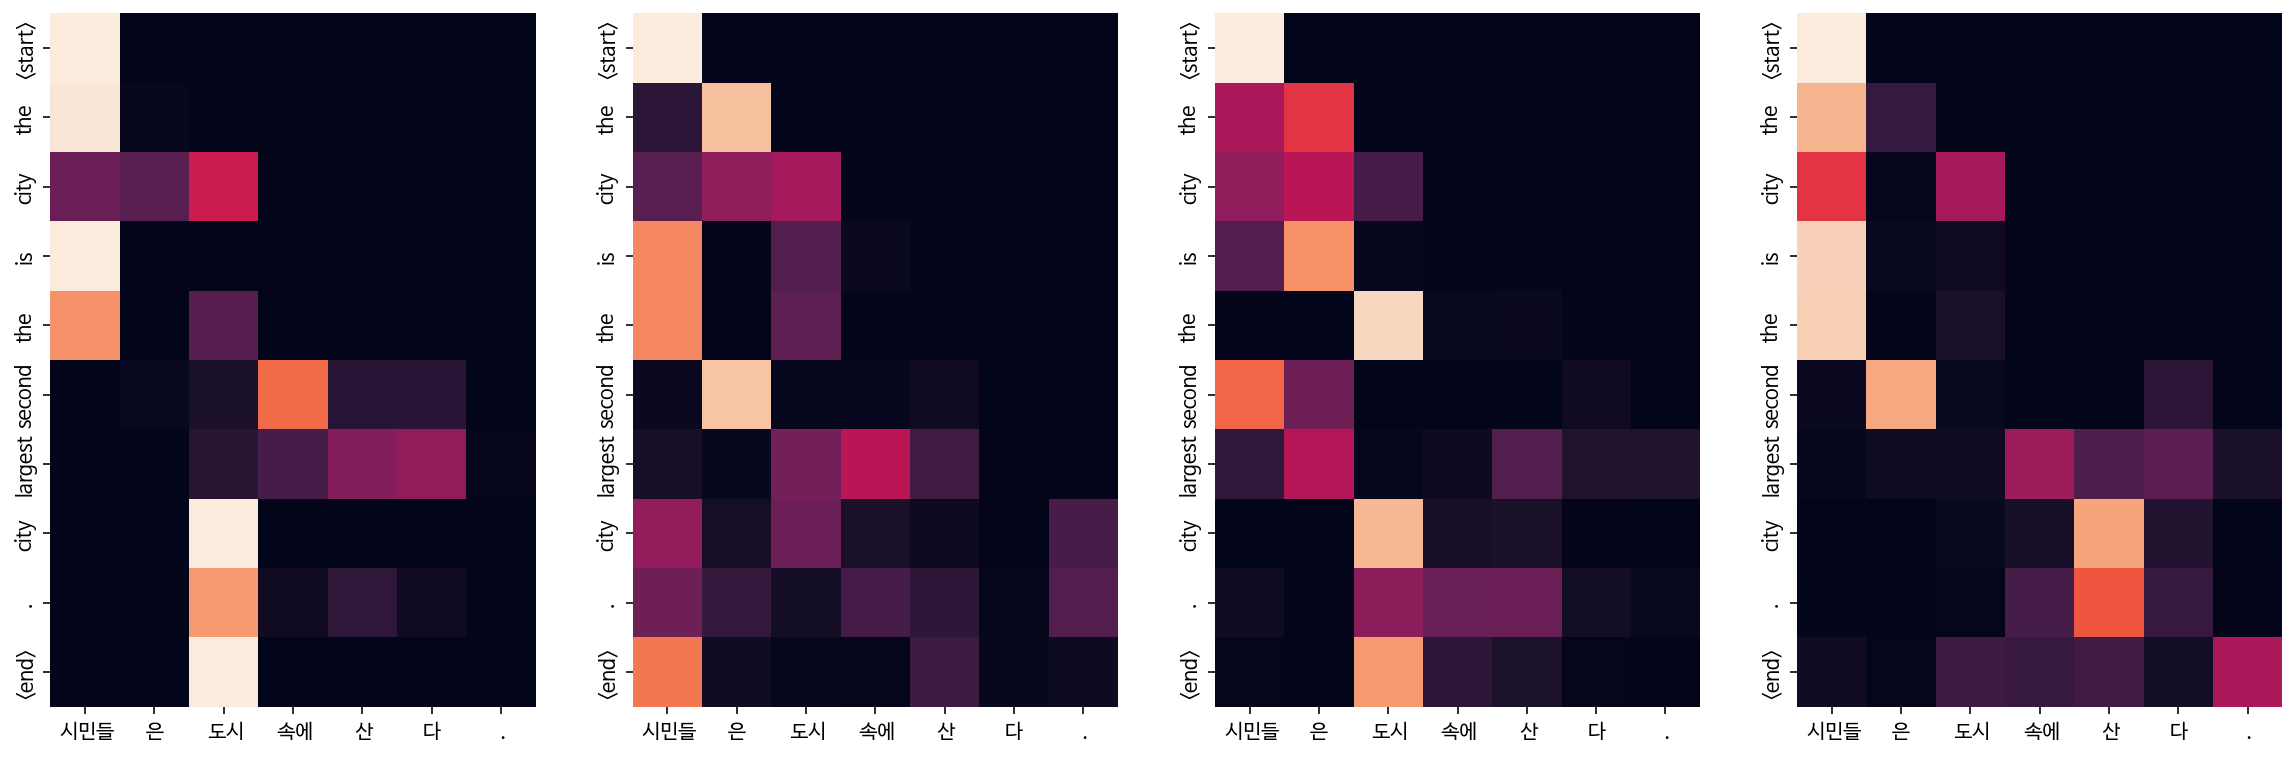

Decoder Self Layer 2


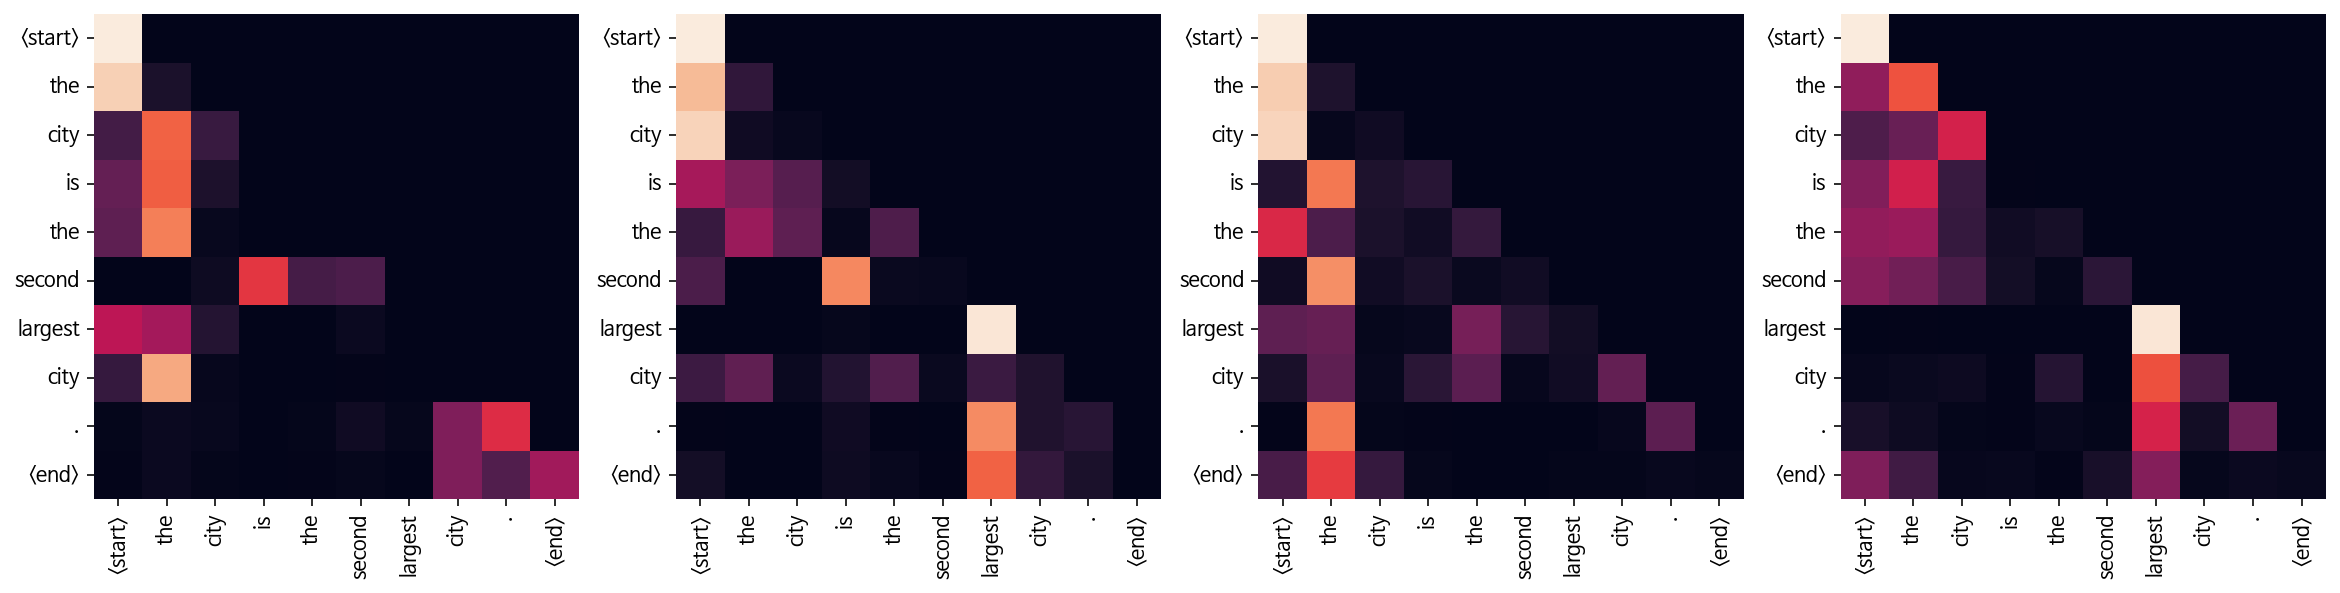

Decoder Src Layer 2


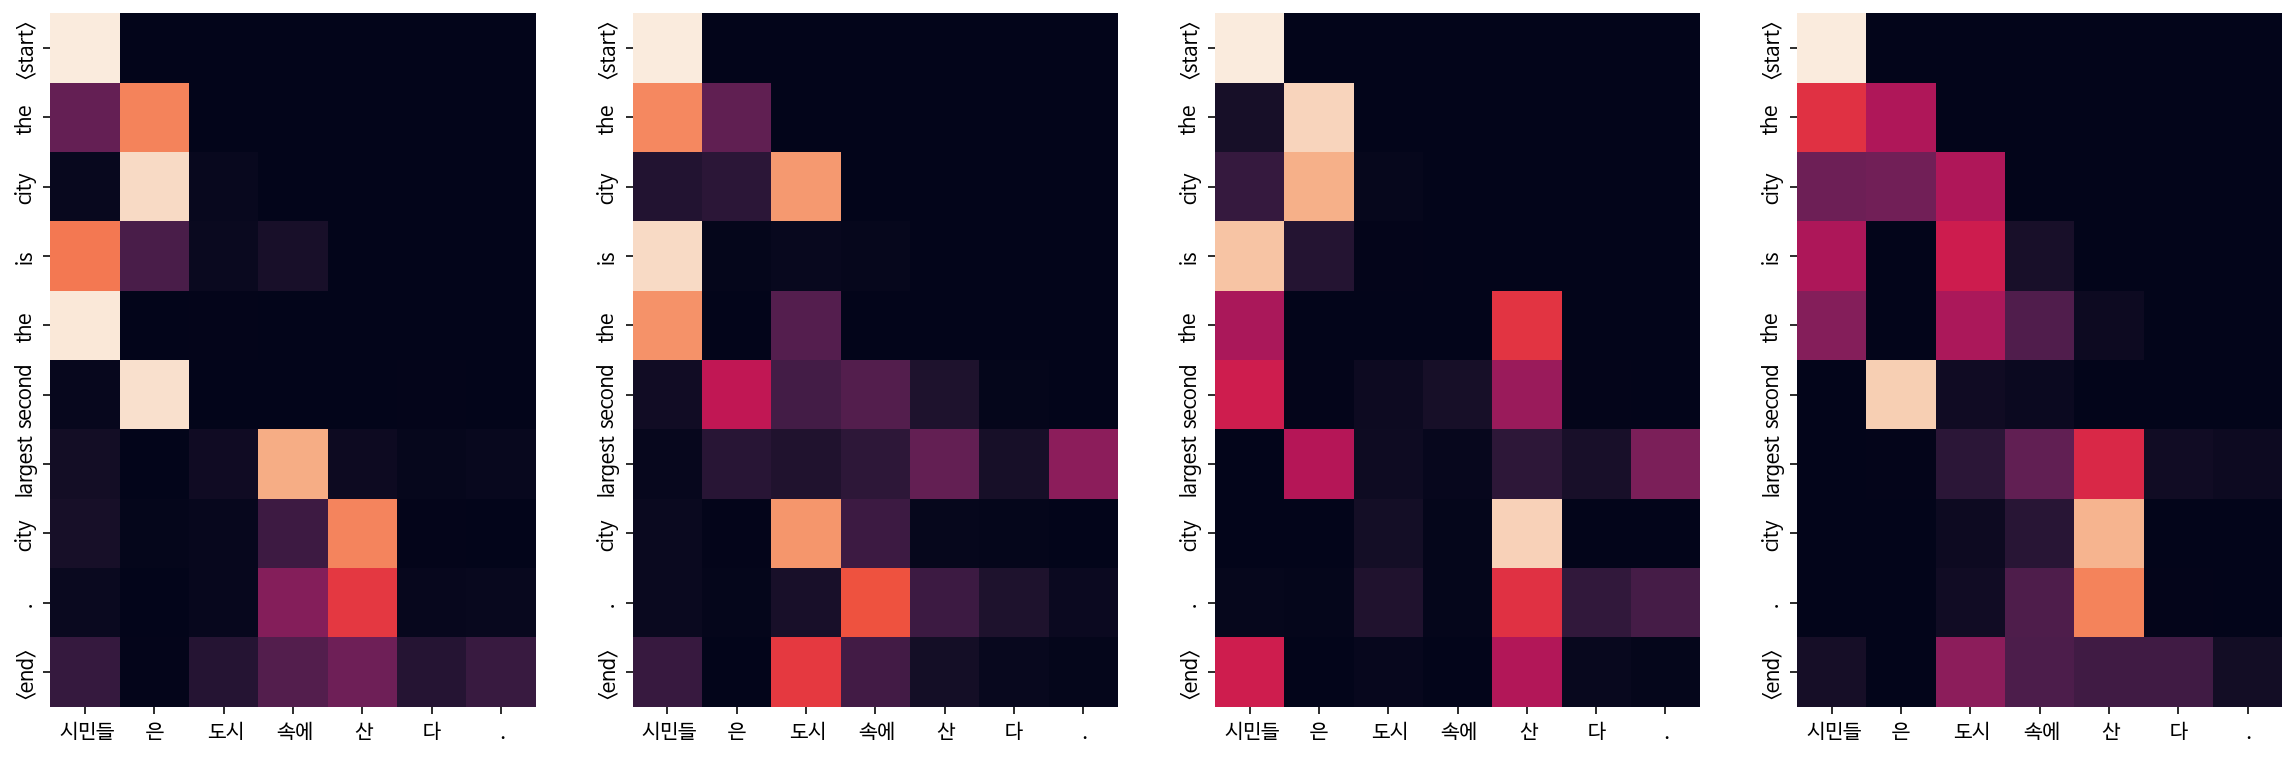

Input: 커피는 필요 없다.
Predicted translation: <start> coffee is not a coffee . <end>
Encoder Layer 1


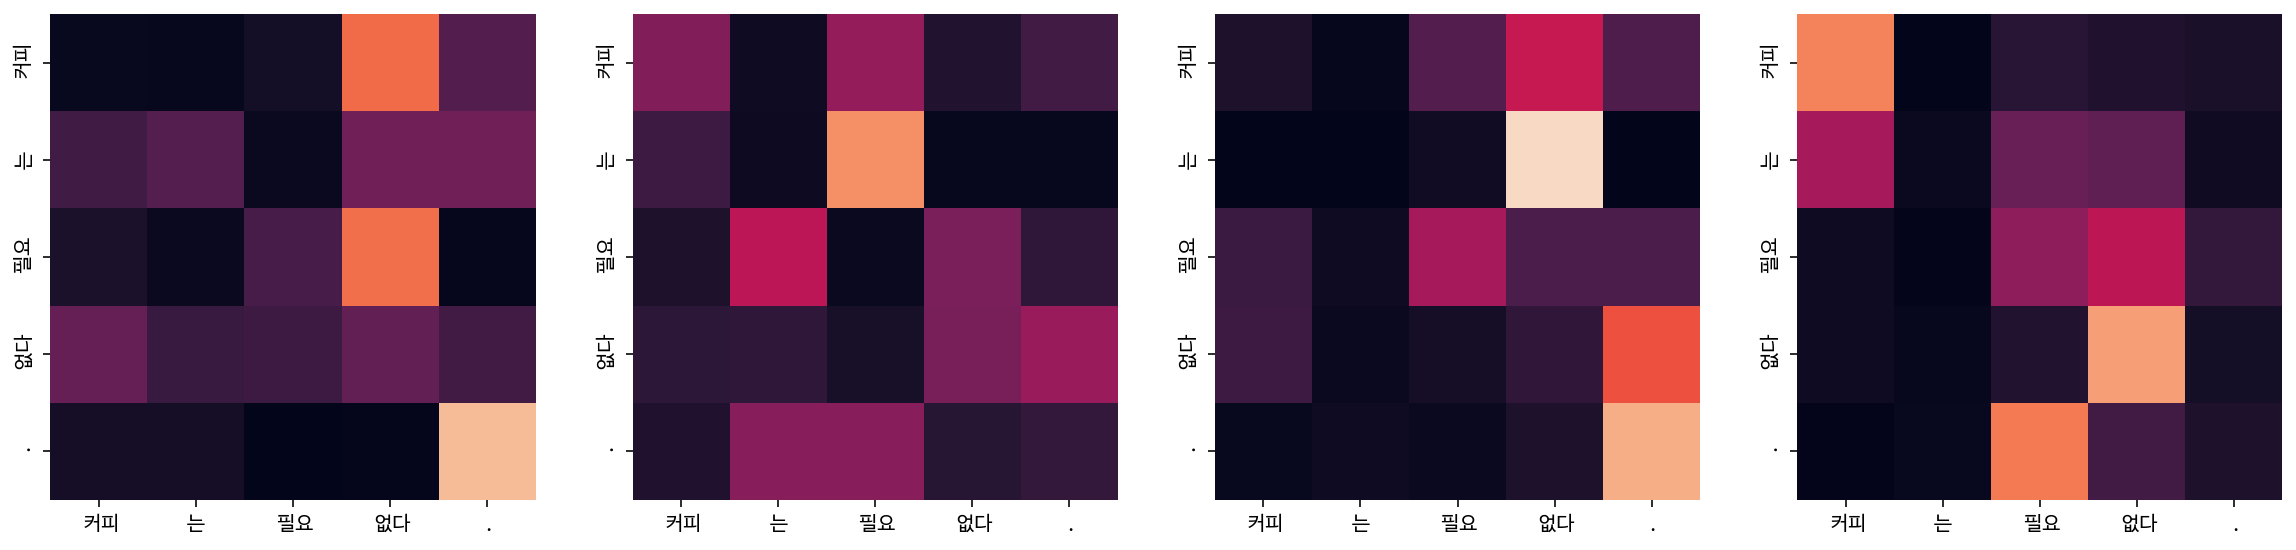

Encoder Layer 2


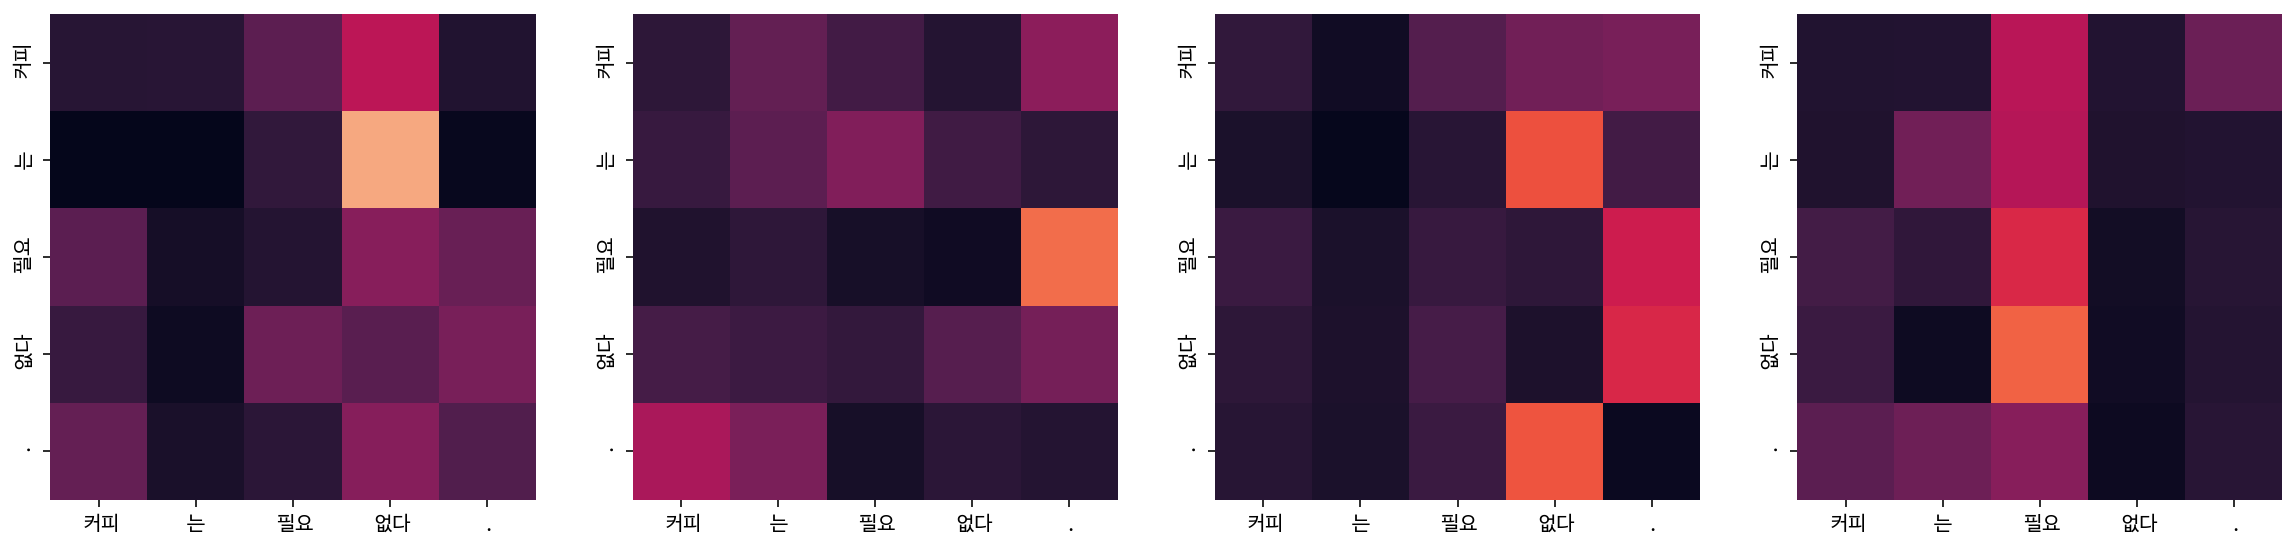

Decoder Self Layer 1


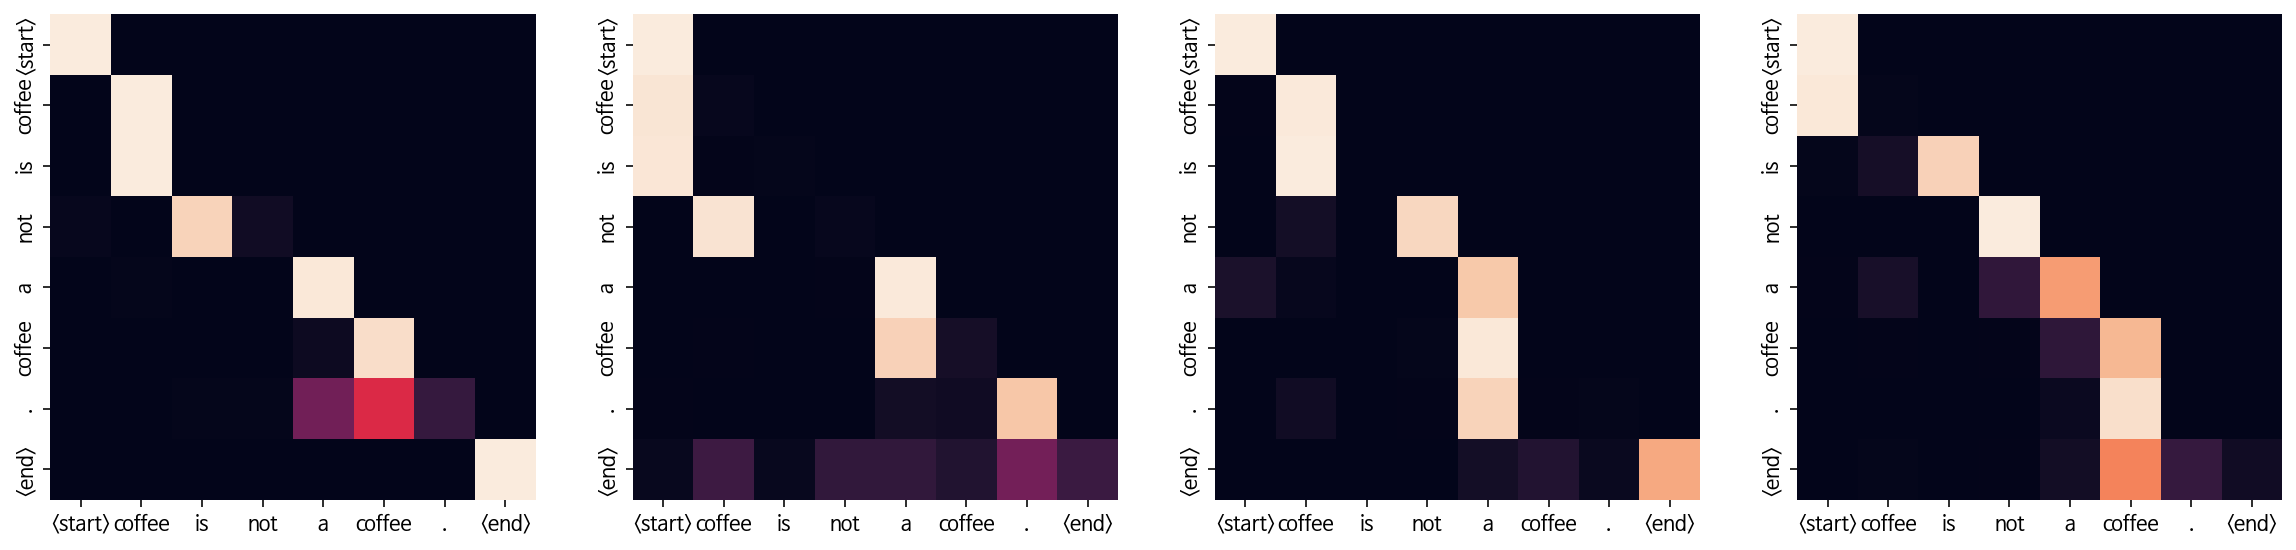

Decoder Src Layer 1


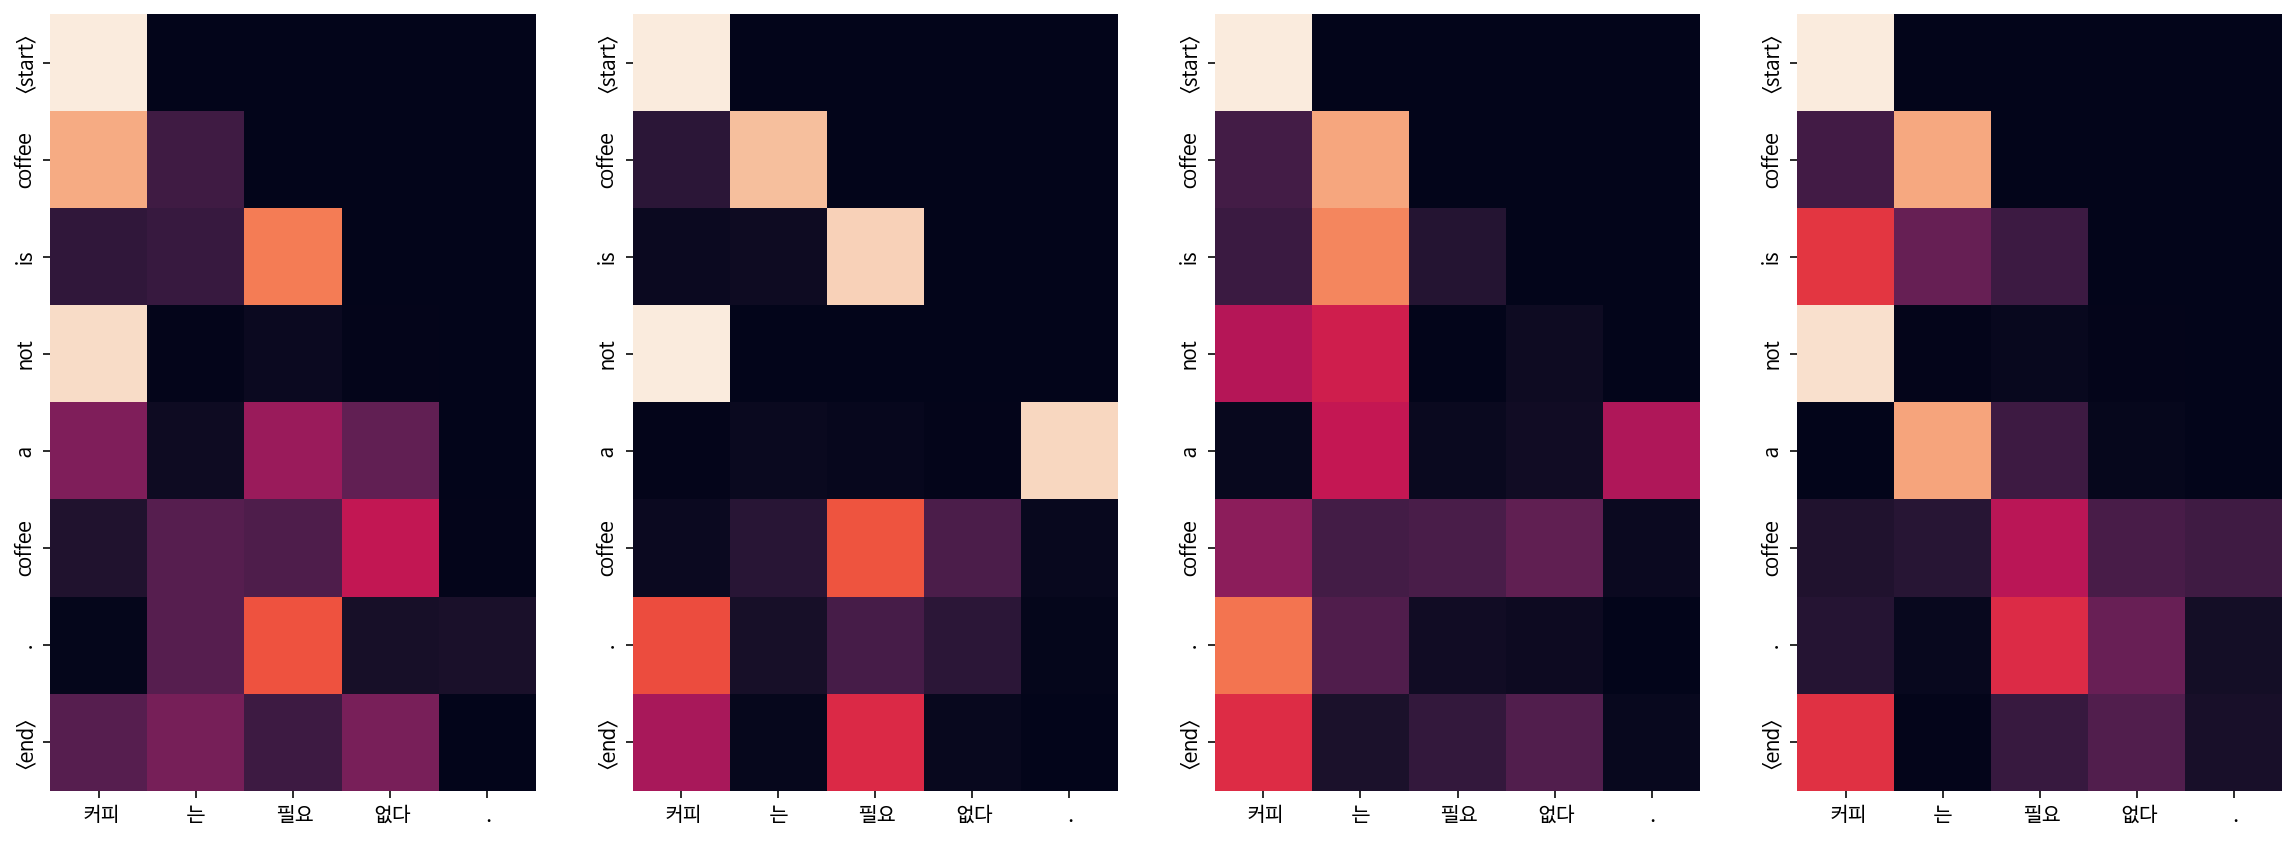

Decoder Self Layer 2


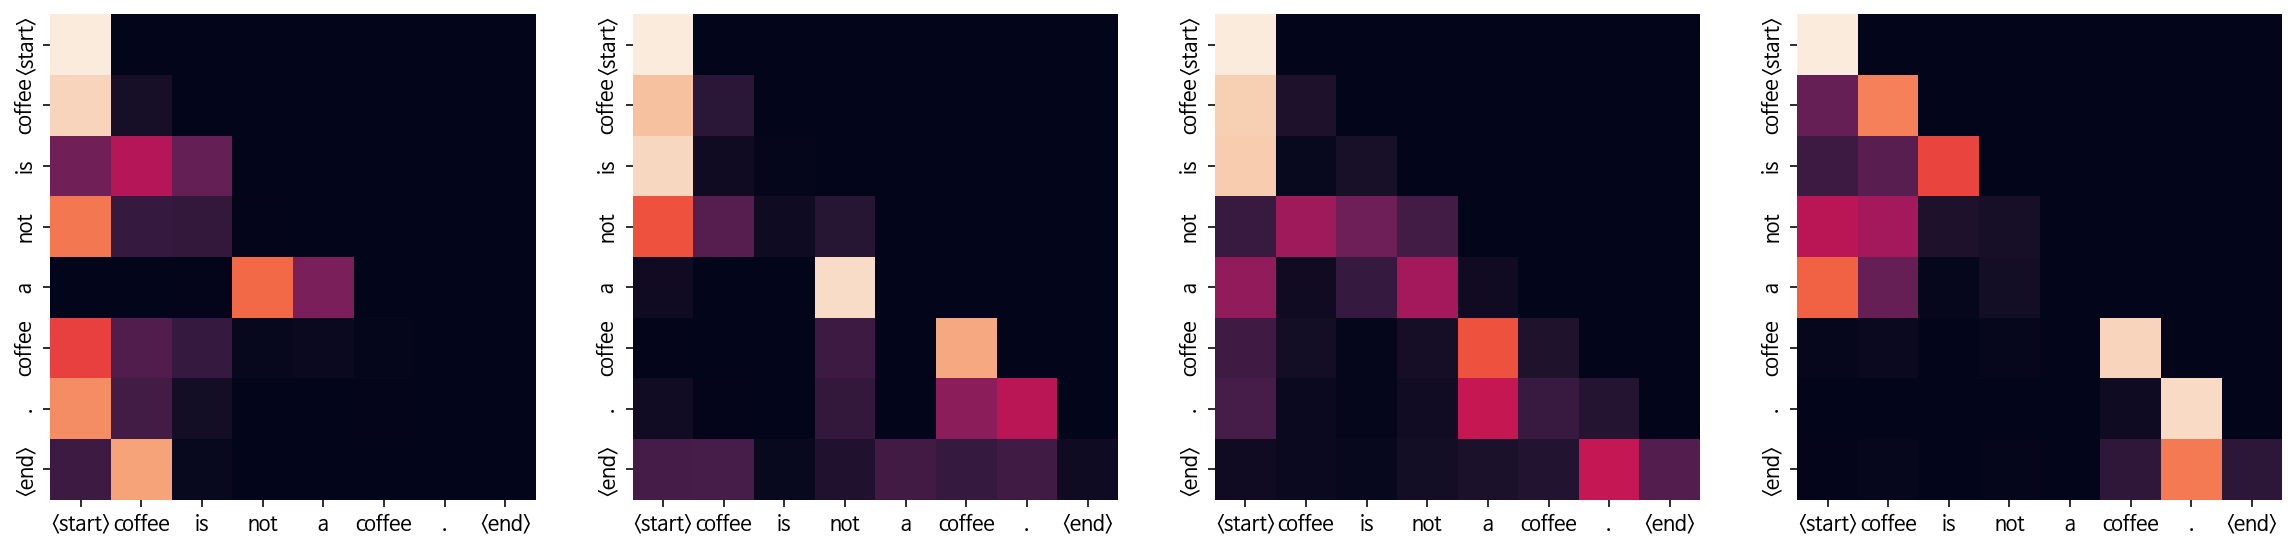

Decoder Src Layer 2


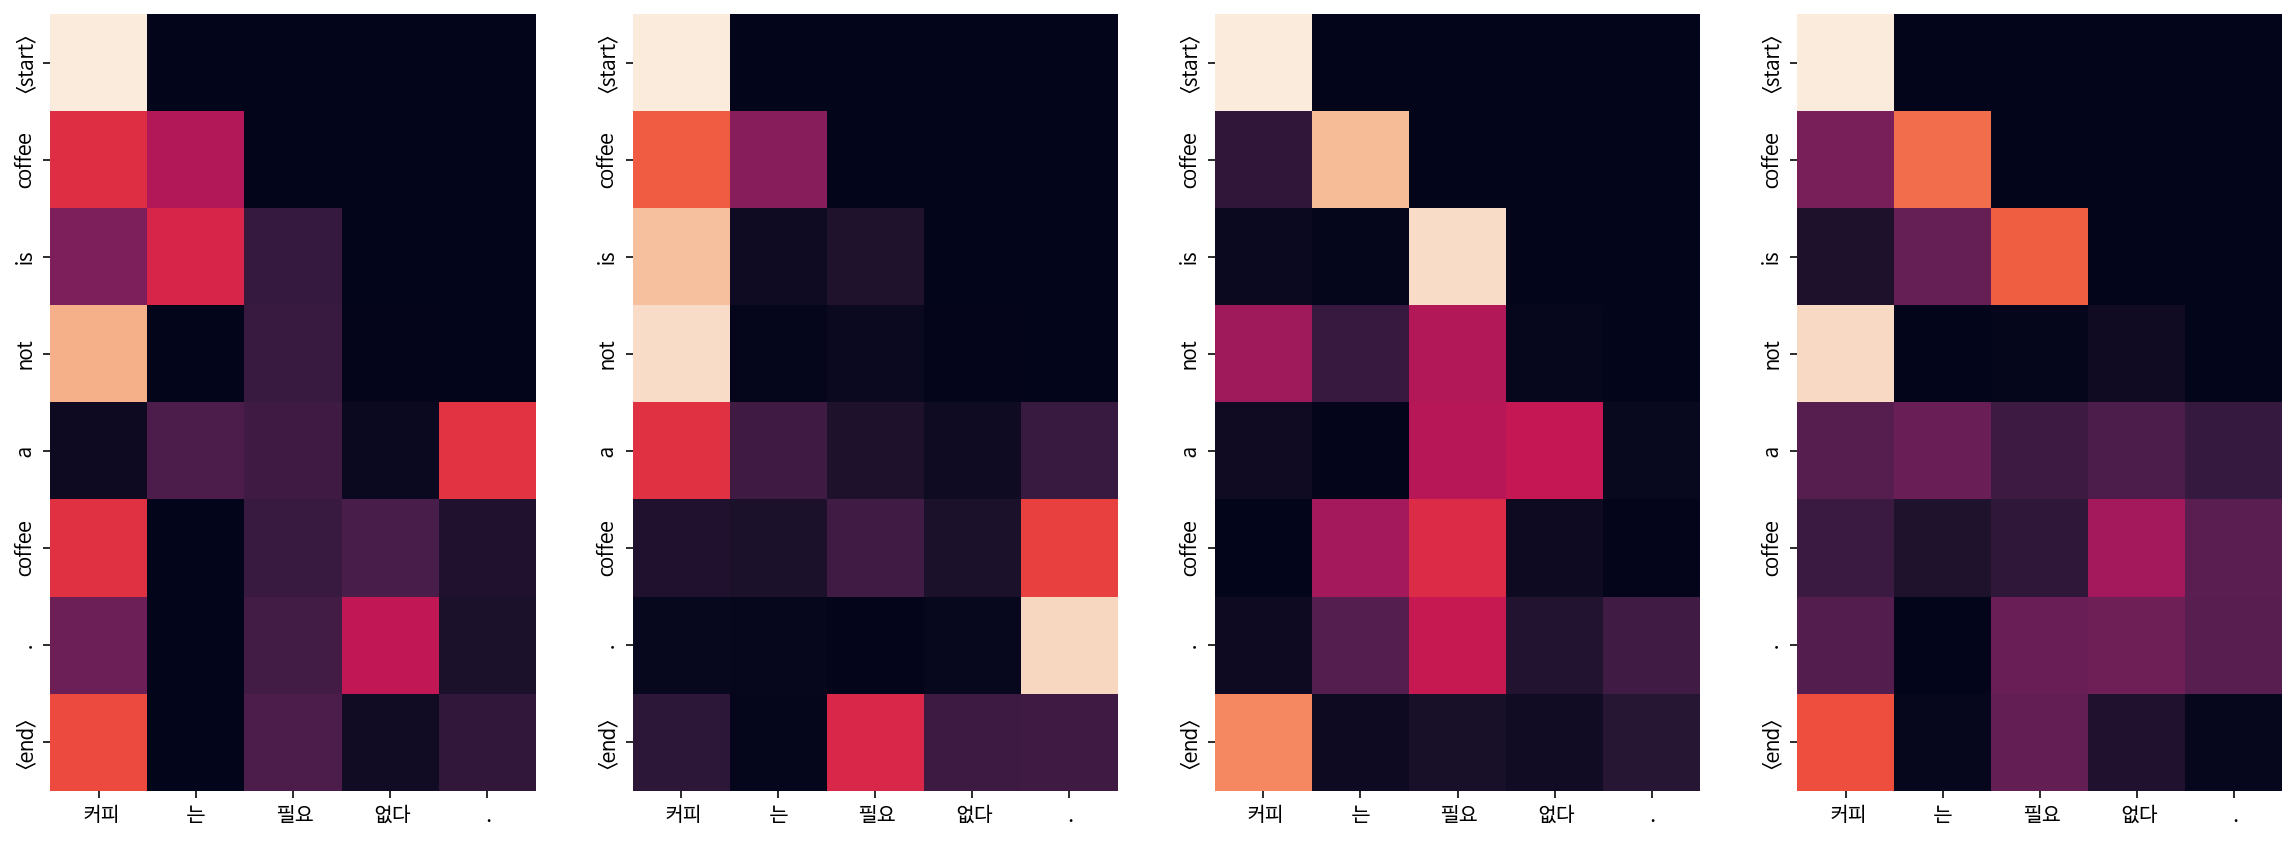

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <start> seven of the dead were among the dead . <end>
Encoder Layer 1


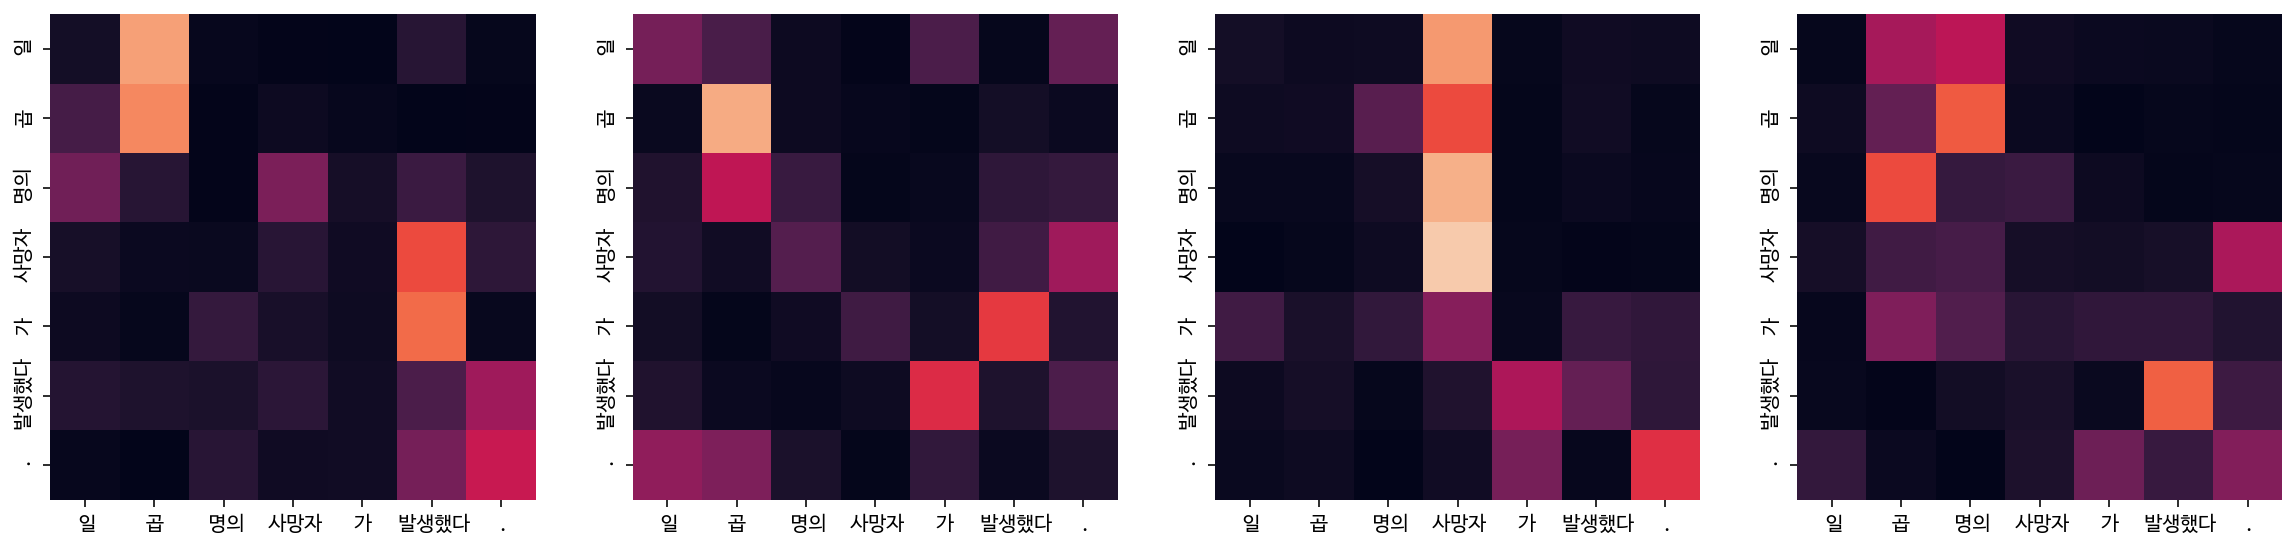

Encoder Layer 2


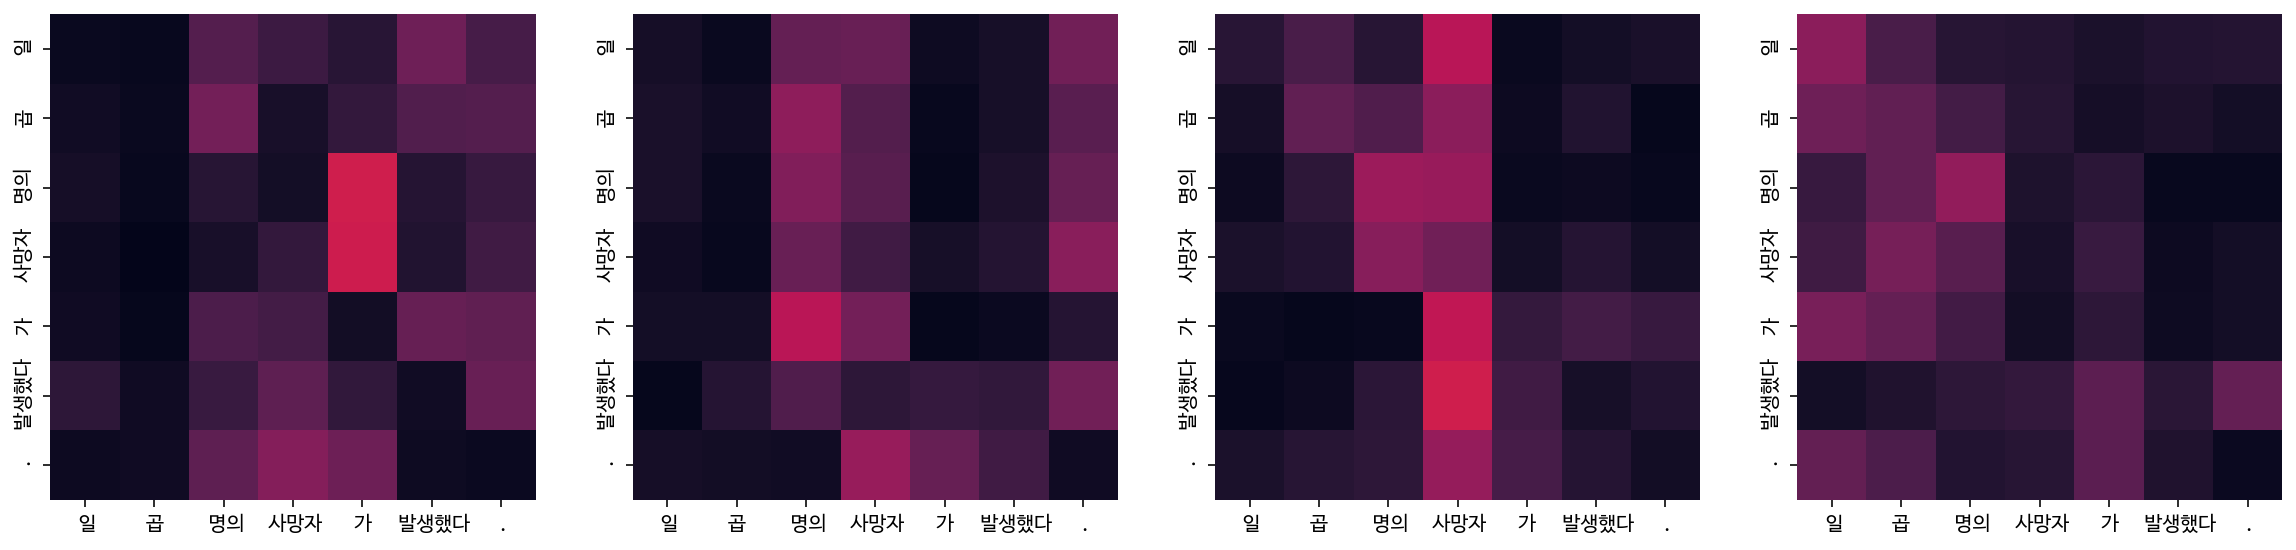

Decoder Self Layer 1


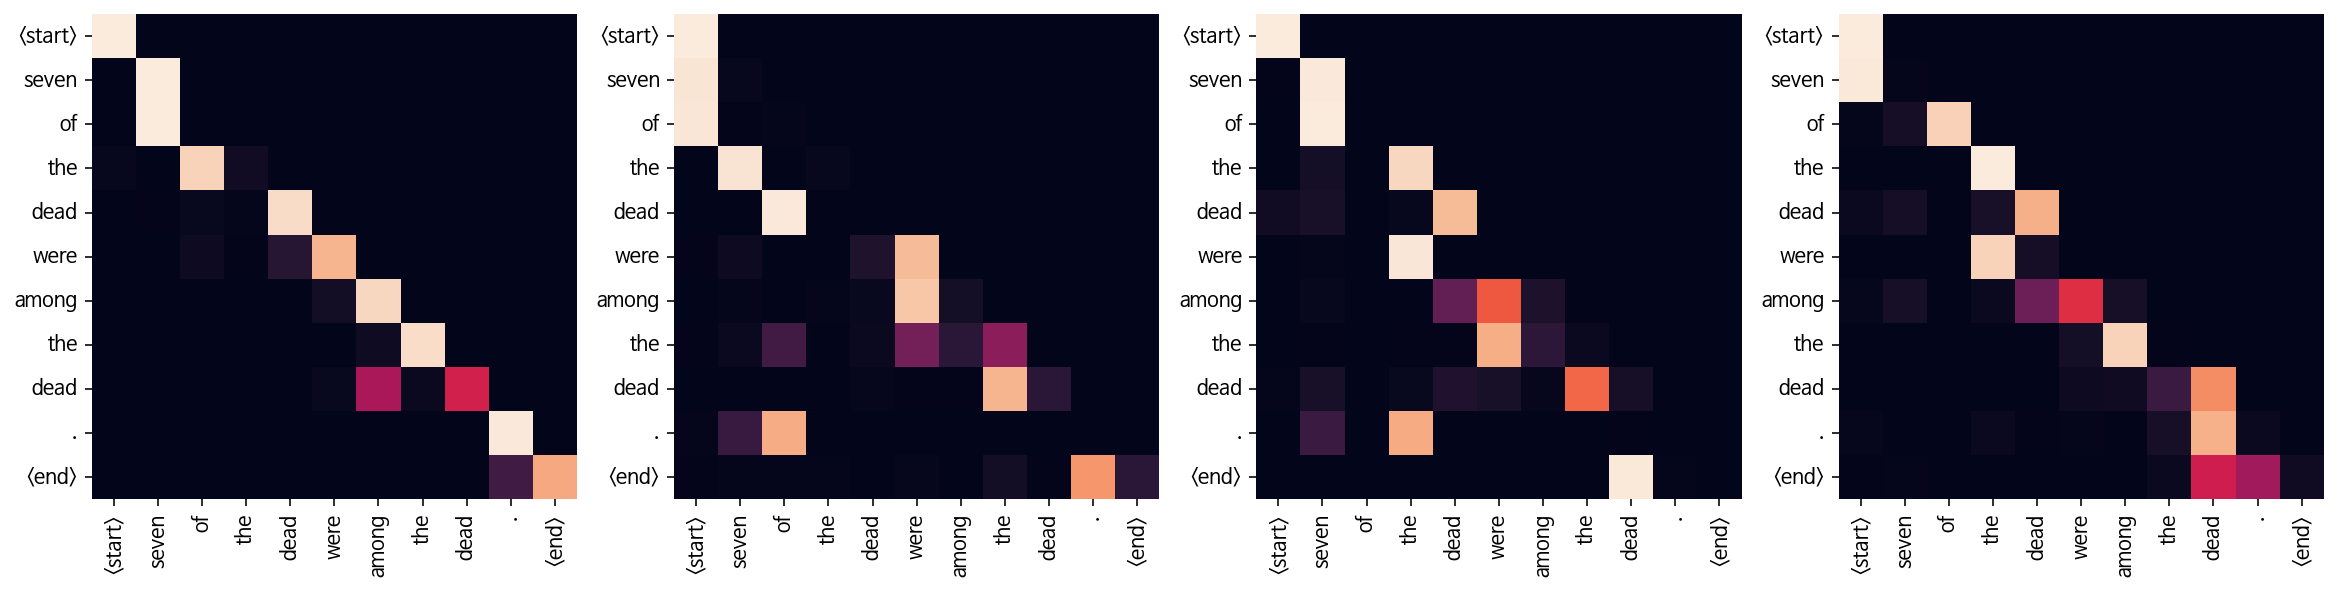

Decoder Src Layer 1


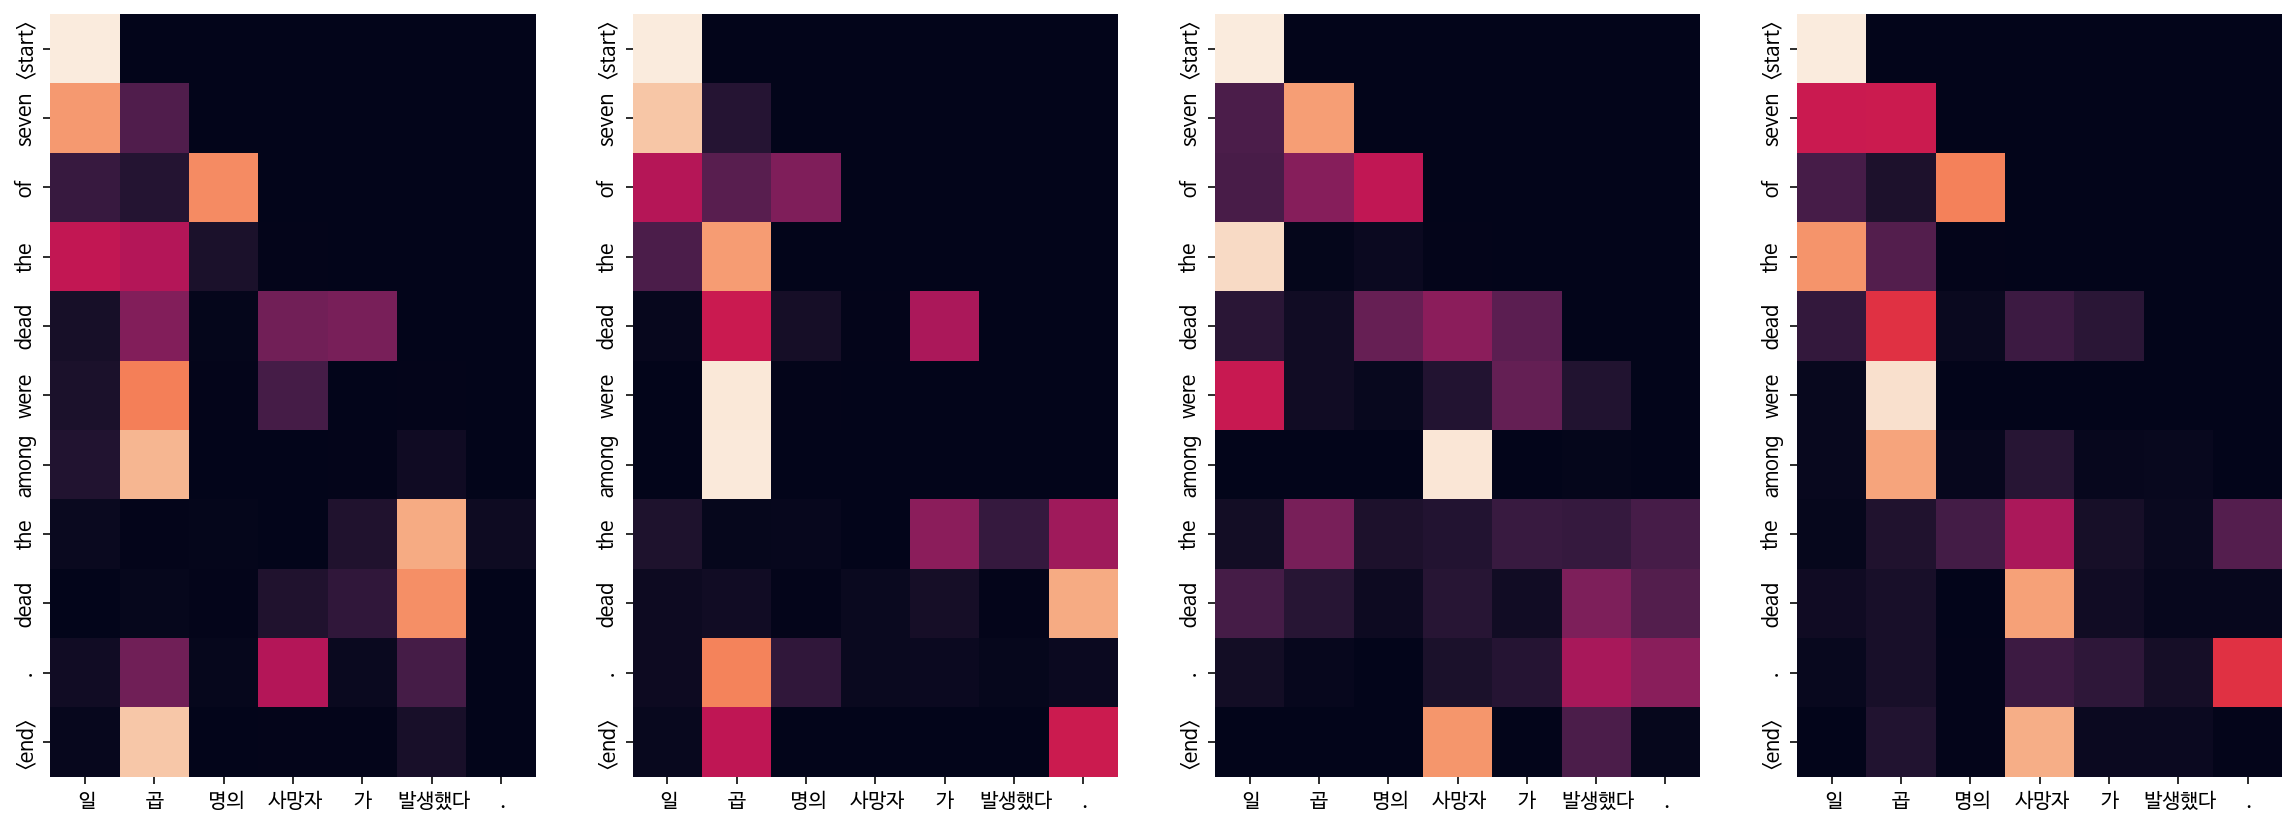

Decoder Self Layer 2


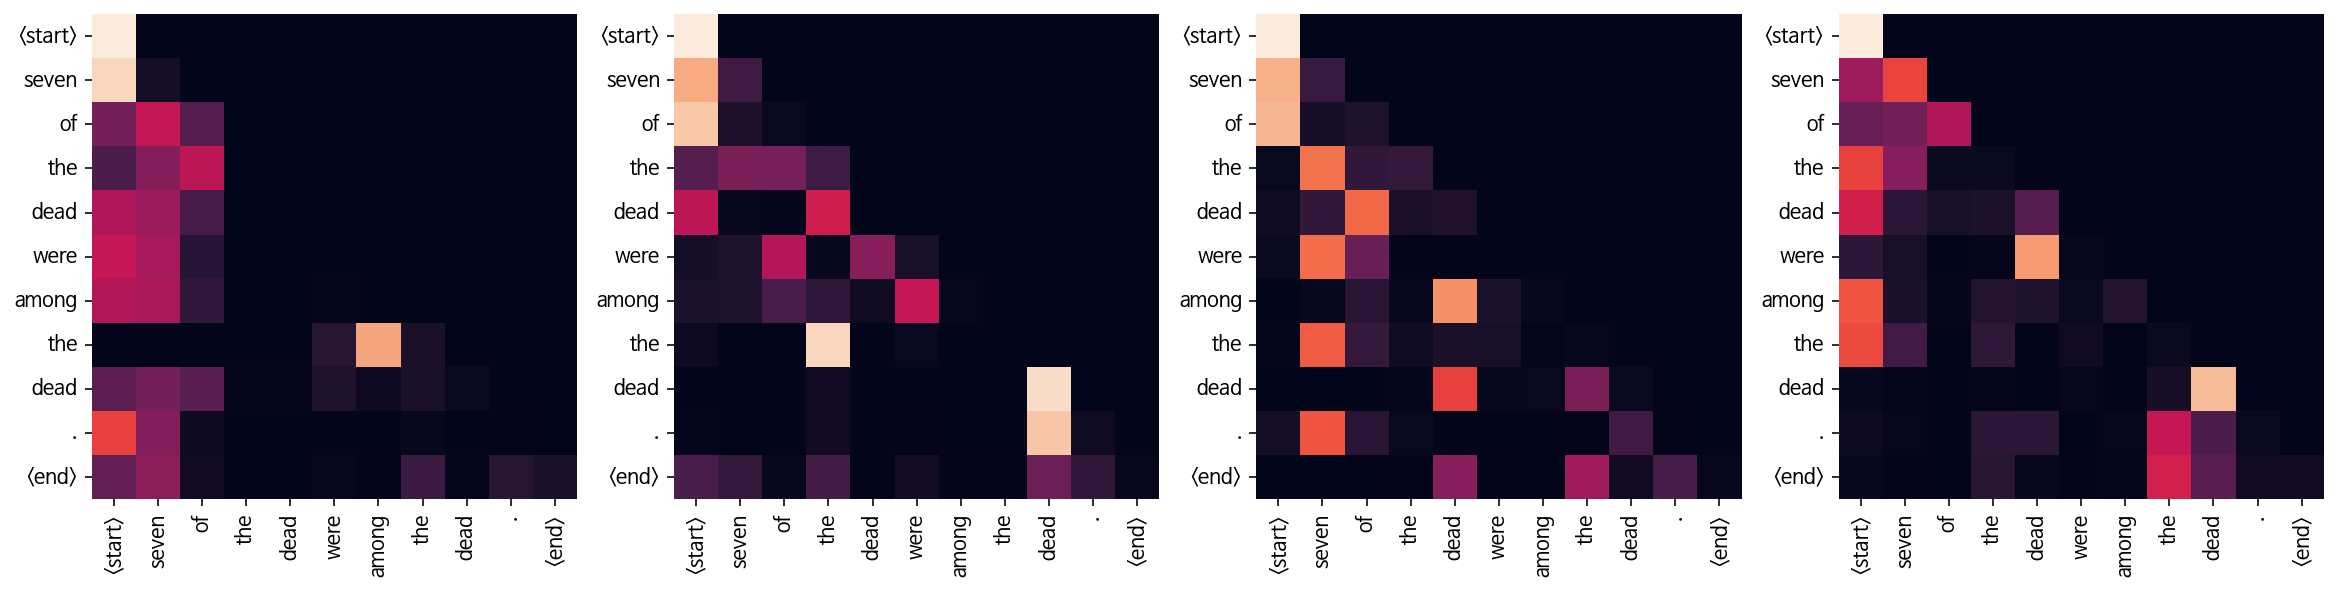

Decoder Src Layer 2


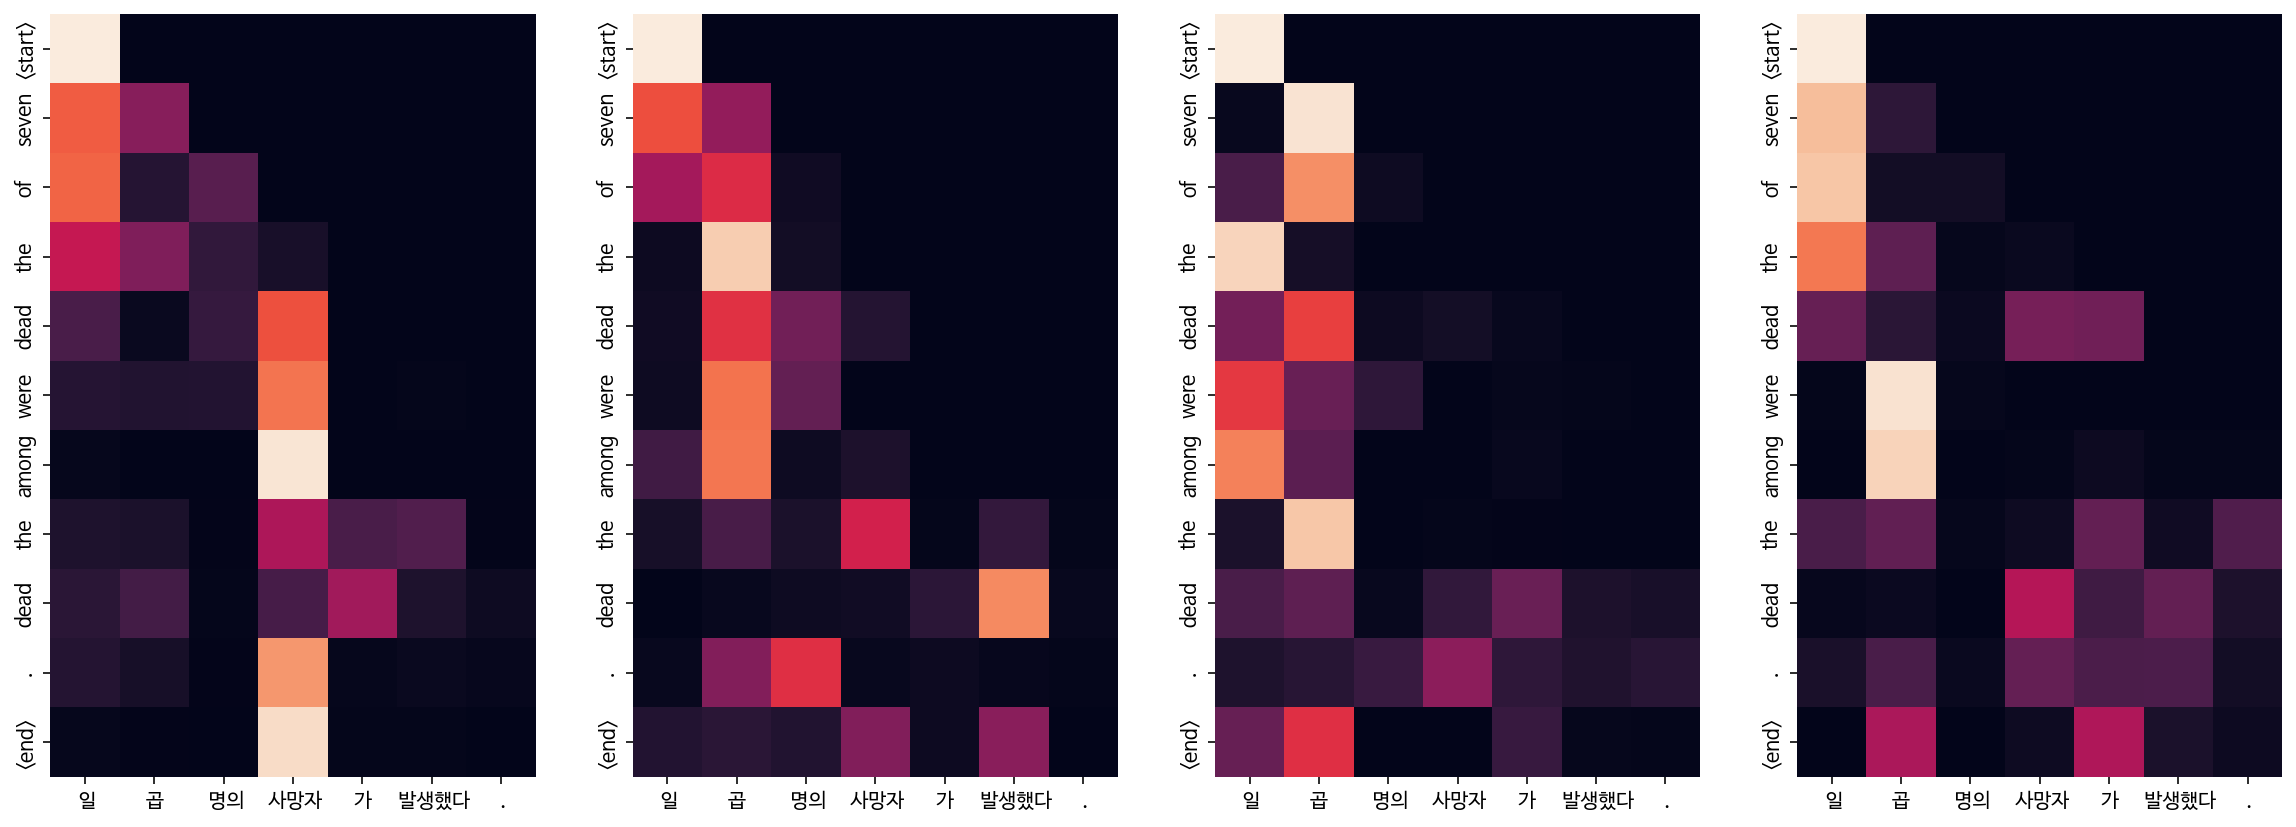

  0%|          | 0/3683 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: <start> obama . <end>
Encoder Layer 1


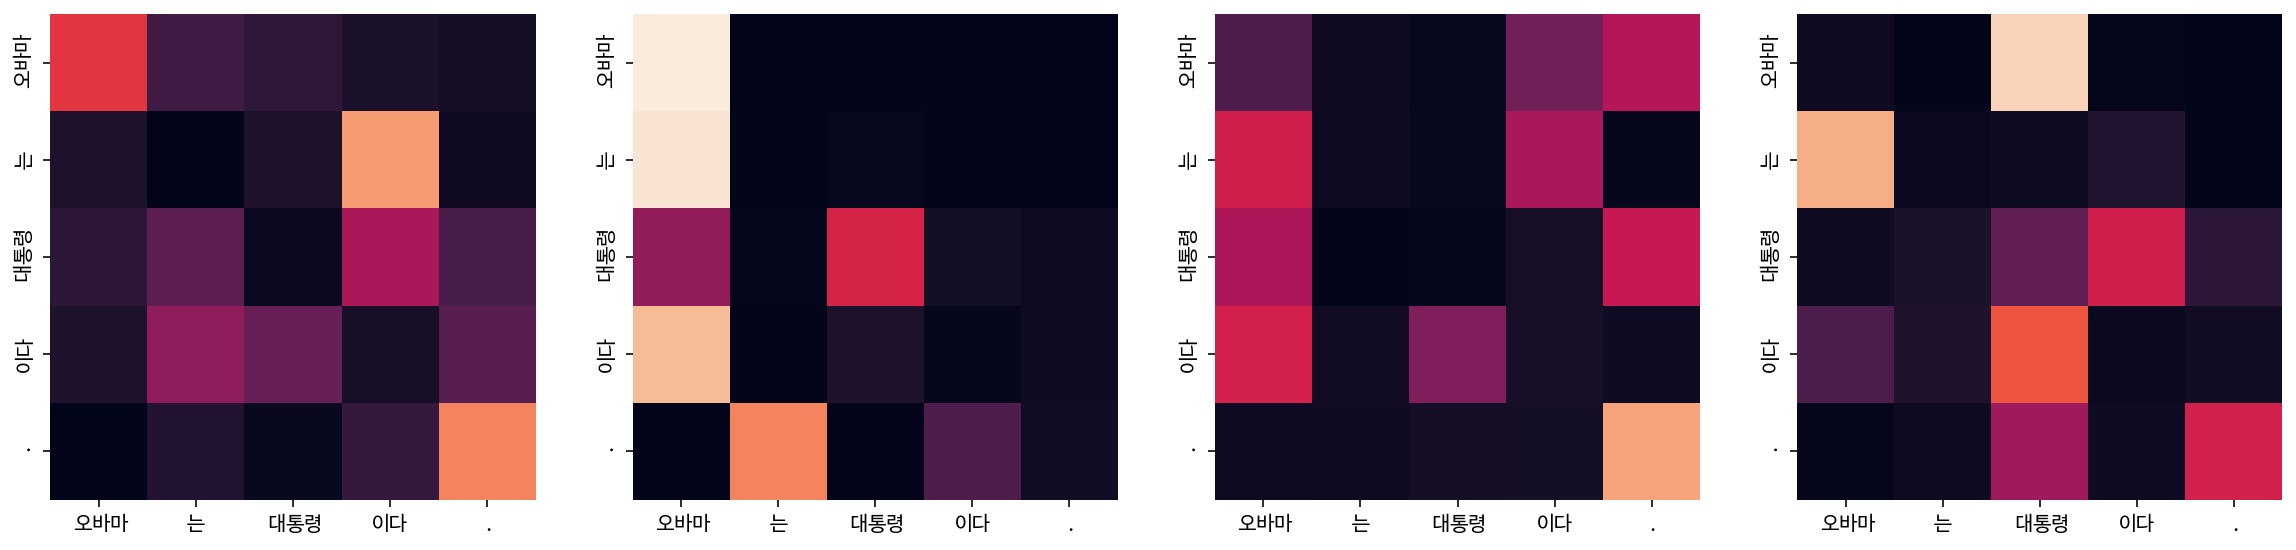

Encoder Layer 2


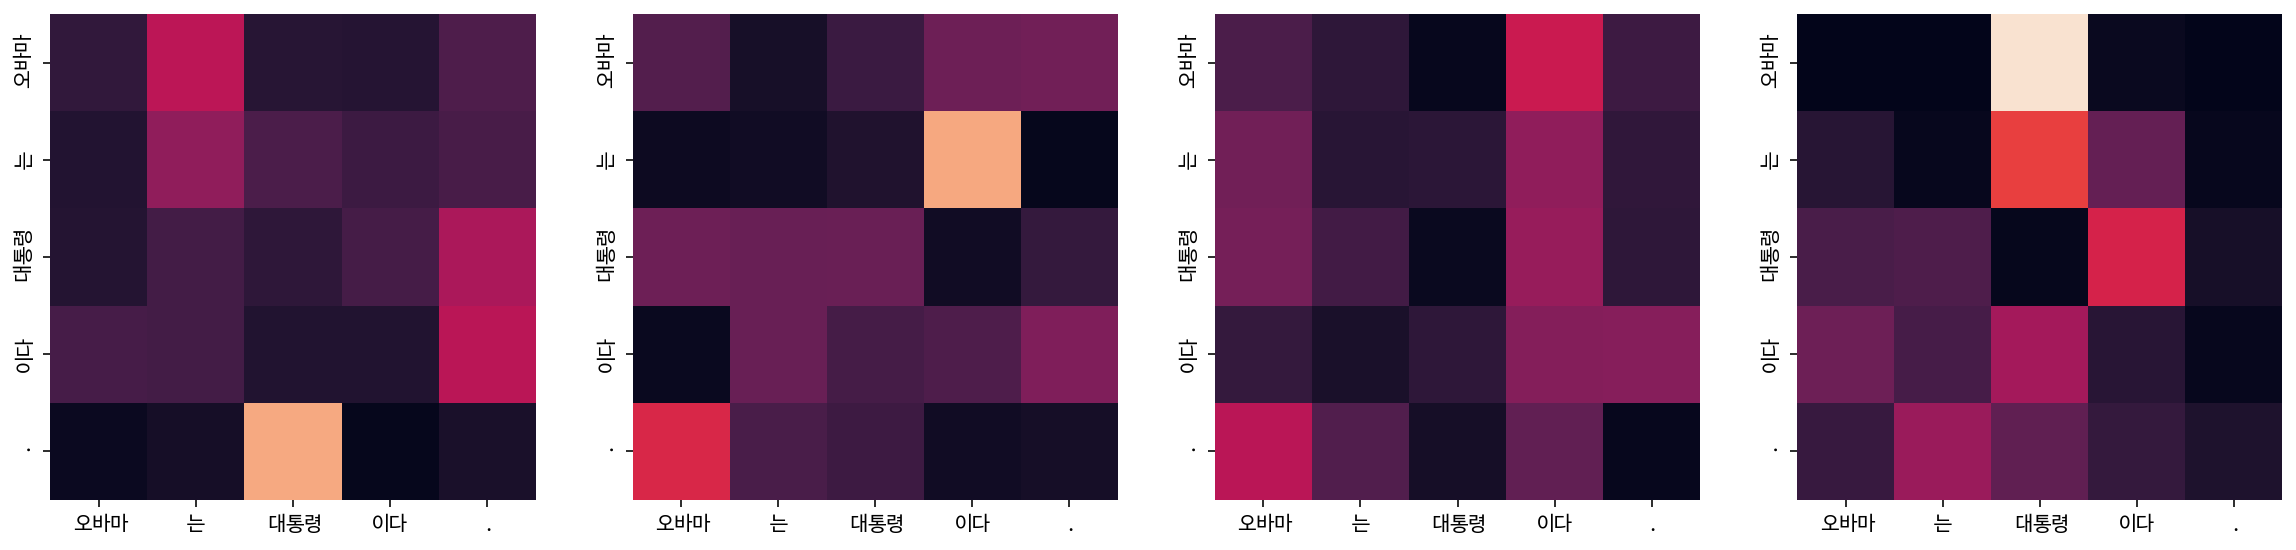

Decoder Self Layer 1


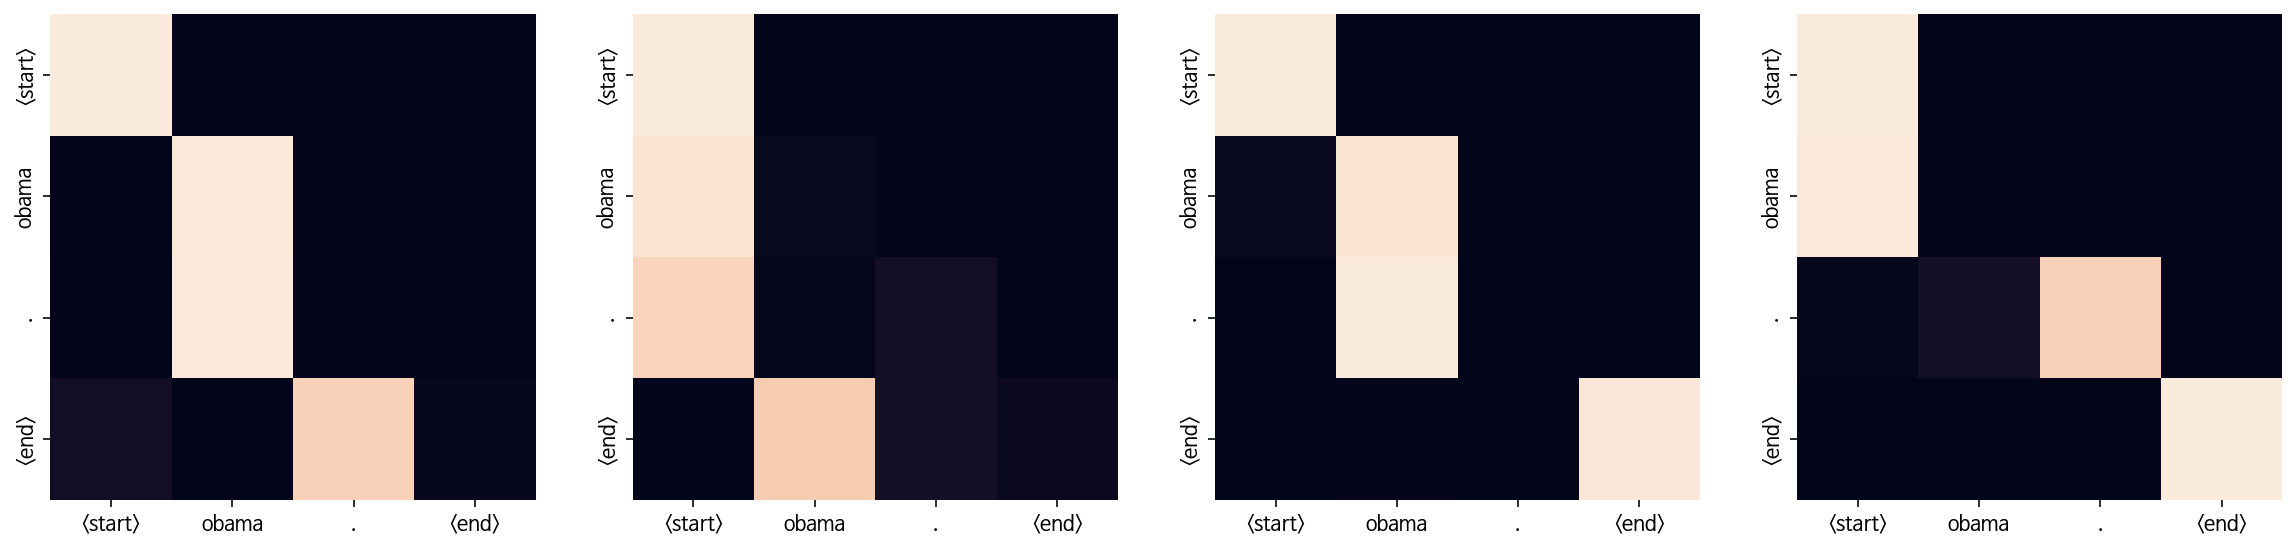

Decoder Src Layer 1


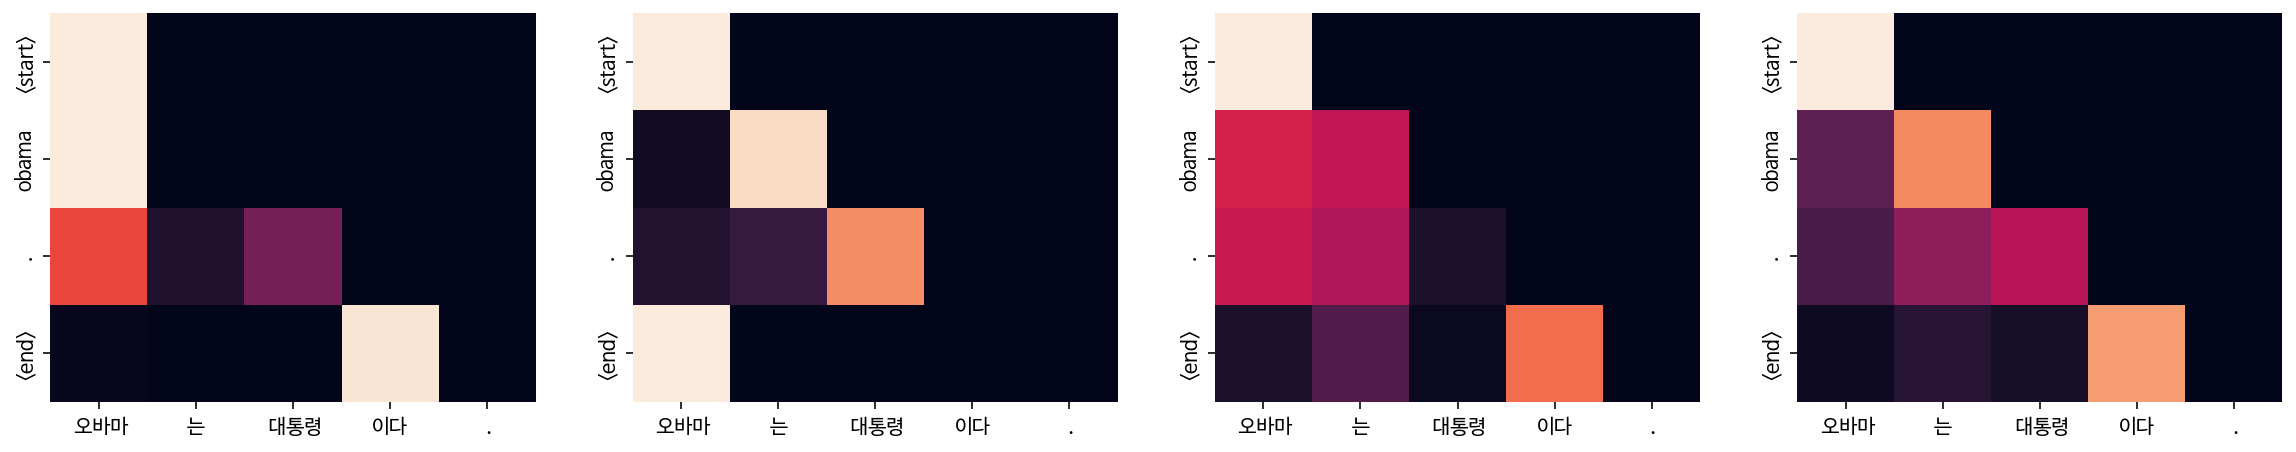

Decoder Self Layer 2


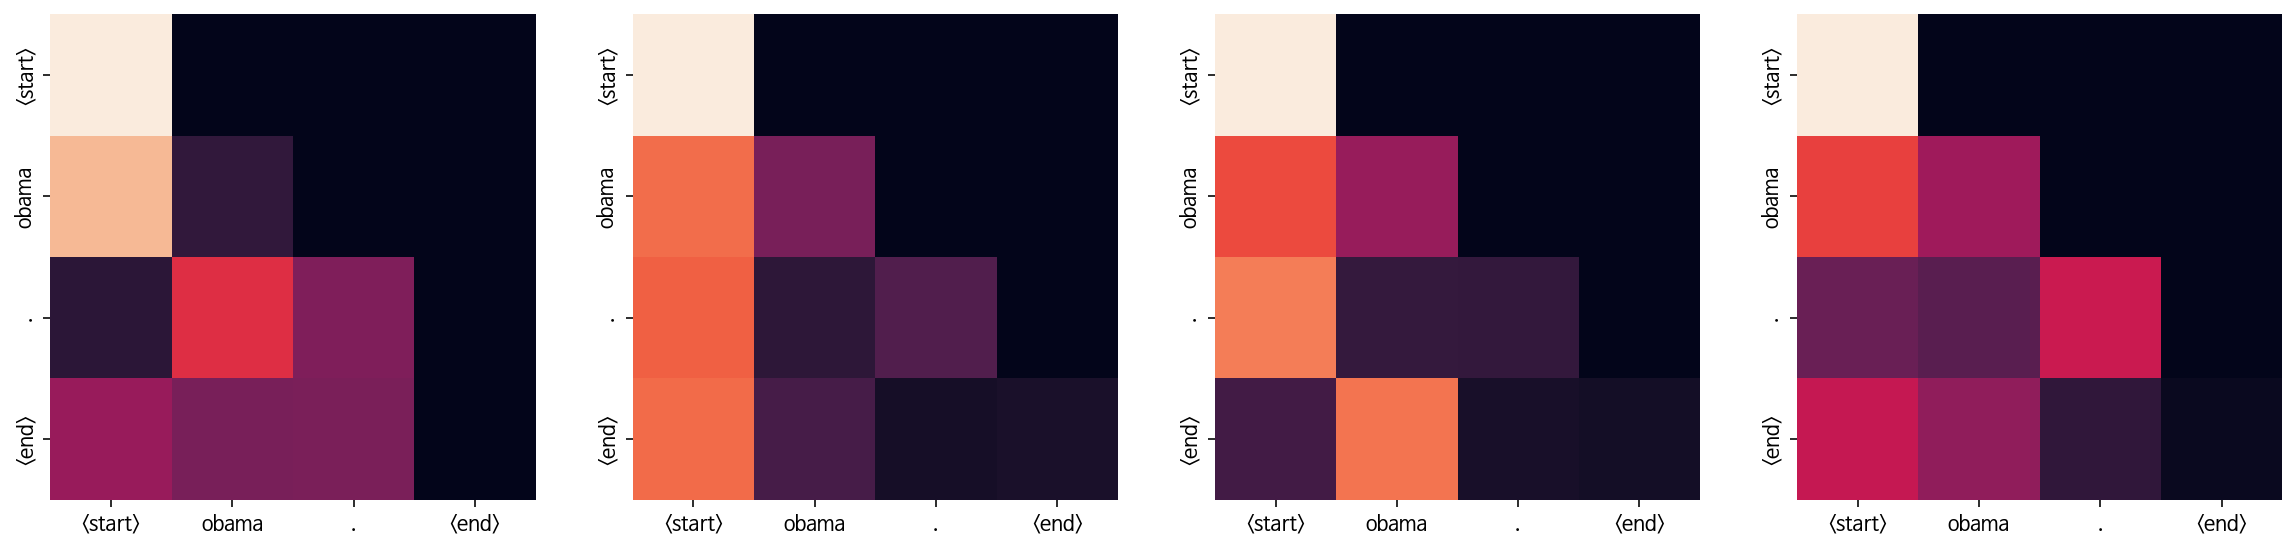

Decoder Src Layer 2


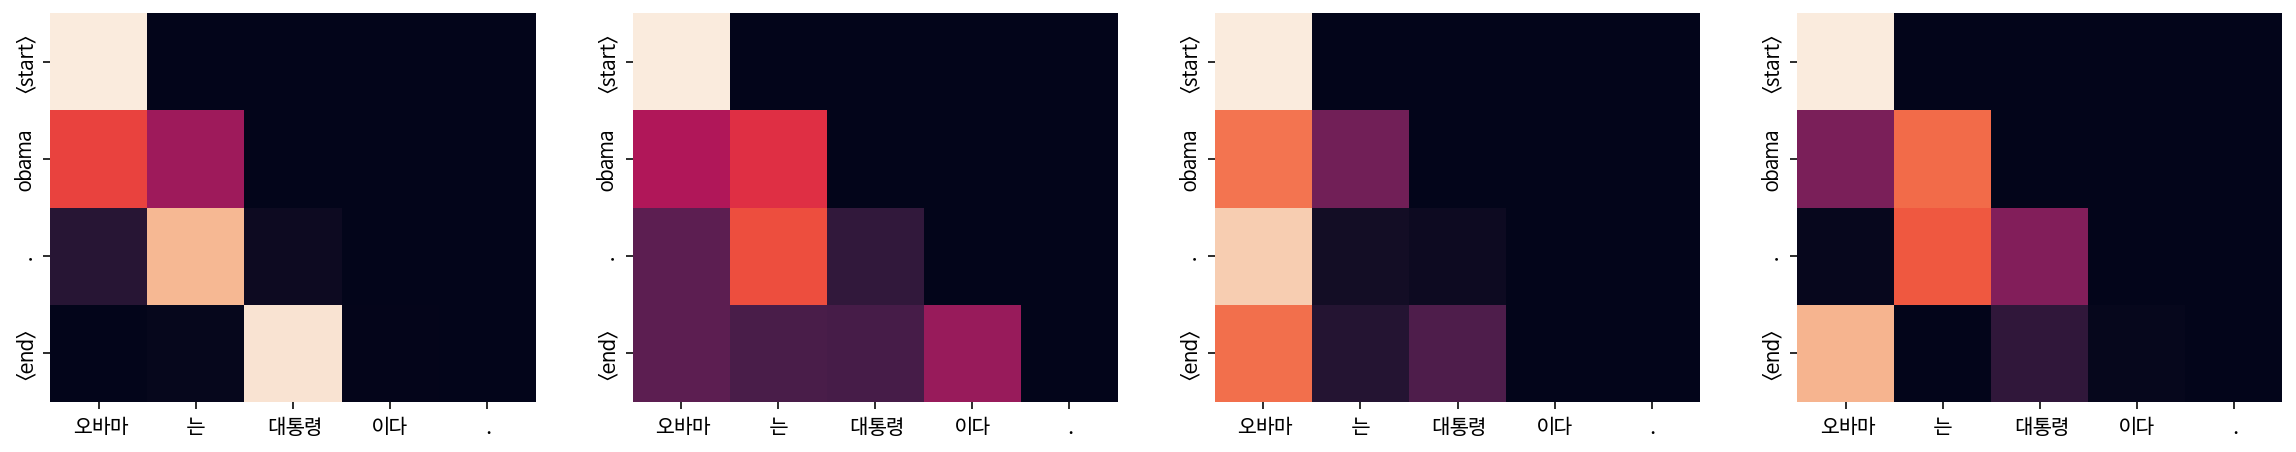

Input: 시민들은 도시 속에 산다.
Predicted translation: <start> the city s . <end>
Encoder Layer 1


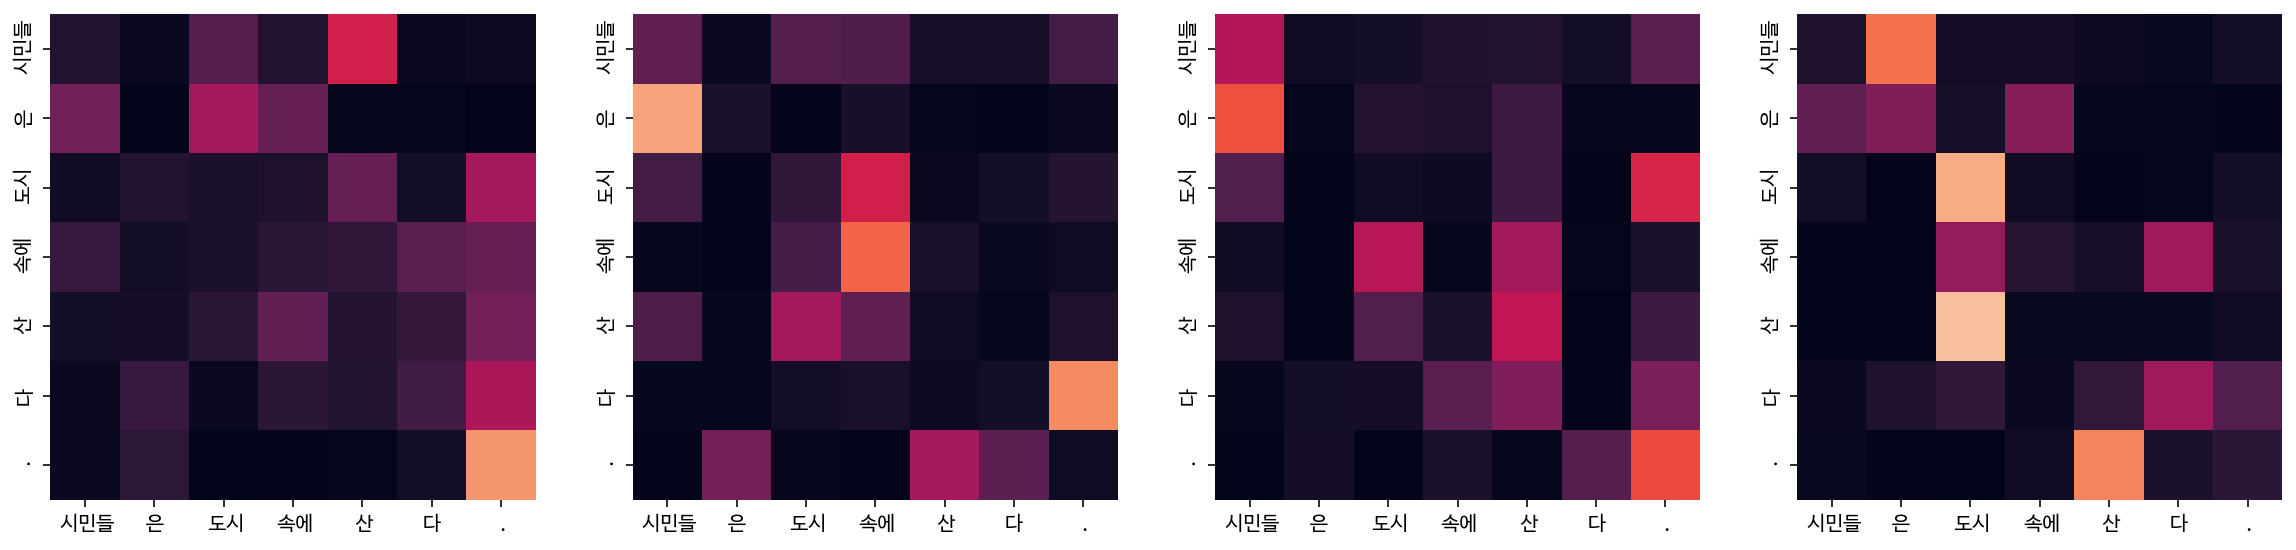

Encoder Layer 2


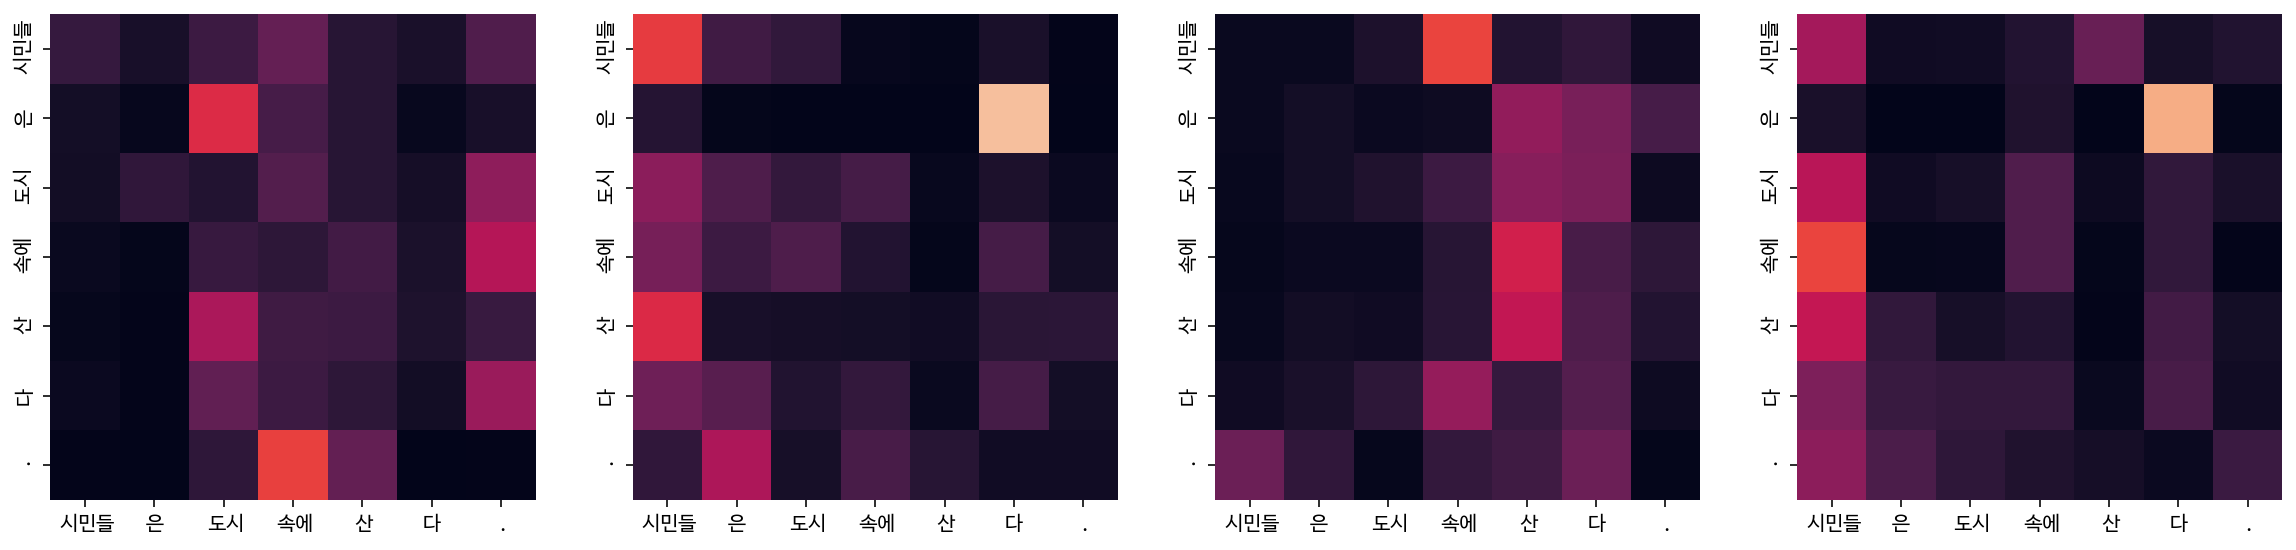

Decoder Self Layer 1


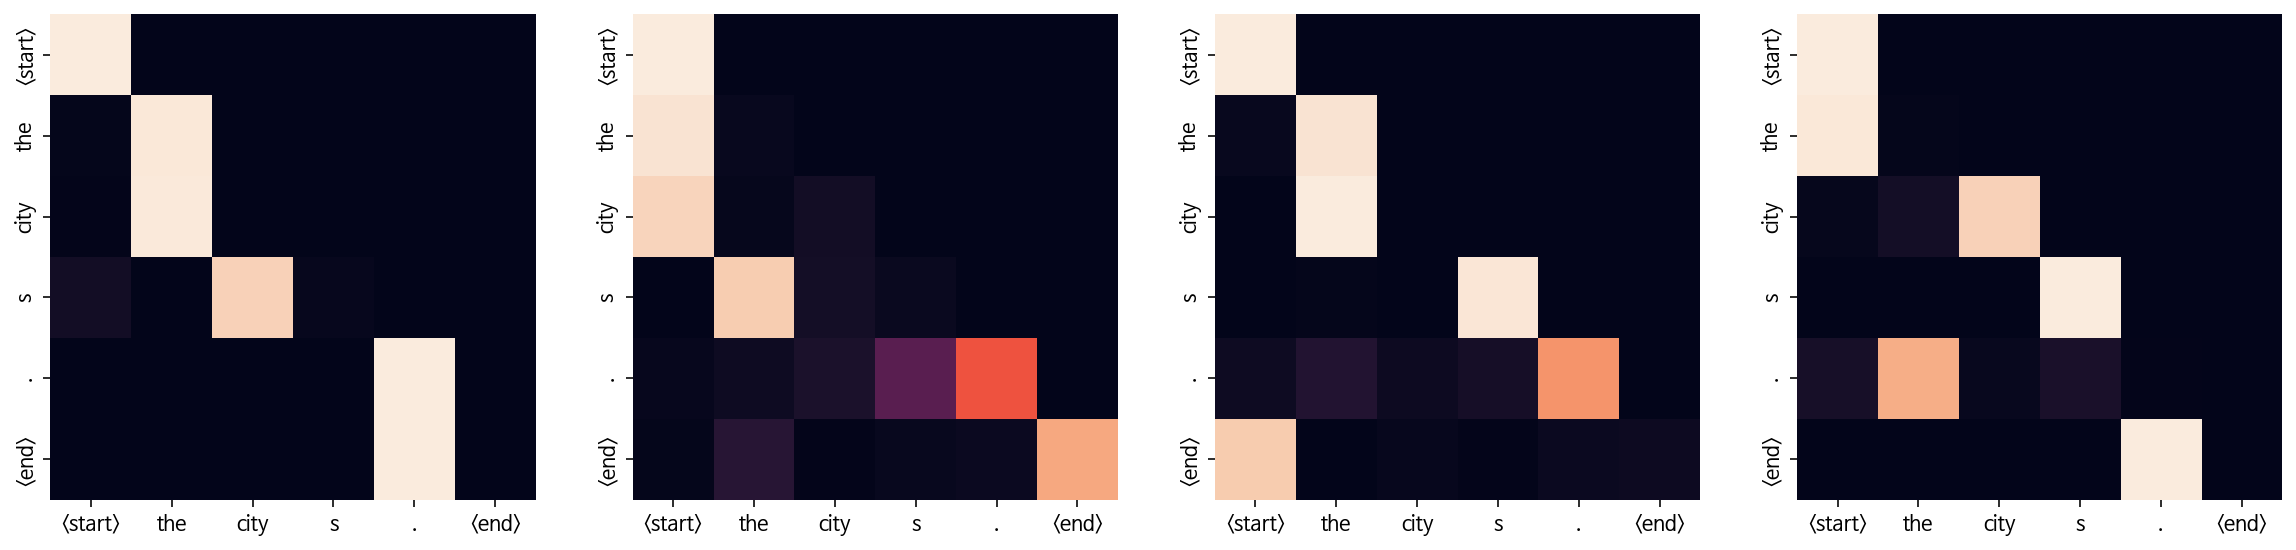

Decoder Src Layer 1


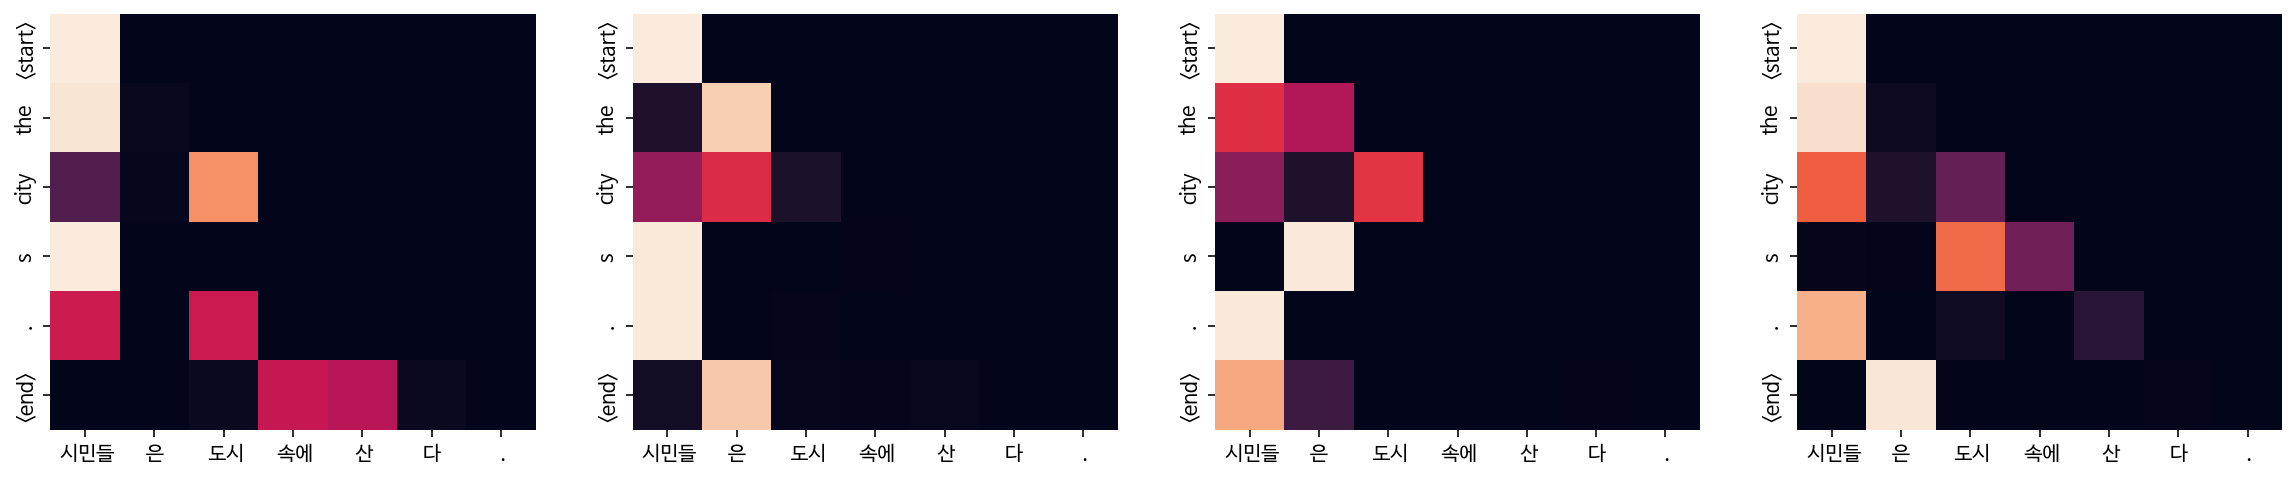

Decoder Self Layer 2


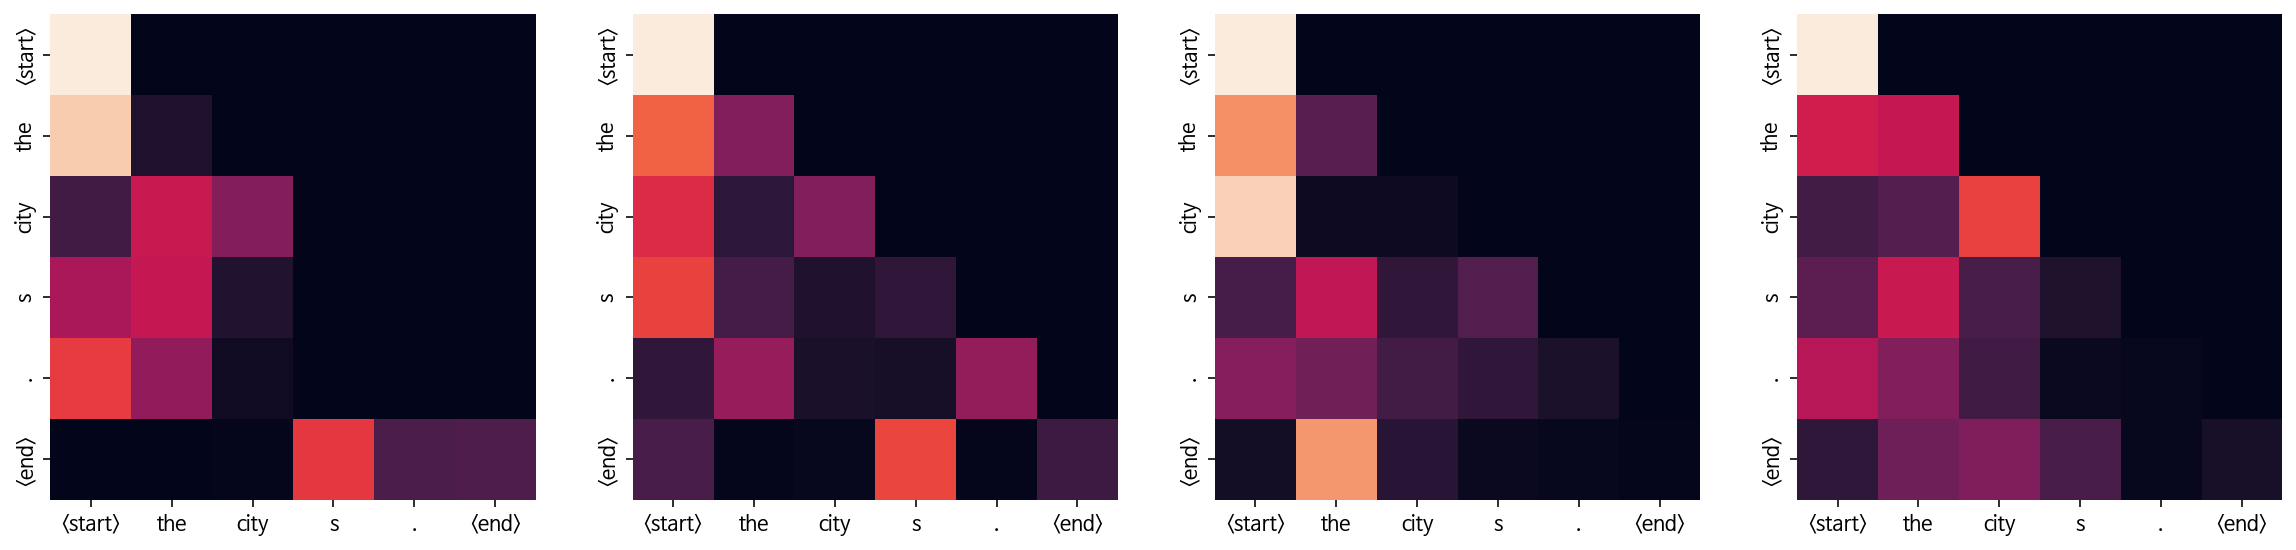

Decoder Src Layer 2


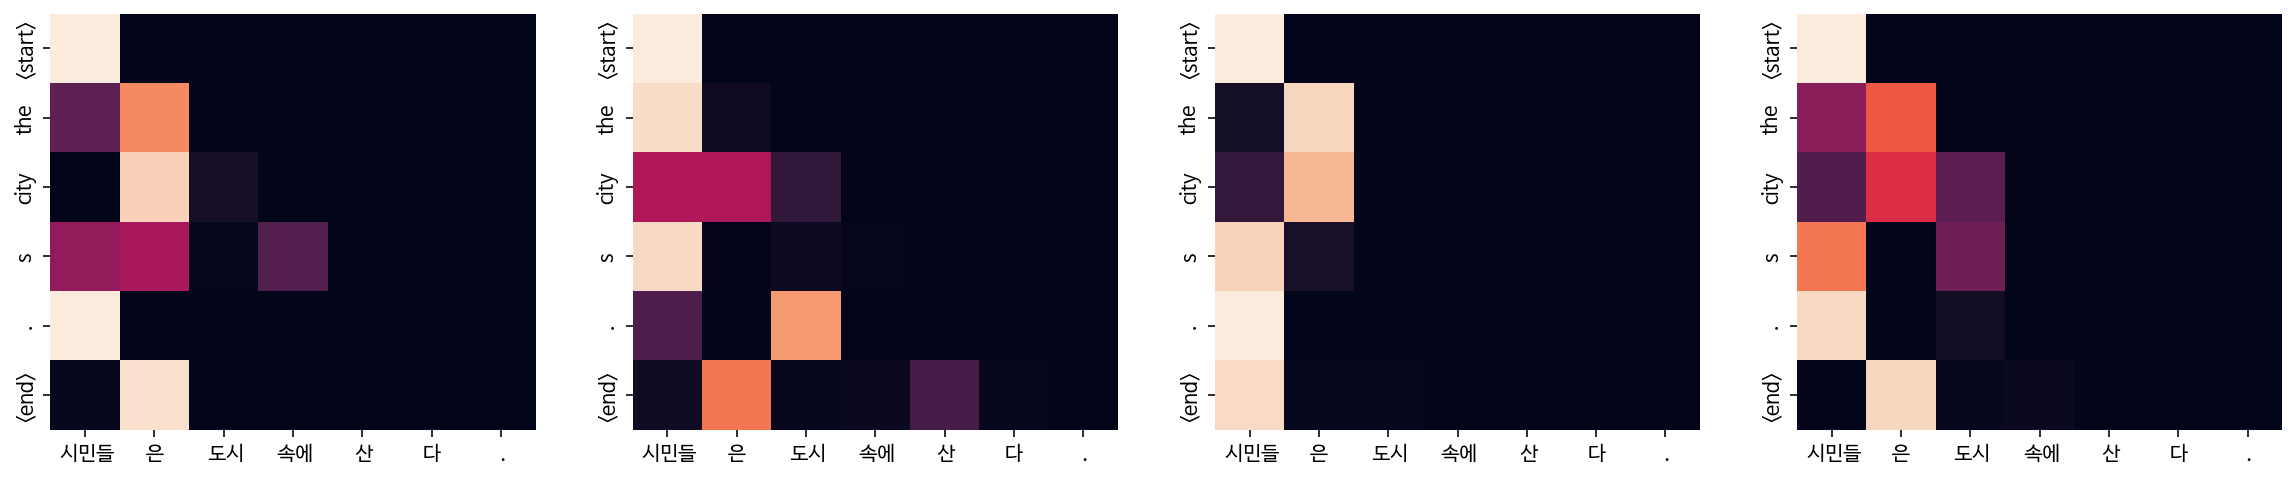

Input: 커피는 필요 없다.
Predicted translation: <start> coffee is needed . <end>
Encoder Layer 1


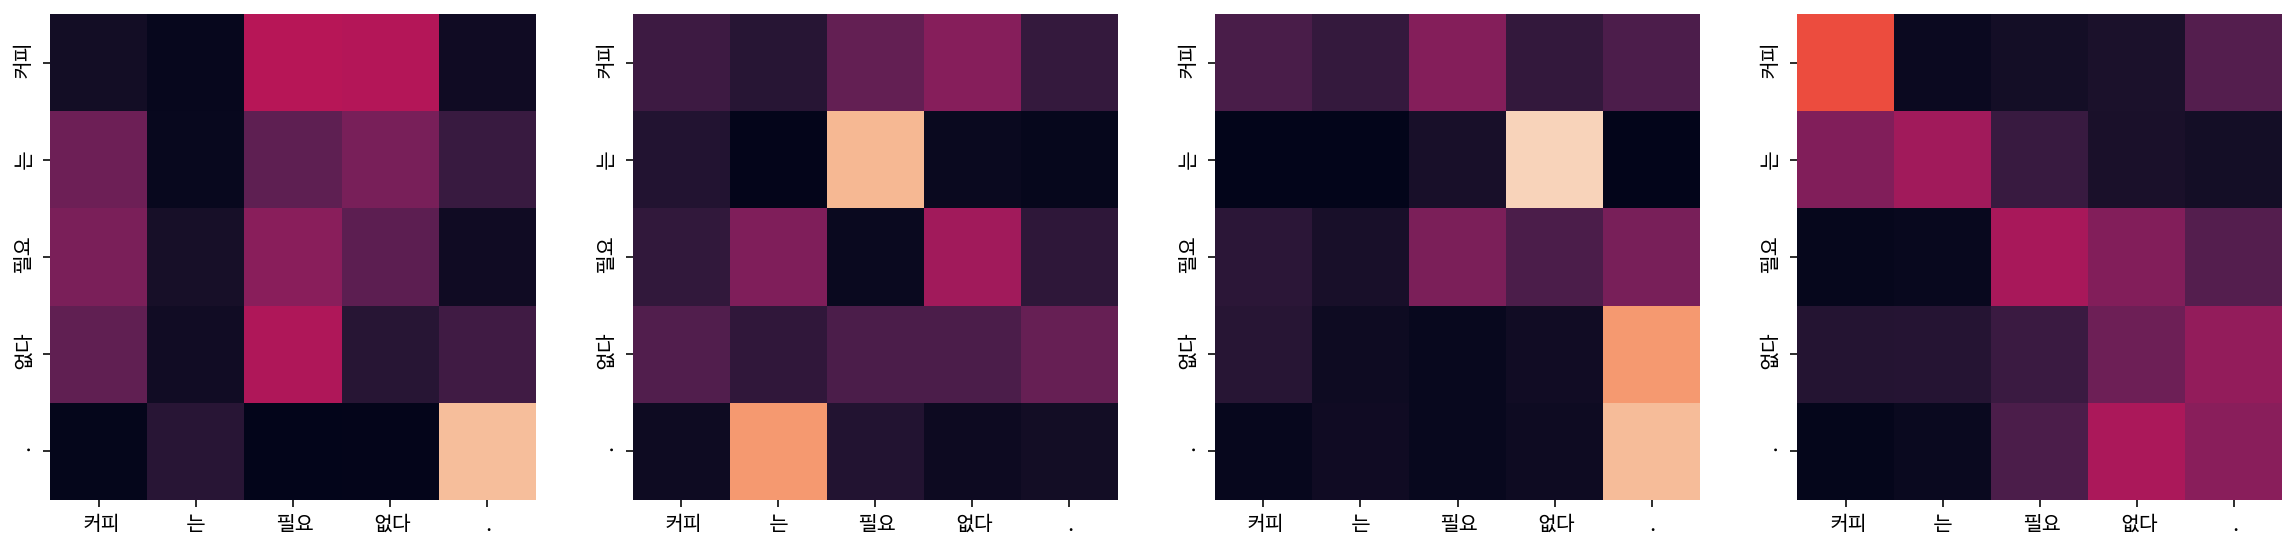

Encoder Layer 2


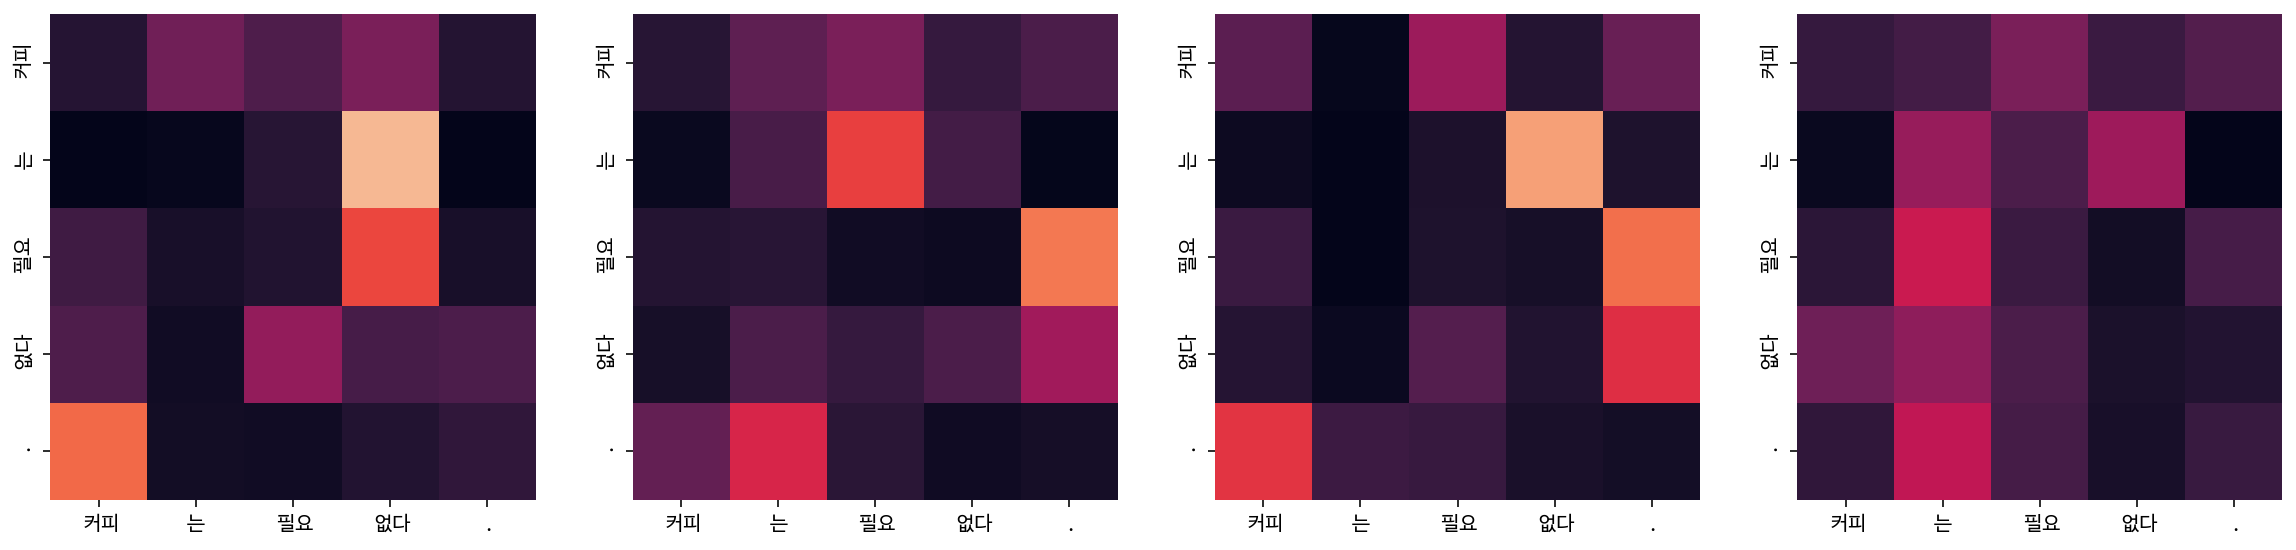

Decoder Self Layer 1


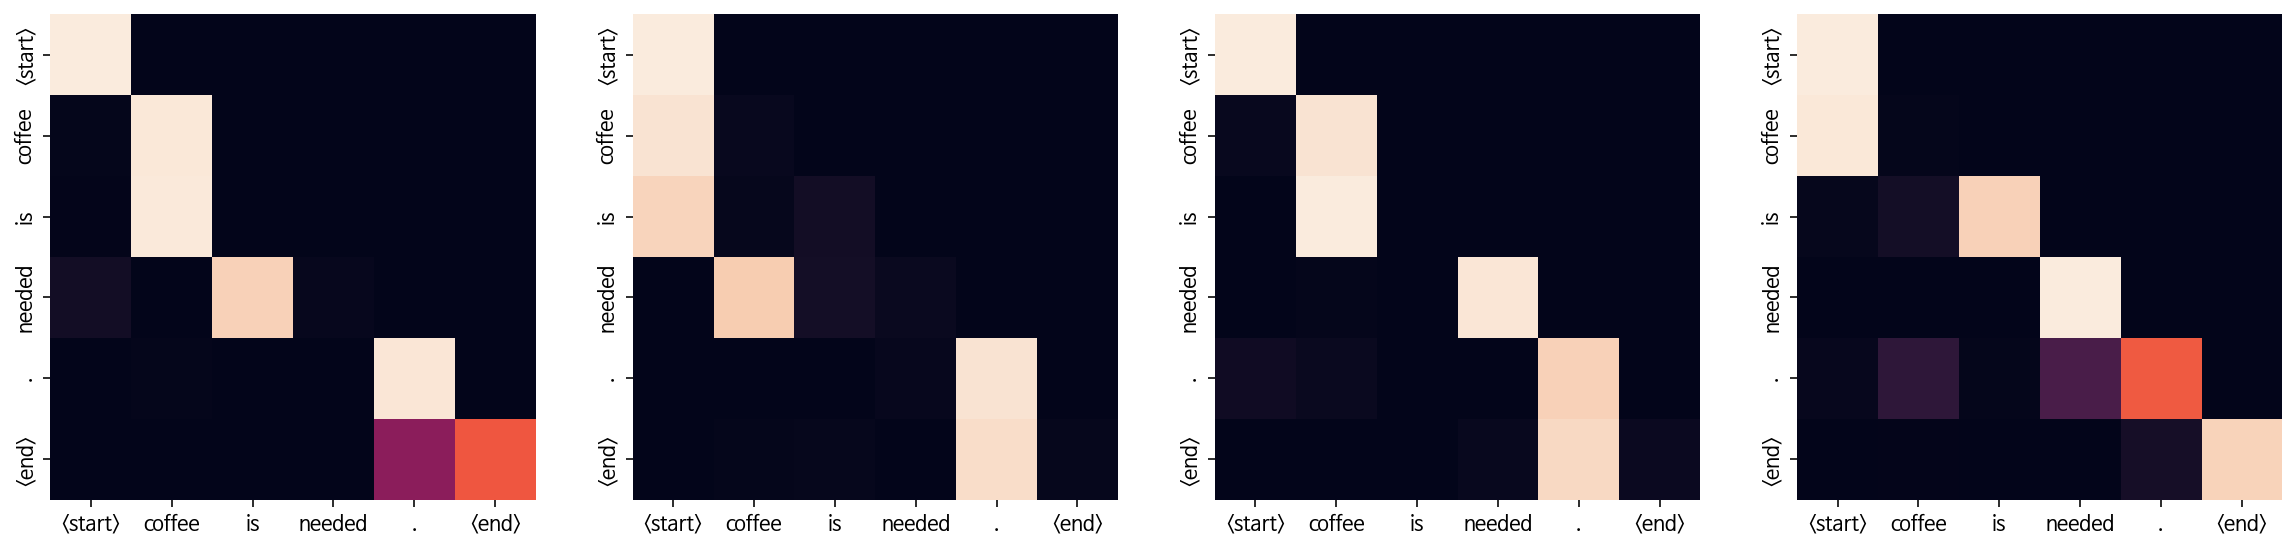

Decoder Src Layer 1


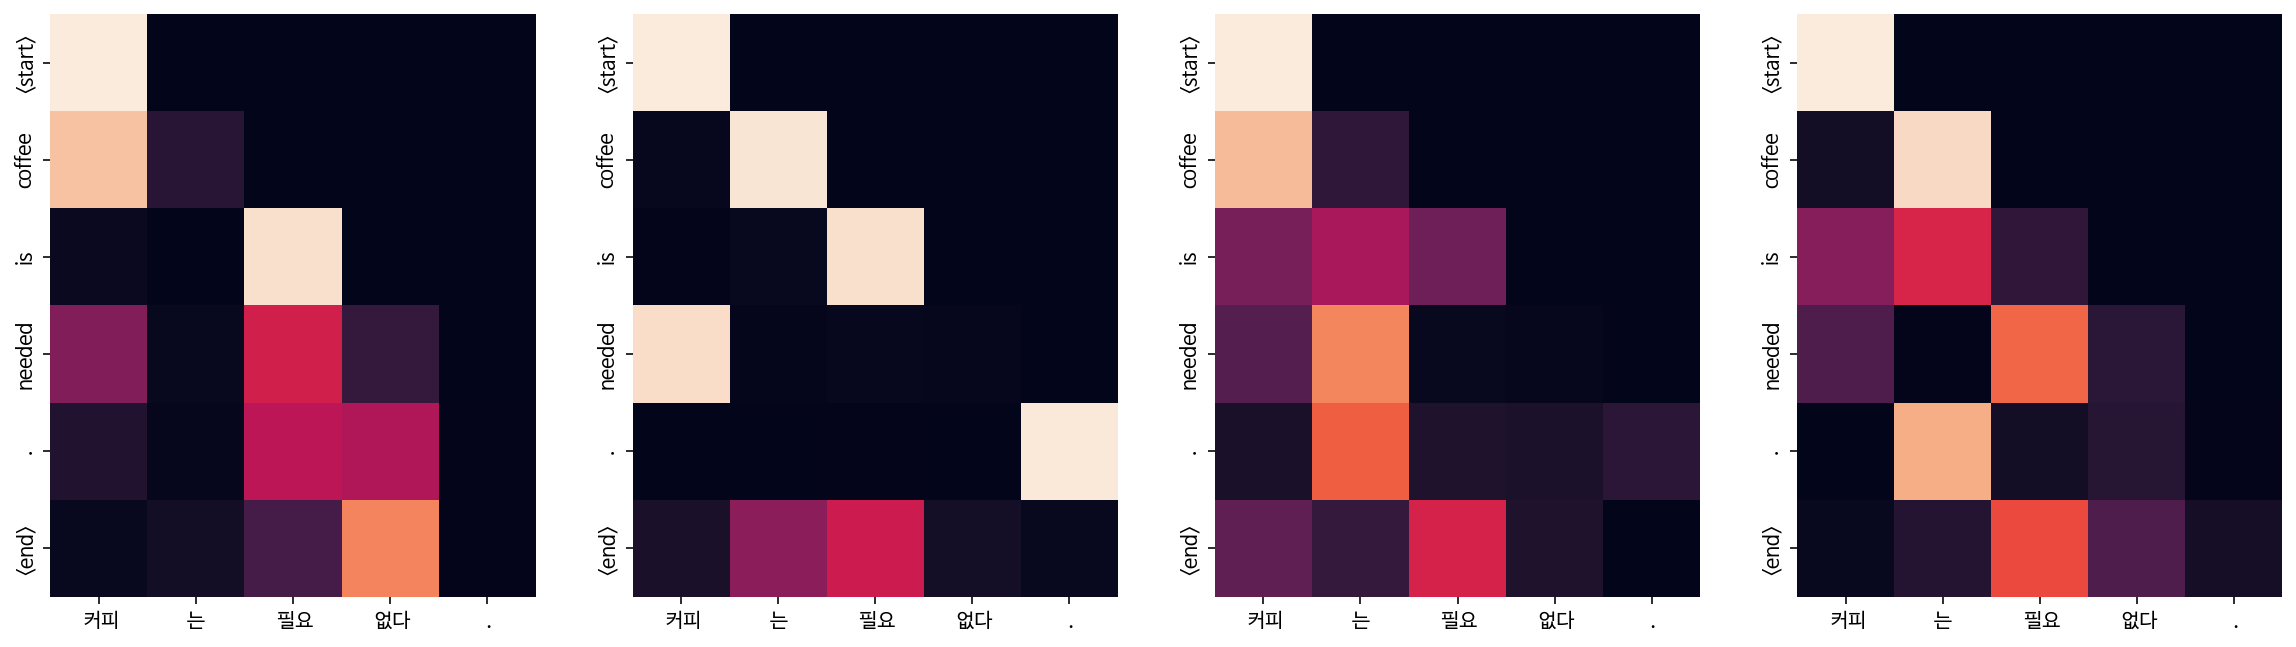

Decoder Self Layer 2


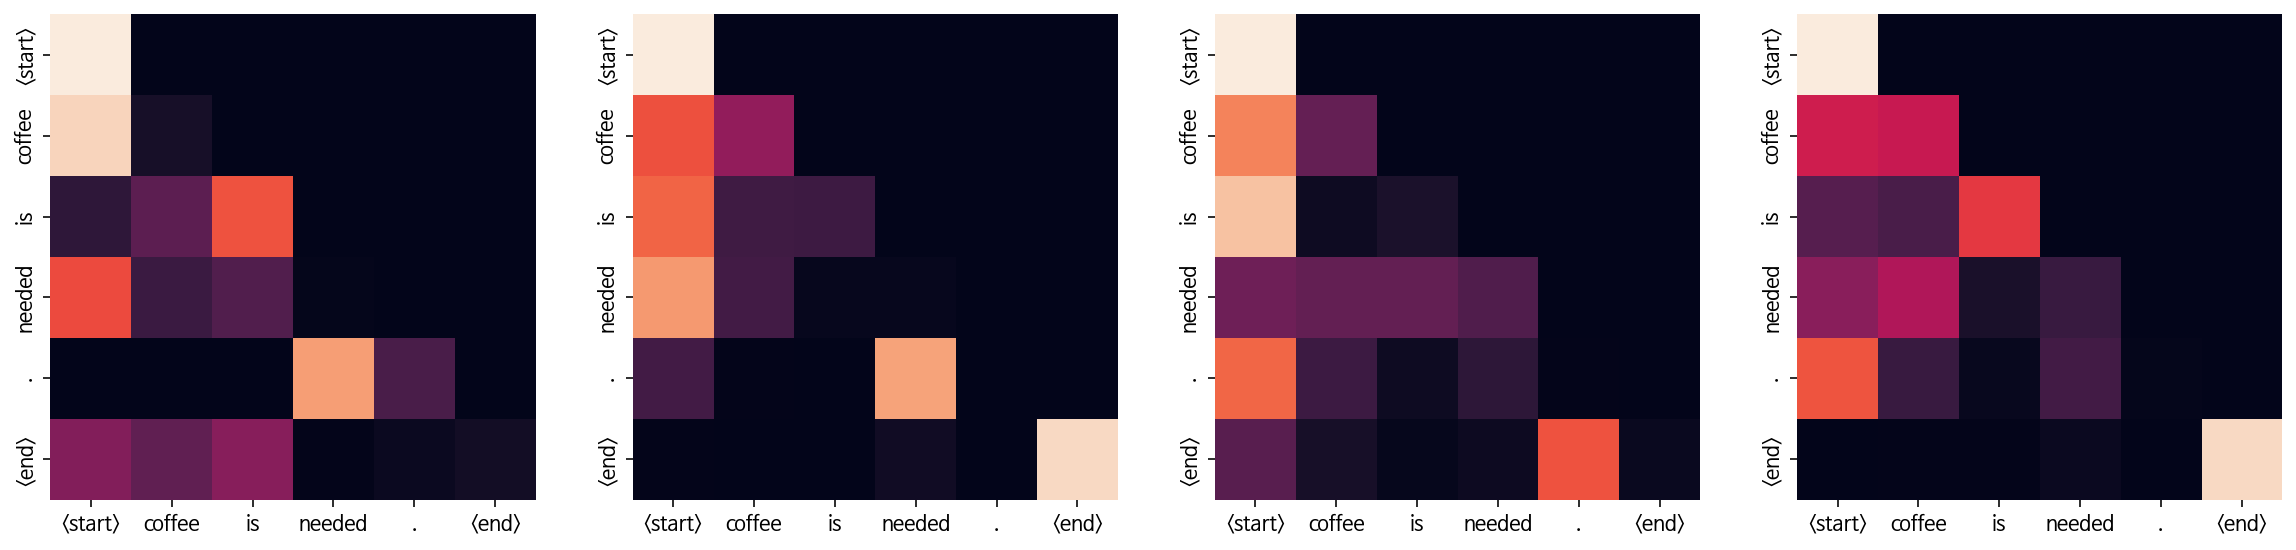

Decoder Src Layer 2


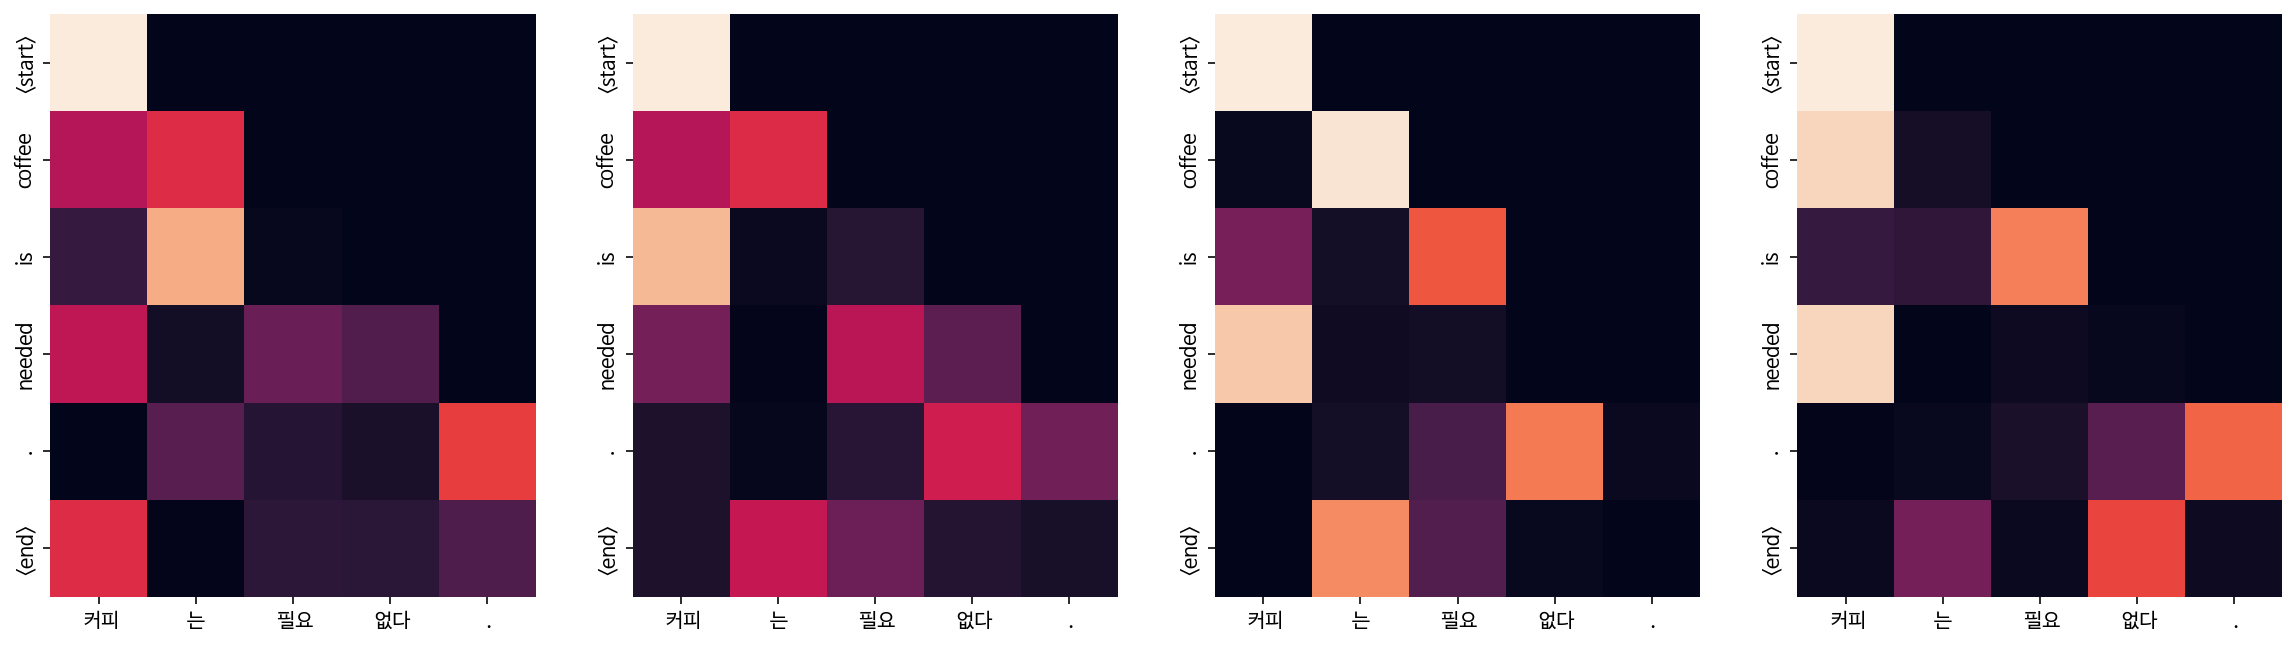

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <start> seven people were injured . <end>
Encoder Layer 1


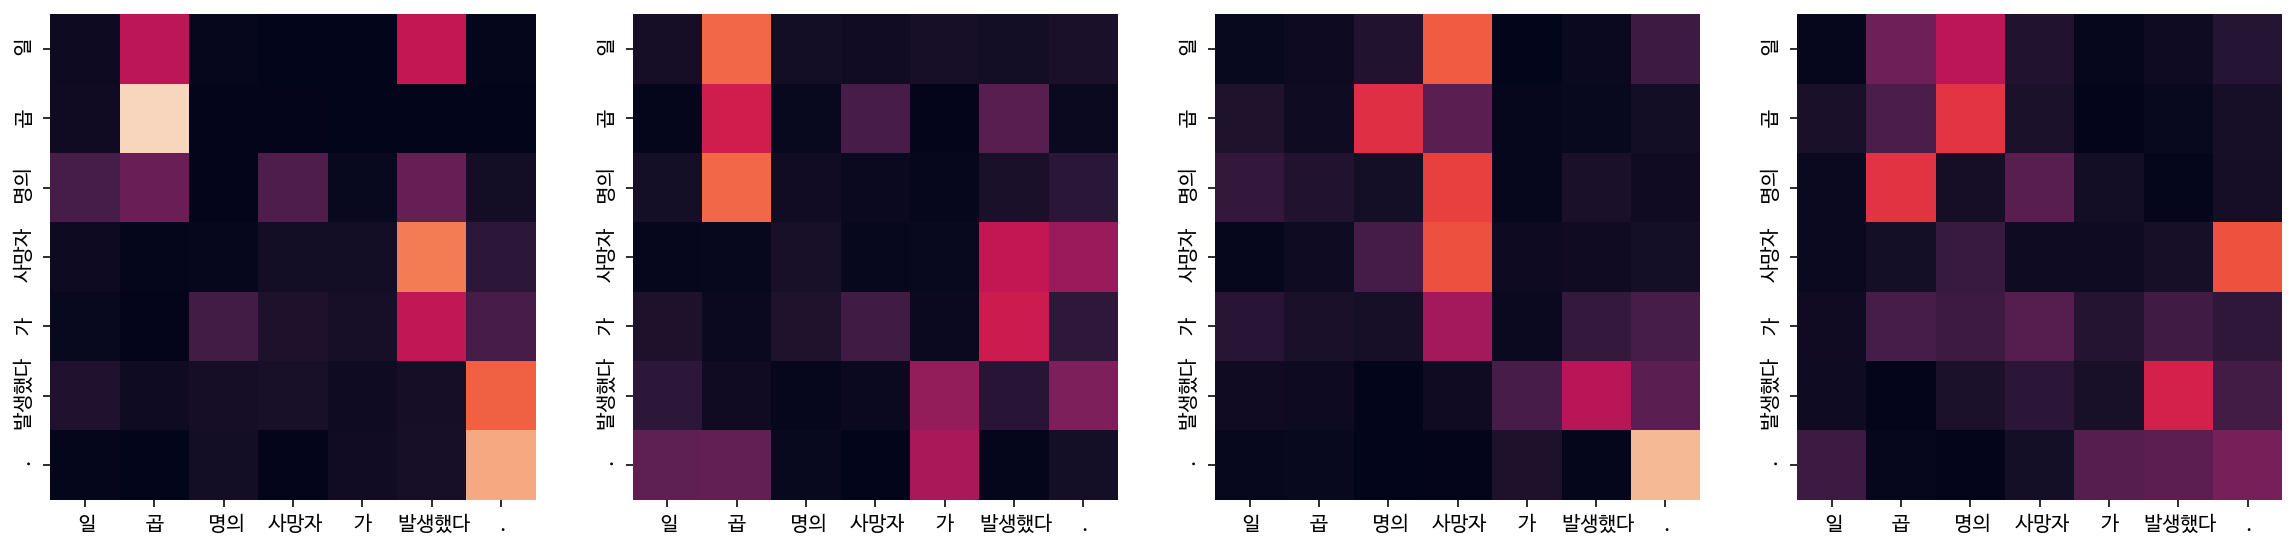

Encoder Layer 2


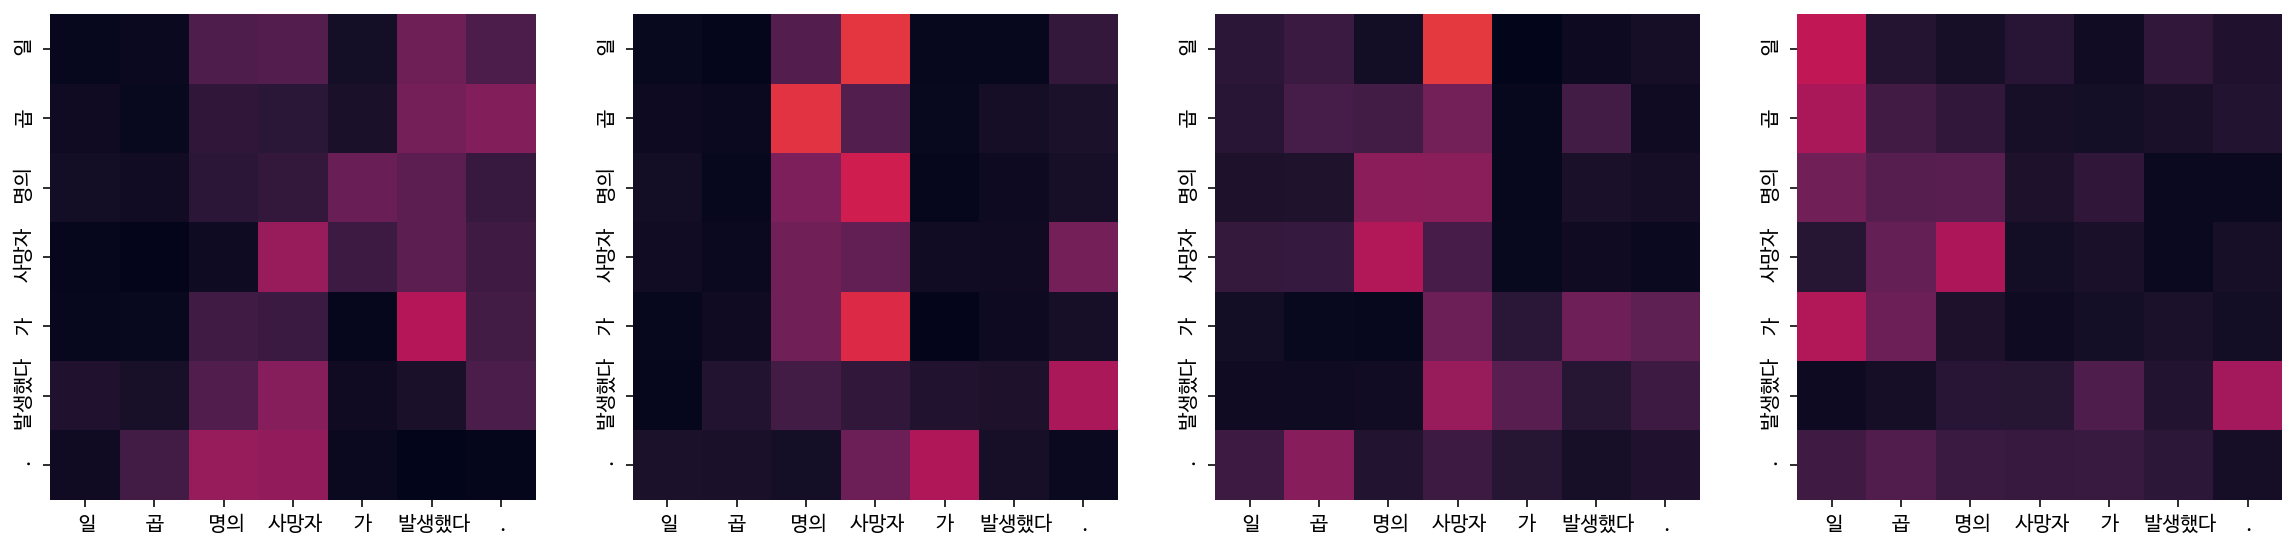

Decoder Self Layer 1


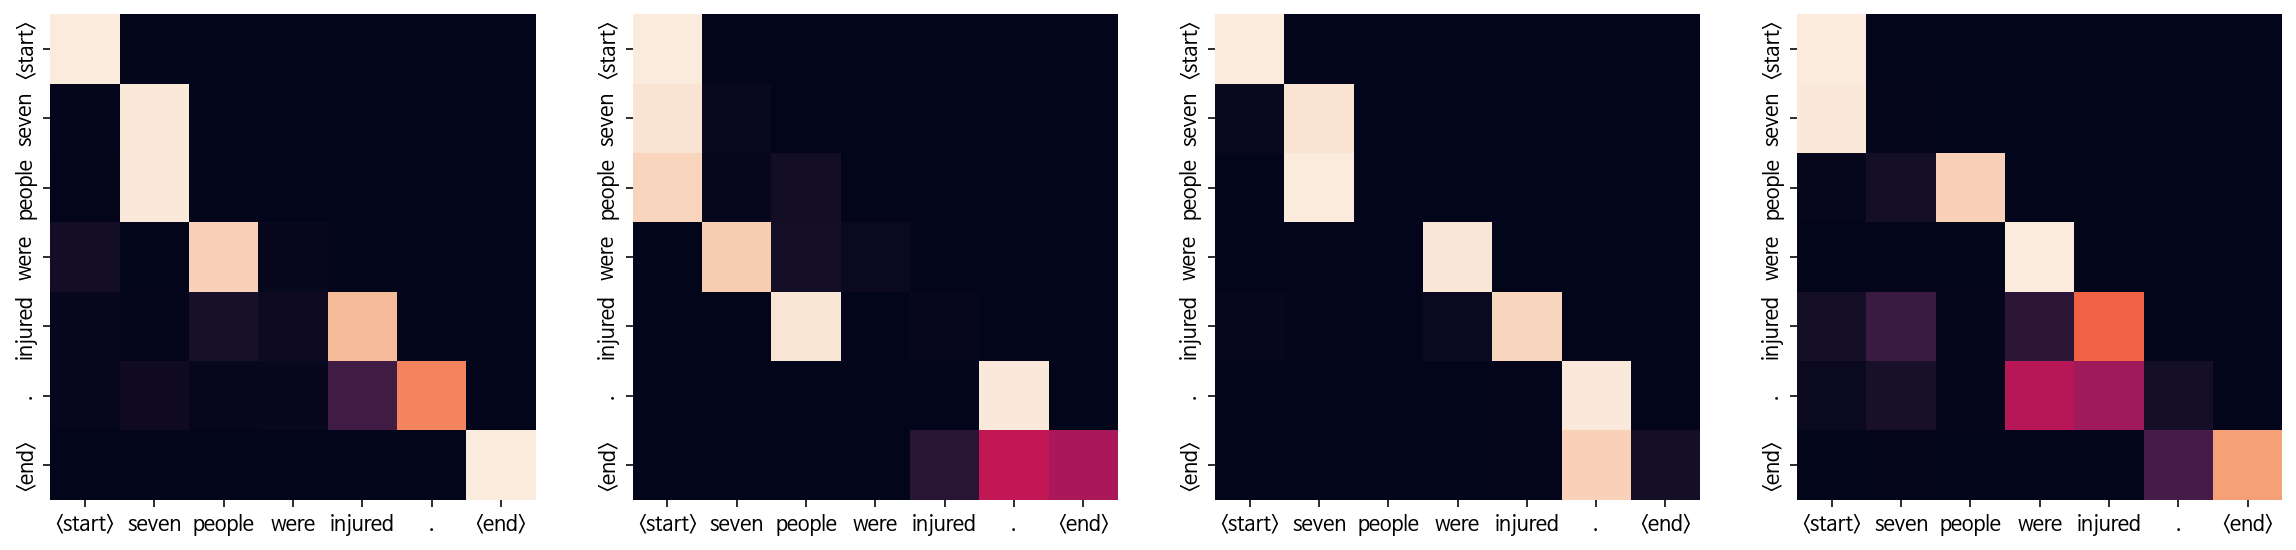

Decoder Src Layer 1


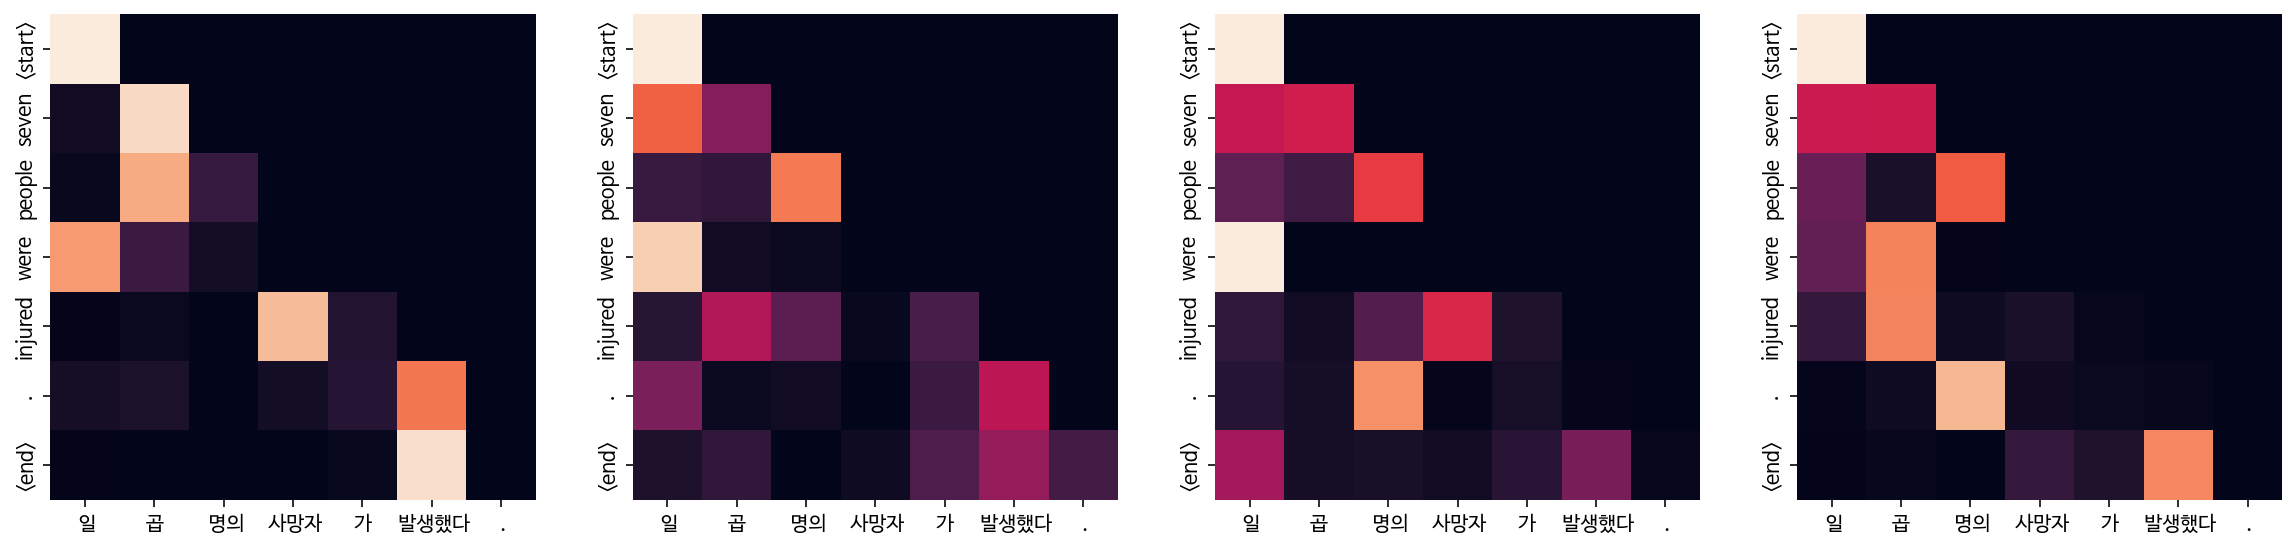

Decoder Self Layer 2


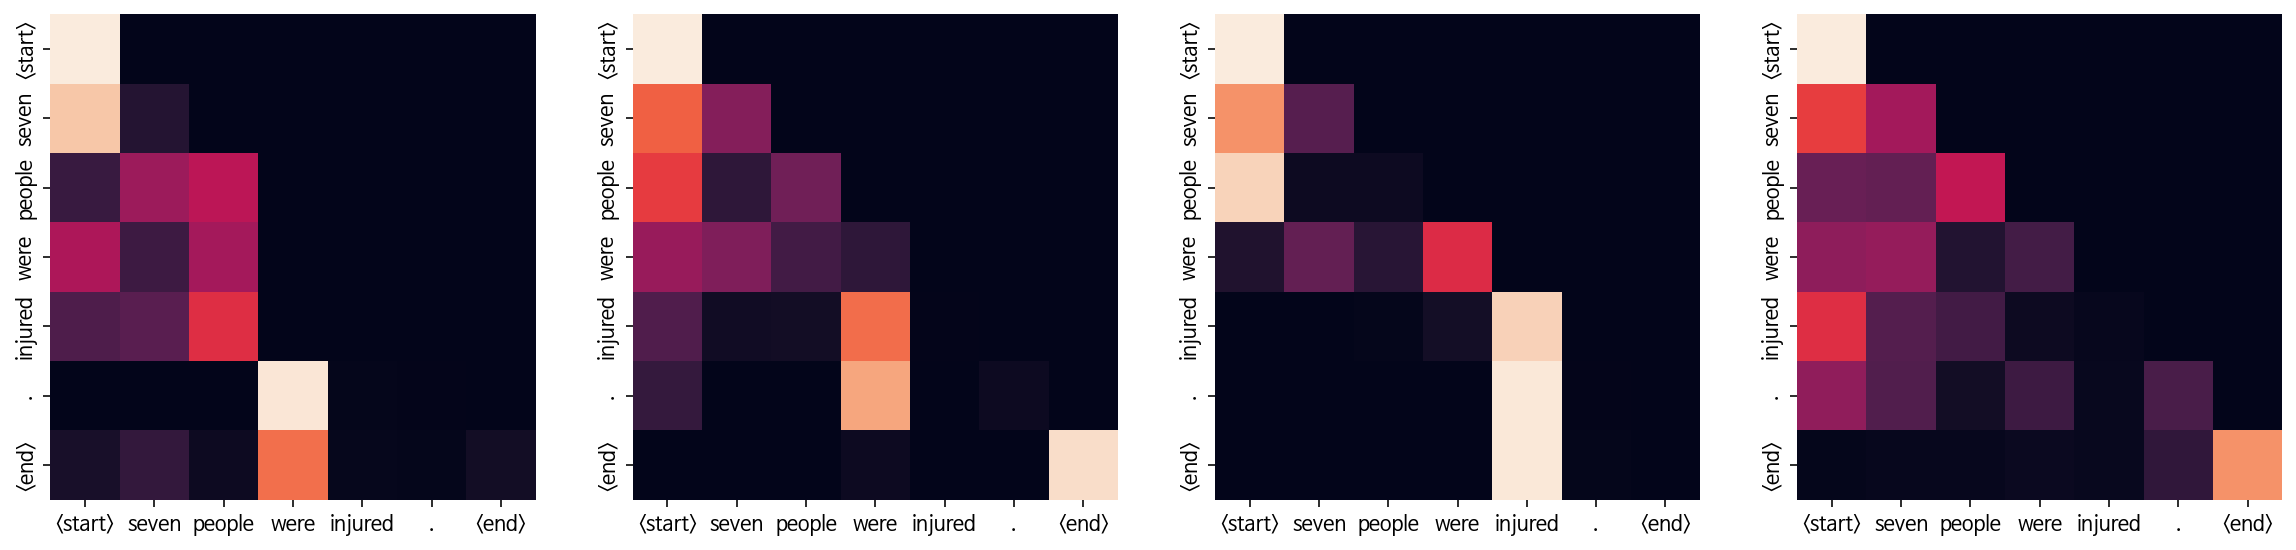

Decoder Src Layer 2


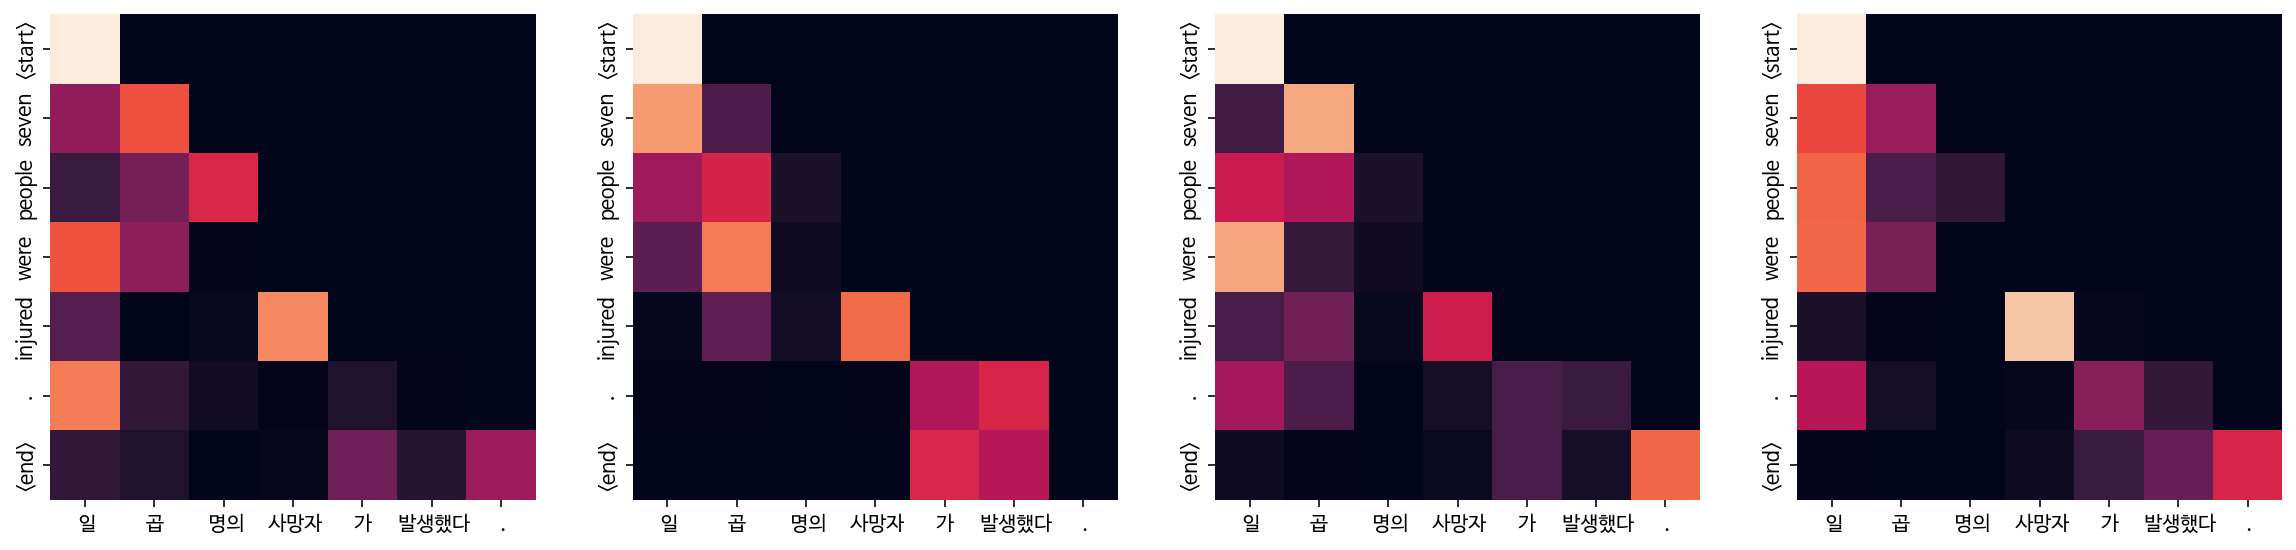

  0%|          | 0/3683 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: <start> obama is a president elect . <end>
Encoder Layer 1


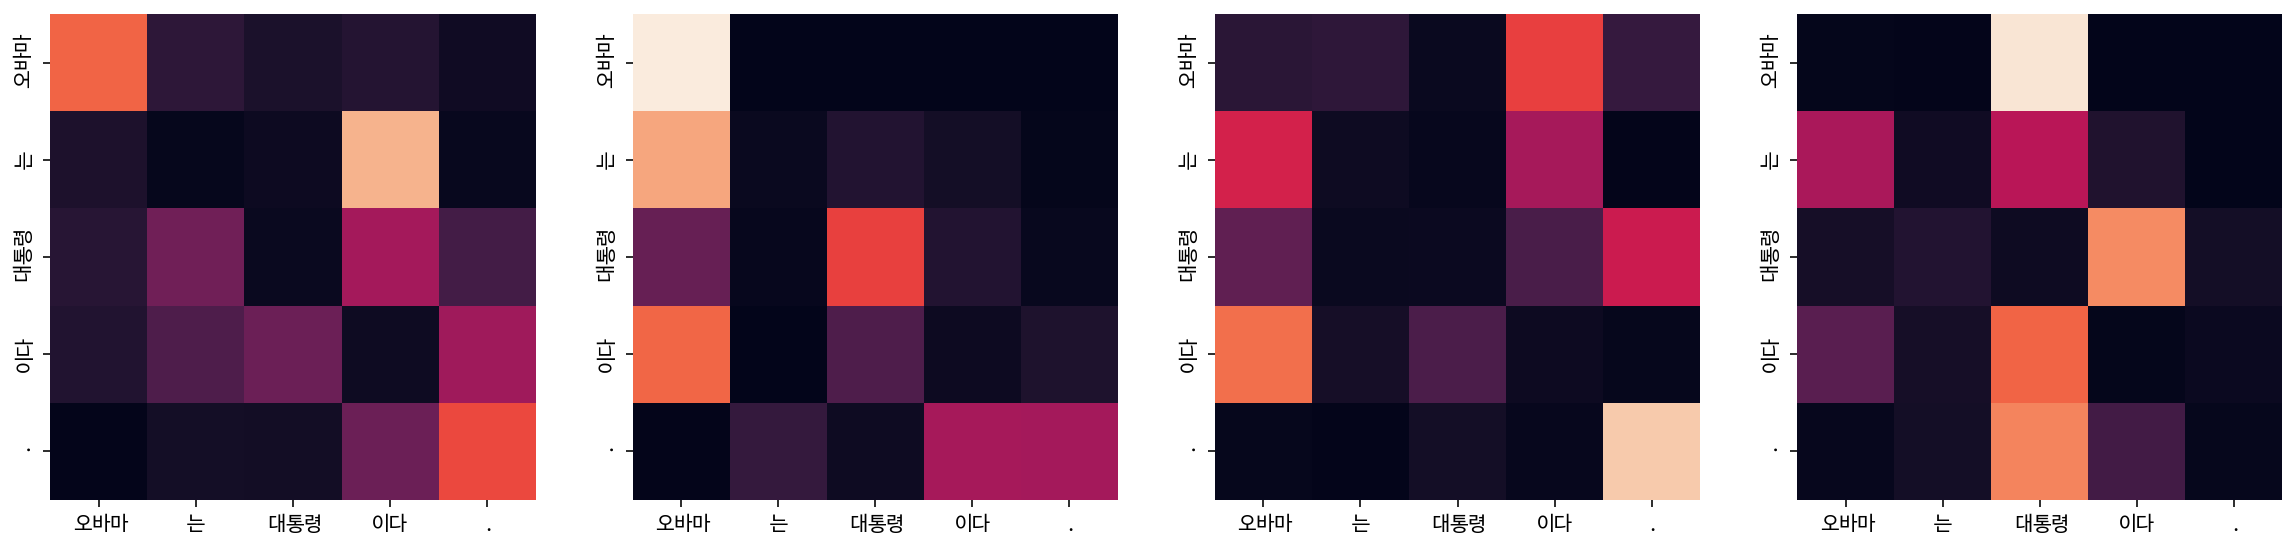

Encoder Layer 2


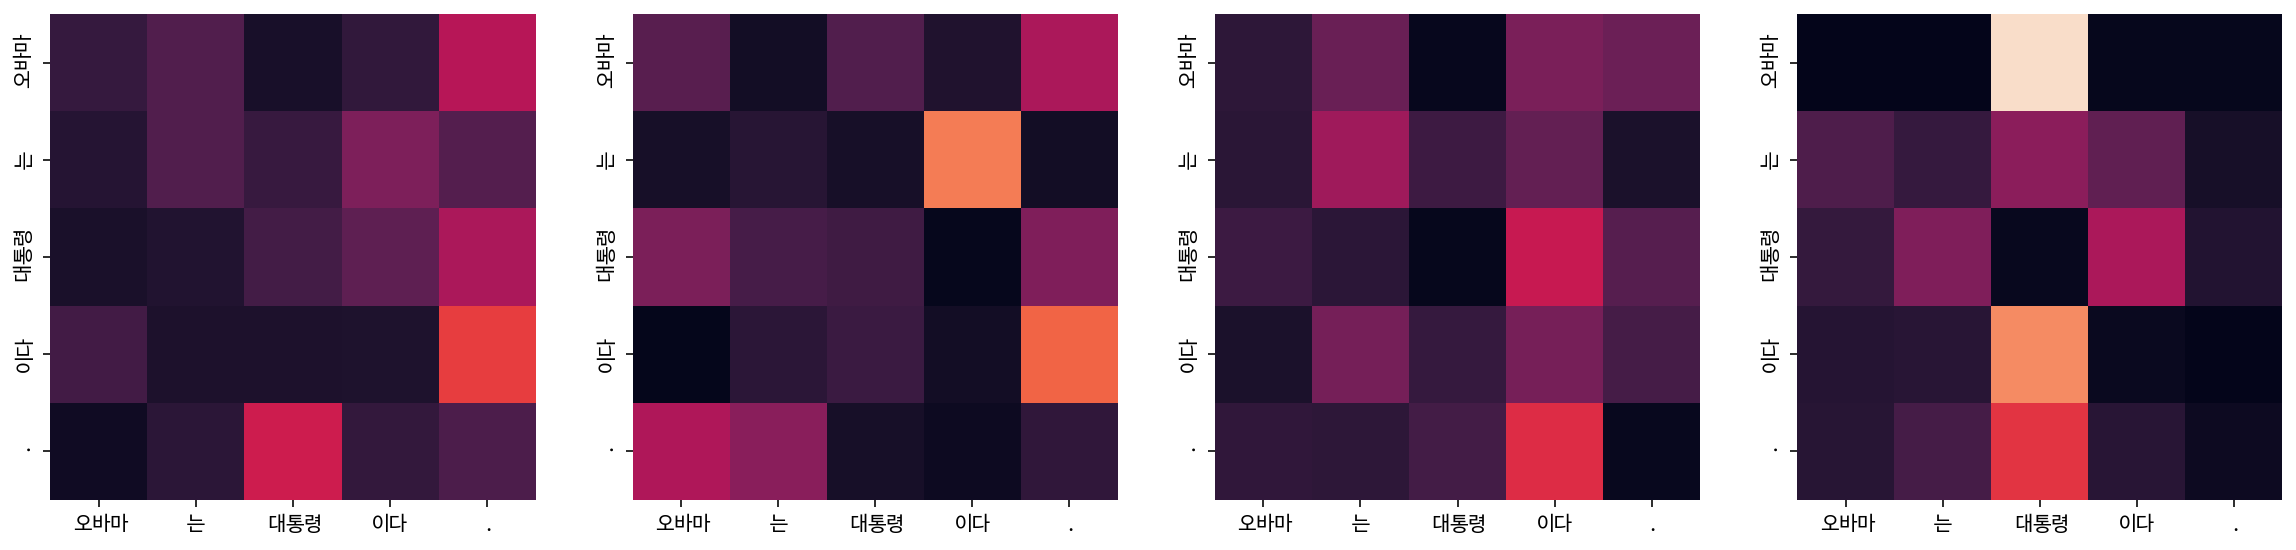

Decoder Self Layer 1


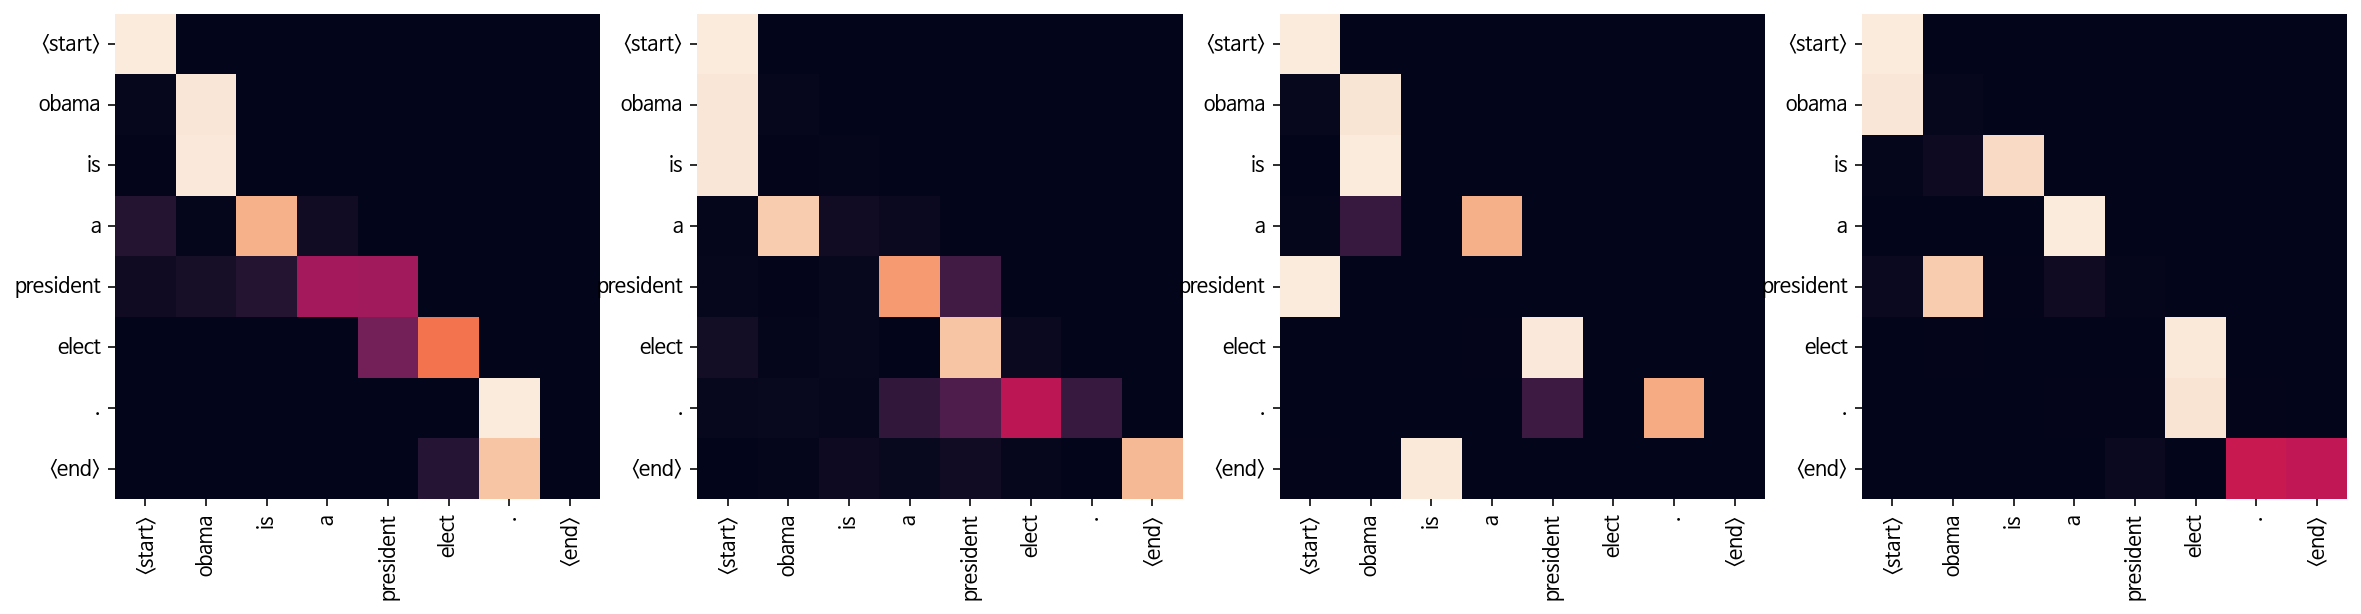

Decoder Src Layer 1


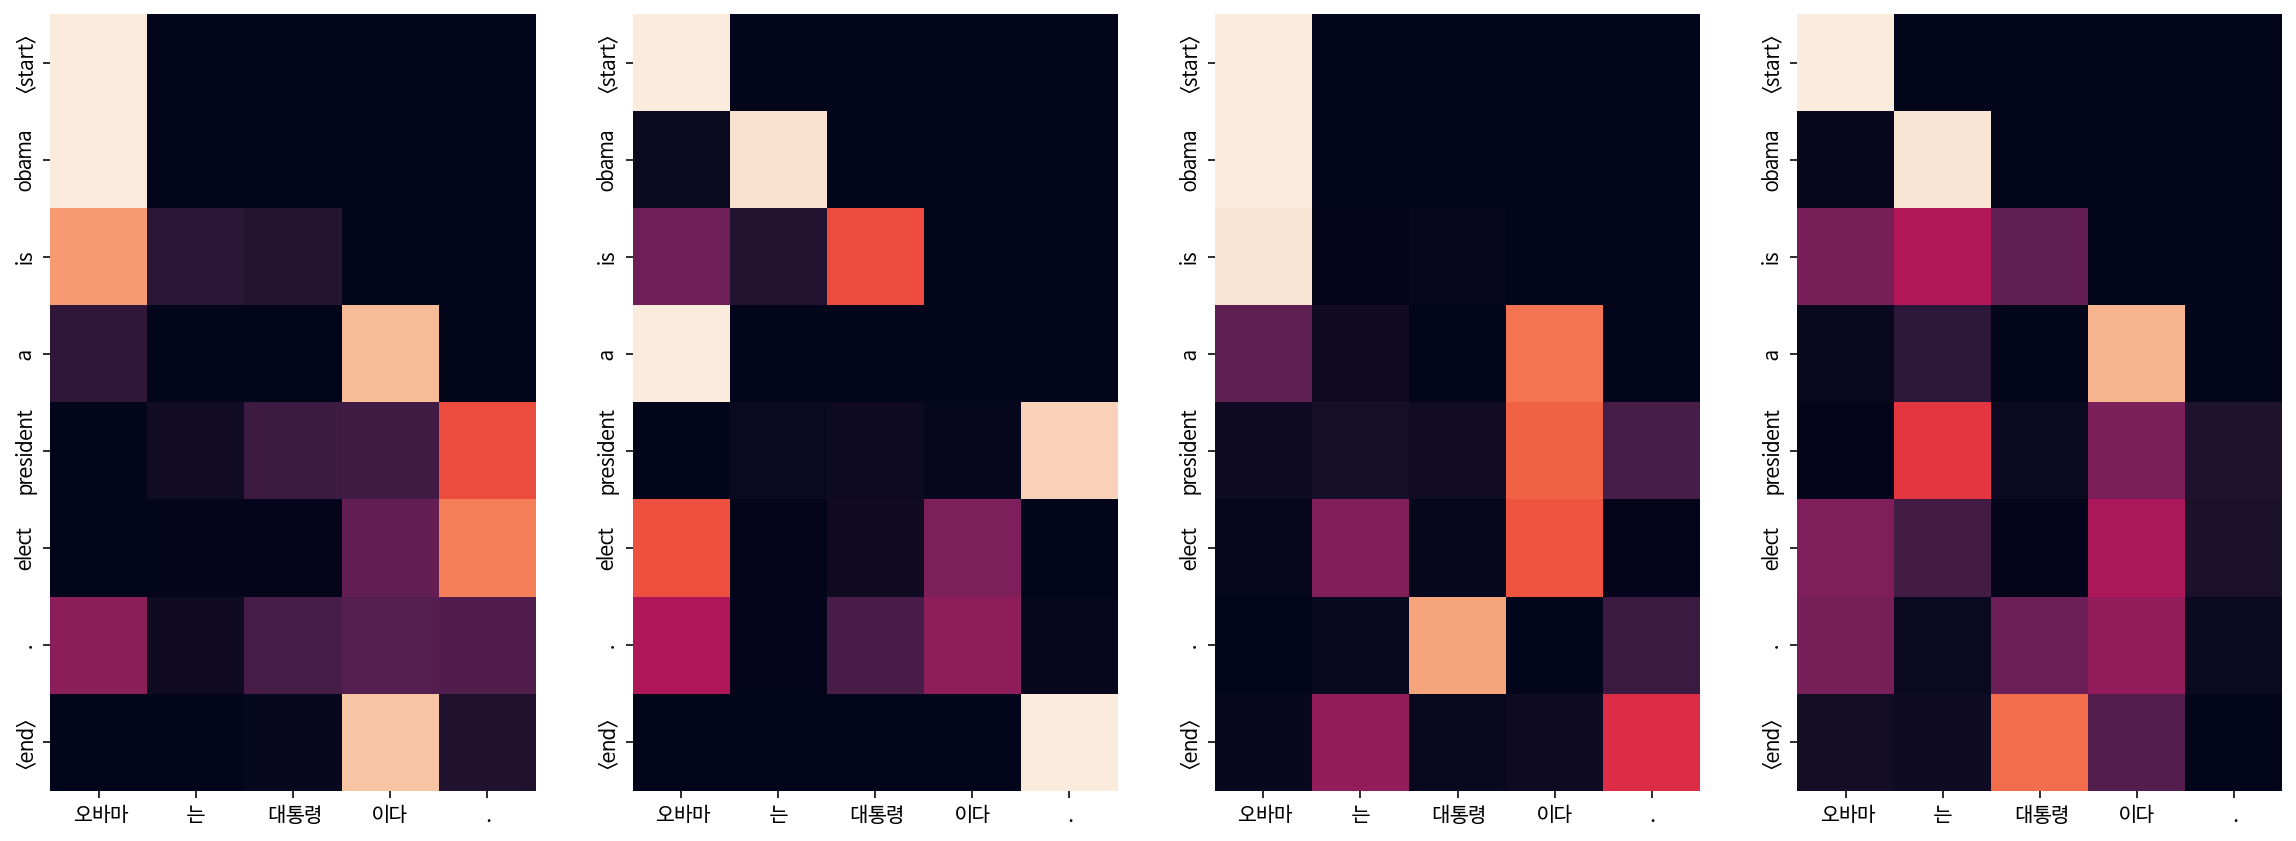

Decoder Self Layer 2


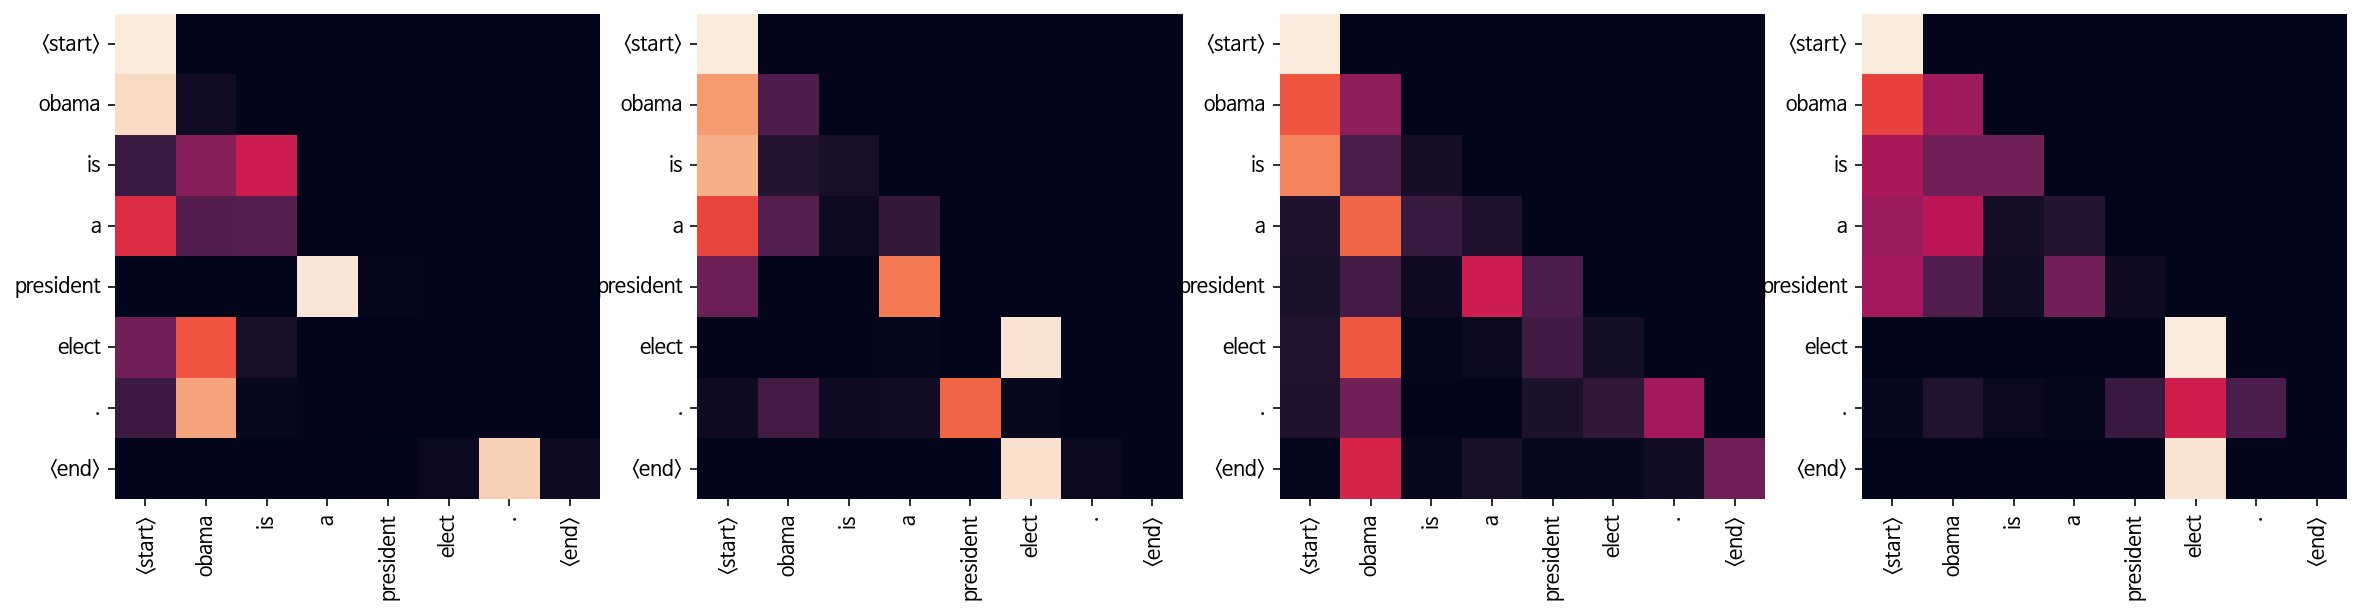

Decoder Src Layer 2


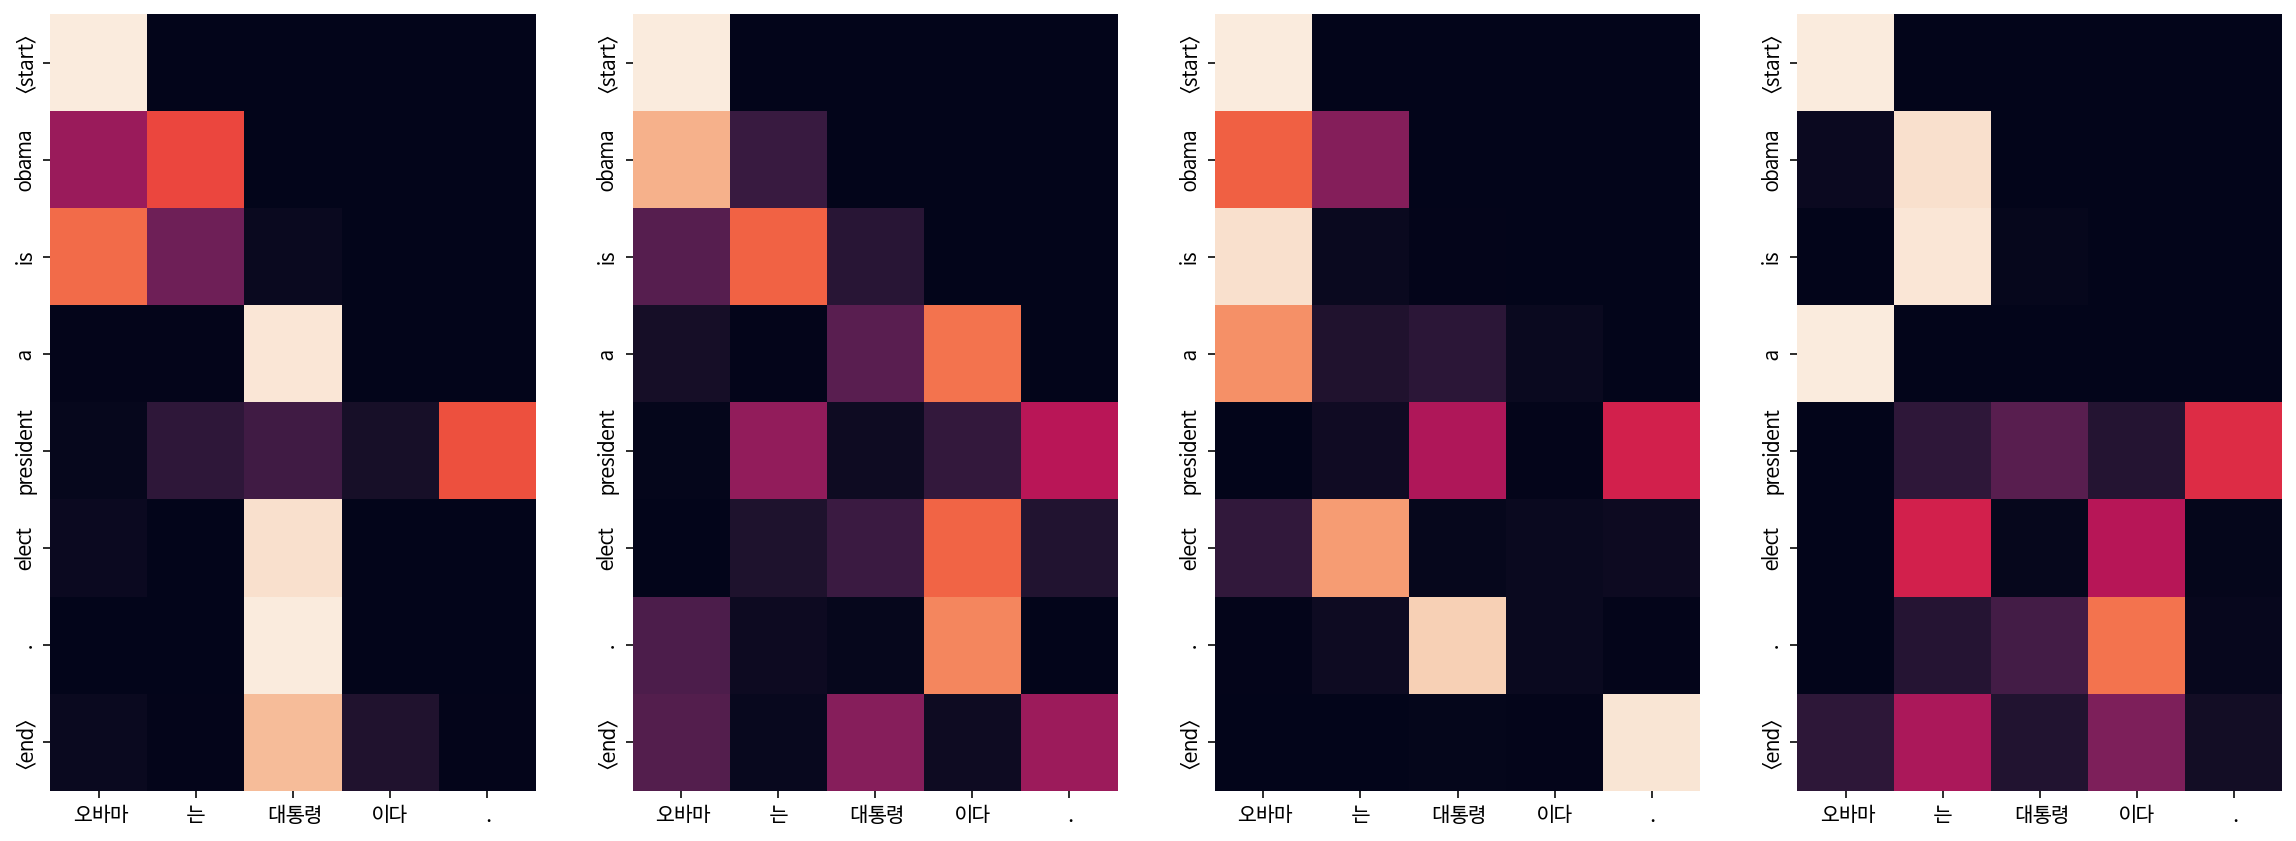

Input: 시민들은 도시 속에 산다.
Predicted translation: <start> the urban area is in the city . <end>
Encoder Layer 1


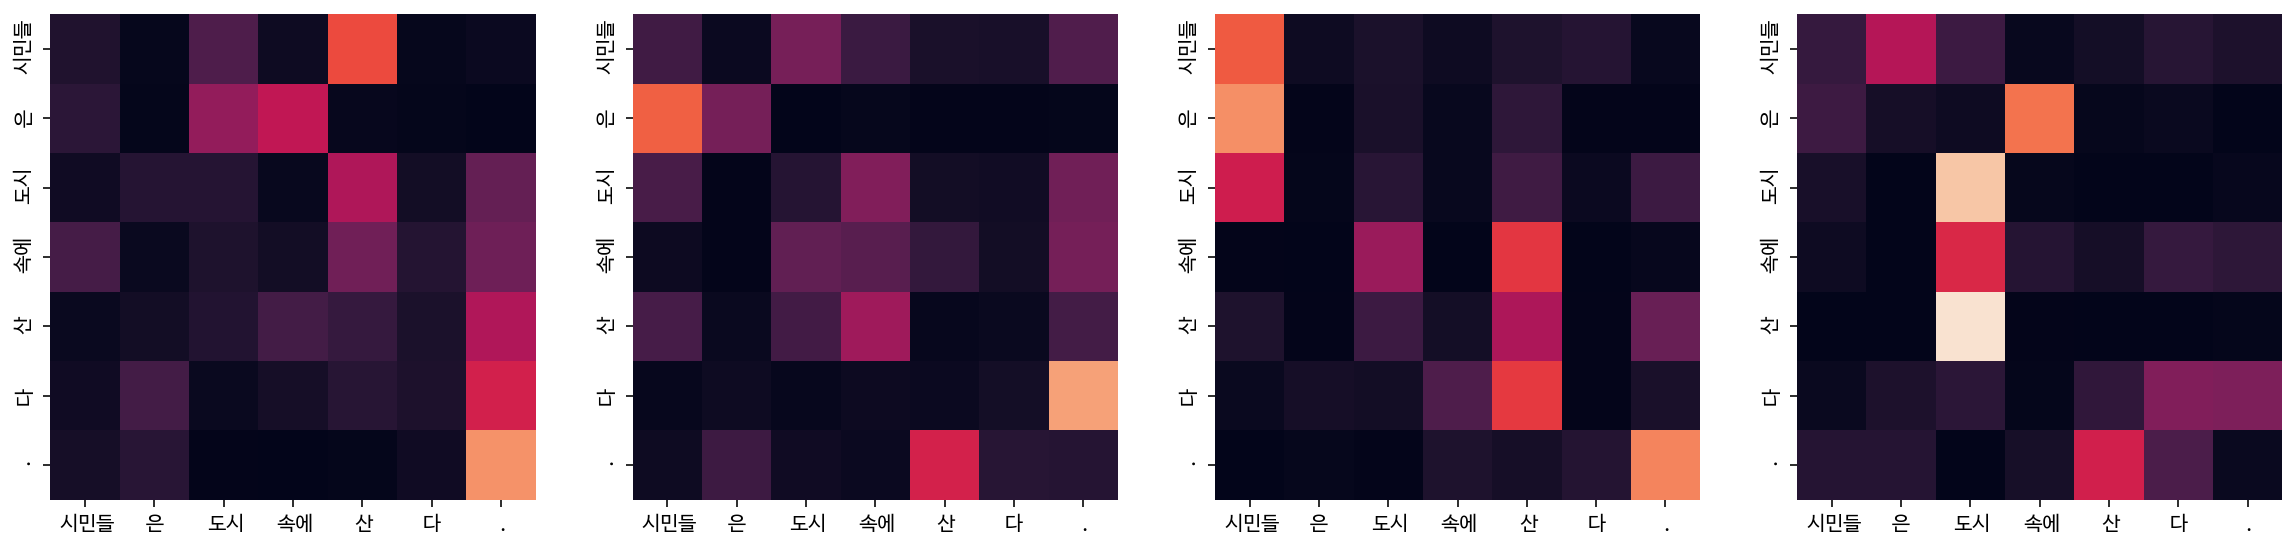

Encoder Layer 2


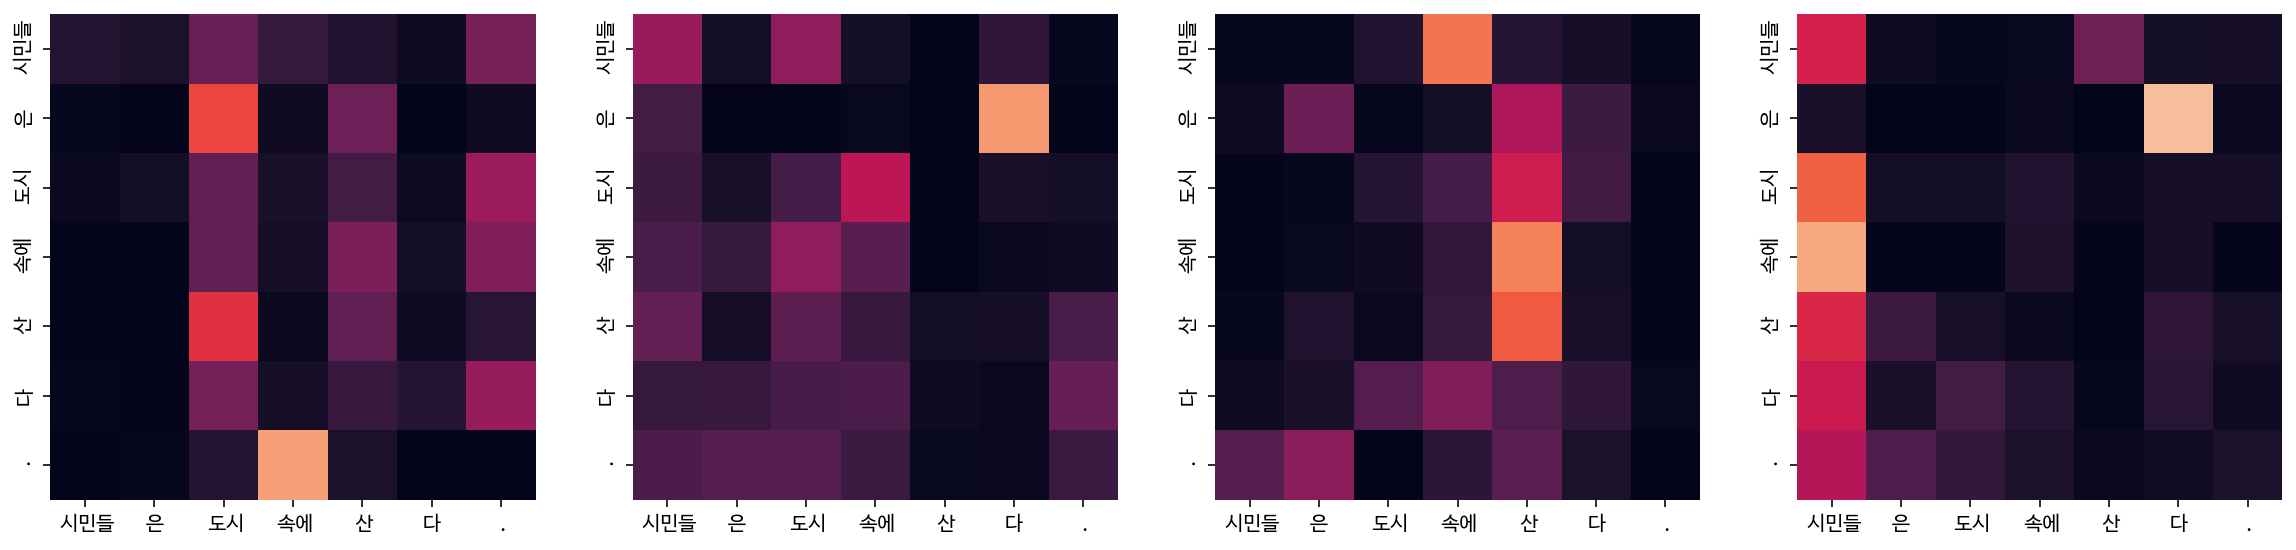

Decoder Self Layer 1


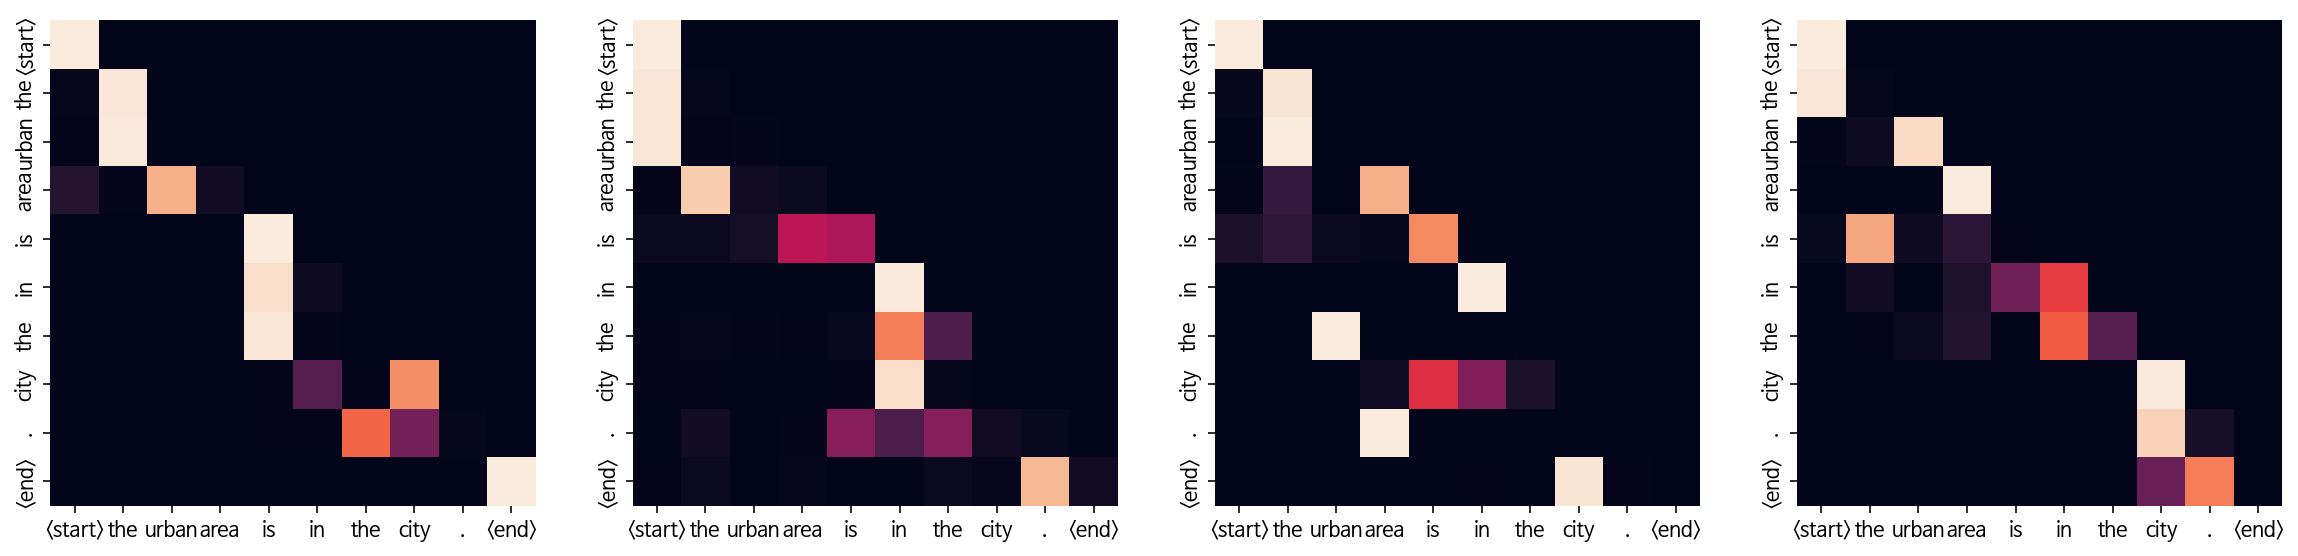

Decoder Src Layer 1


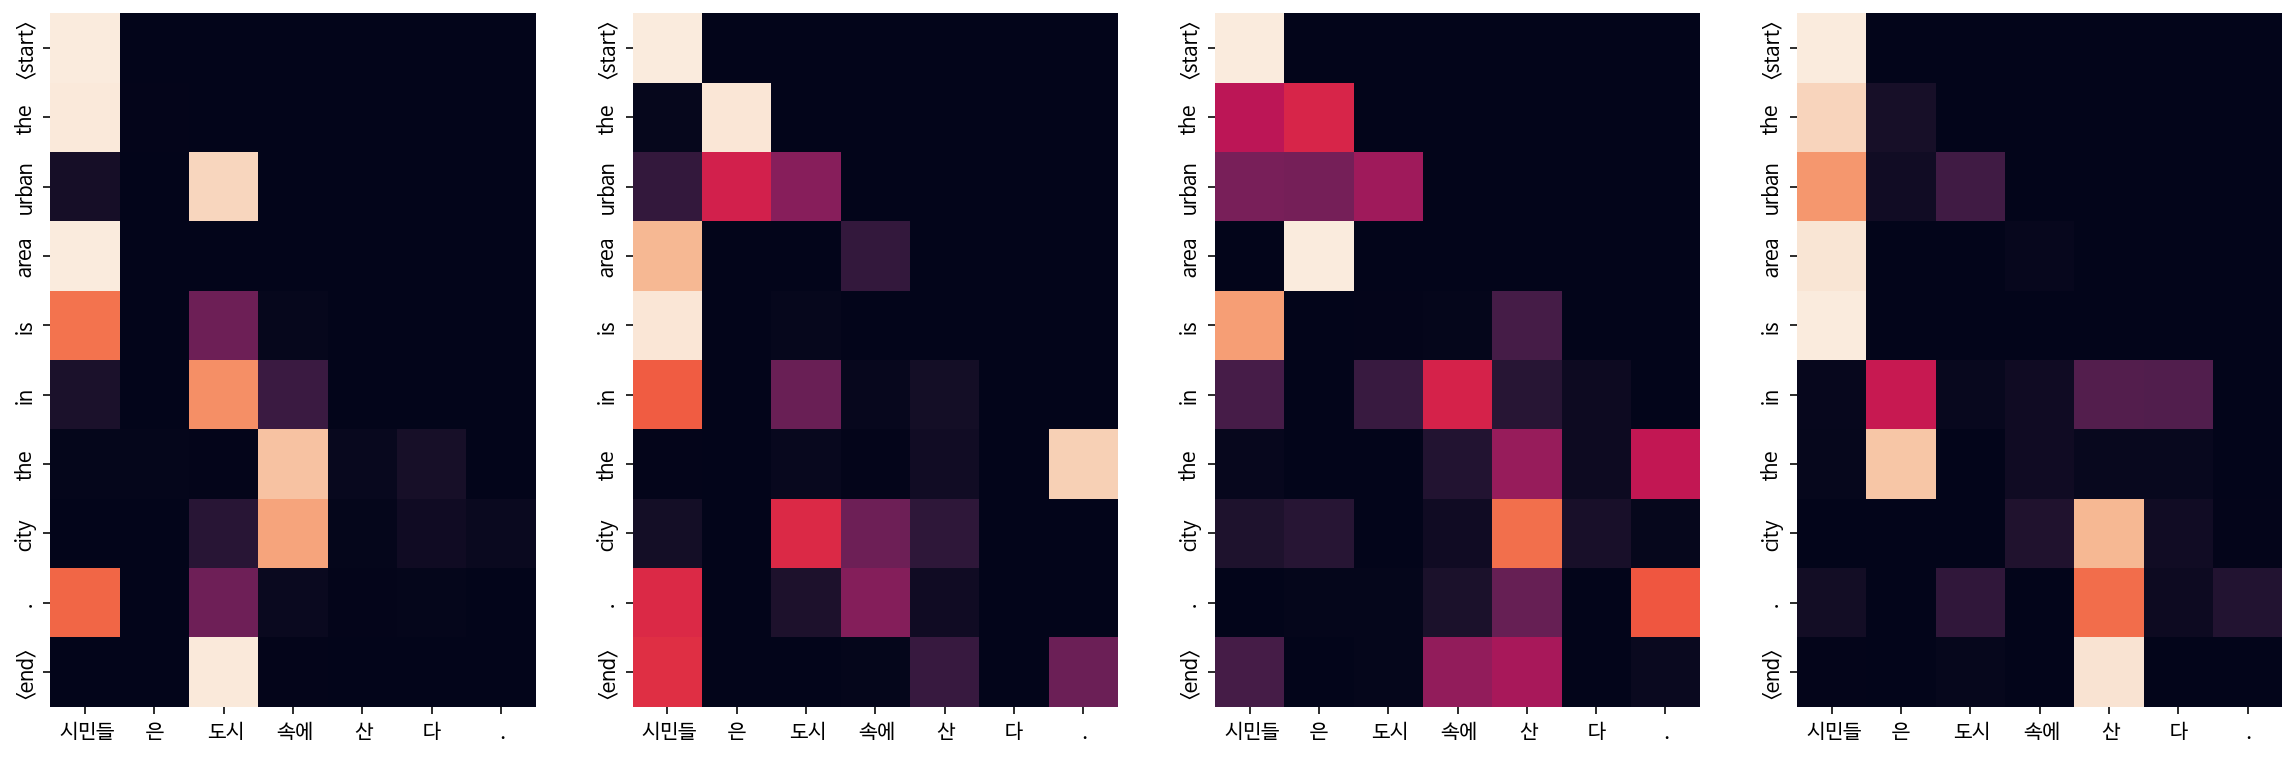

Decoder Self Layer 2


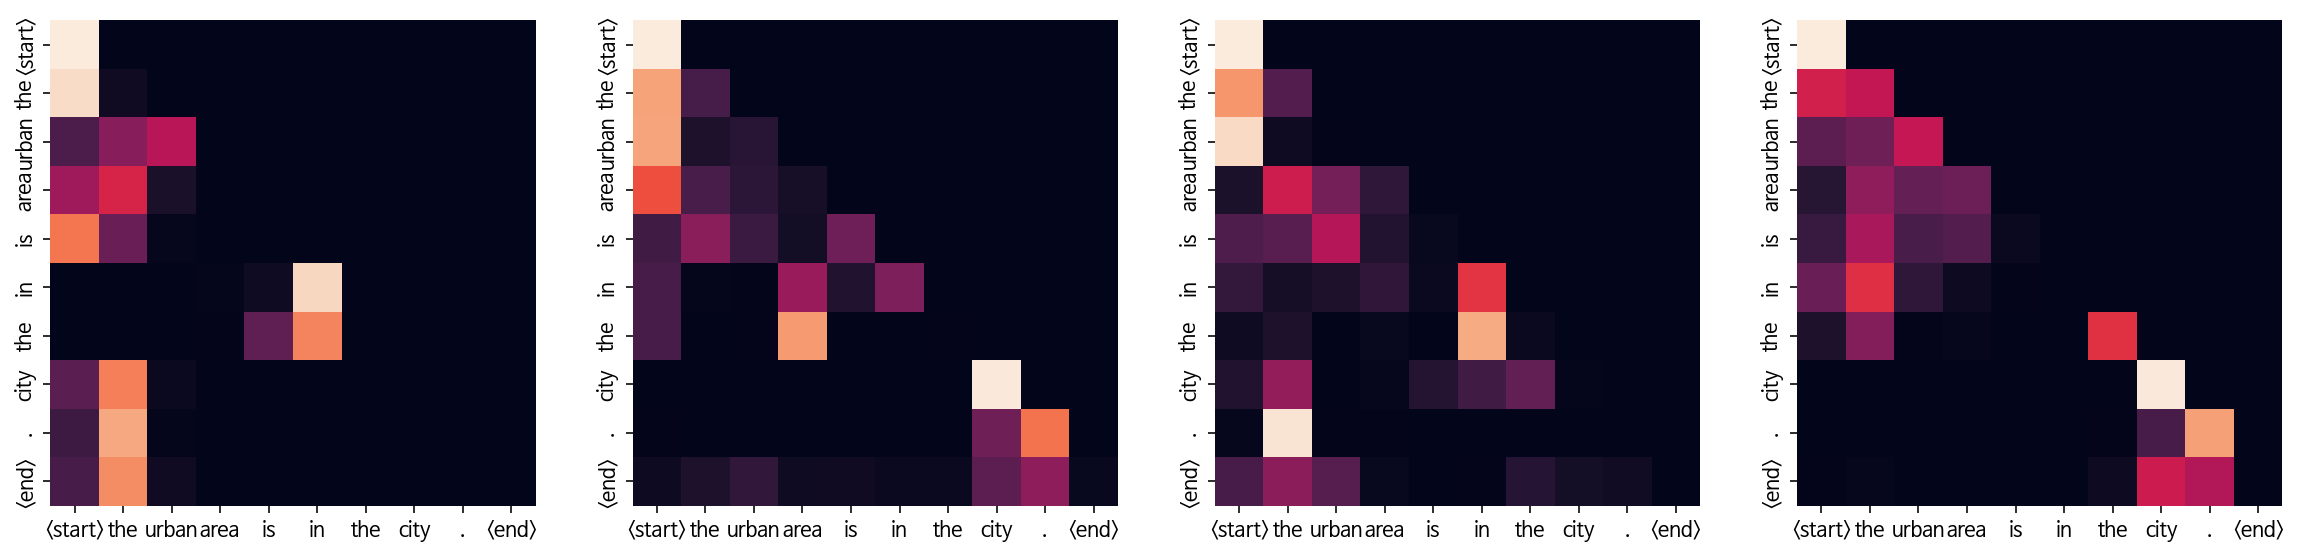

Decoder Src Layer 2


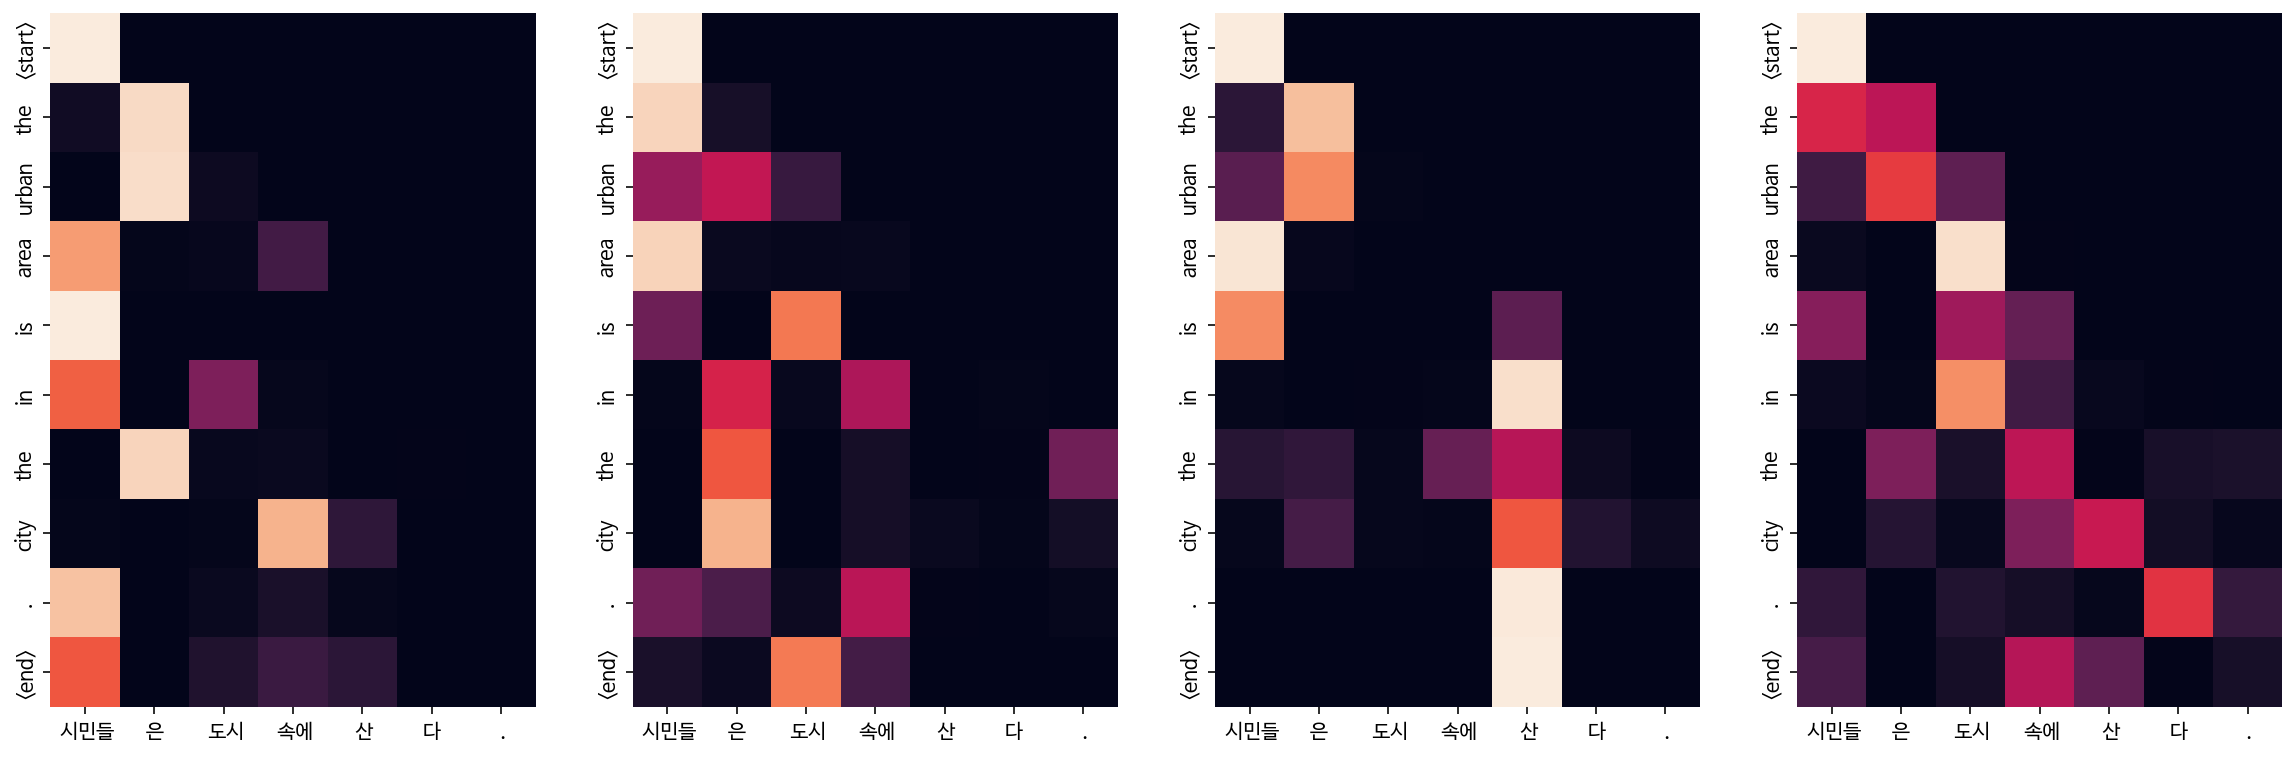

Input: 커피는 필요 없다.
Predicted translation: <start> you need to be very coffee . <end>
Encoder Layer 1


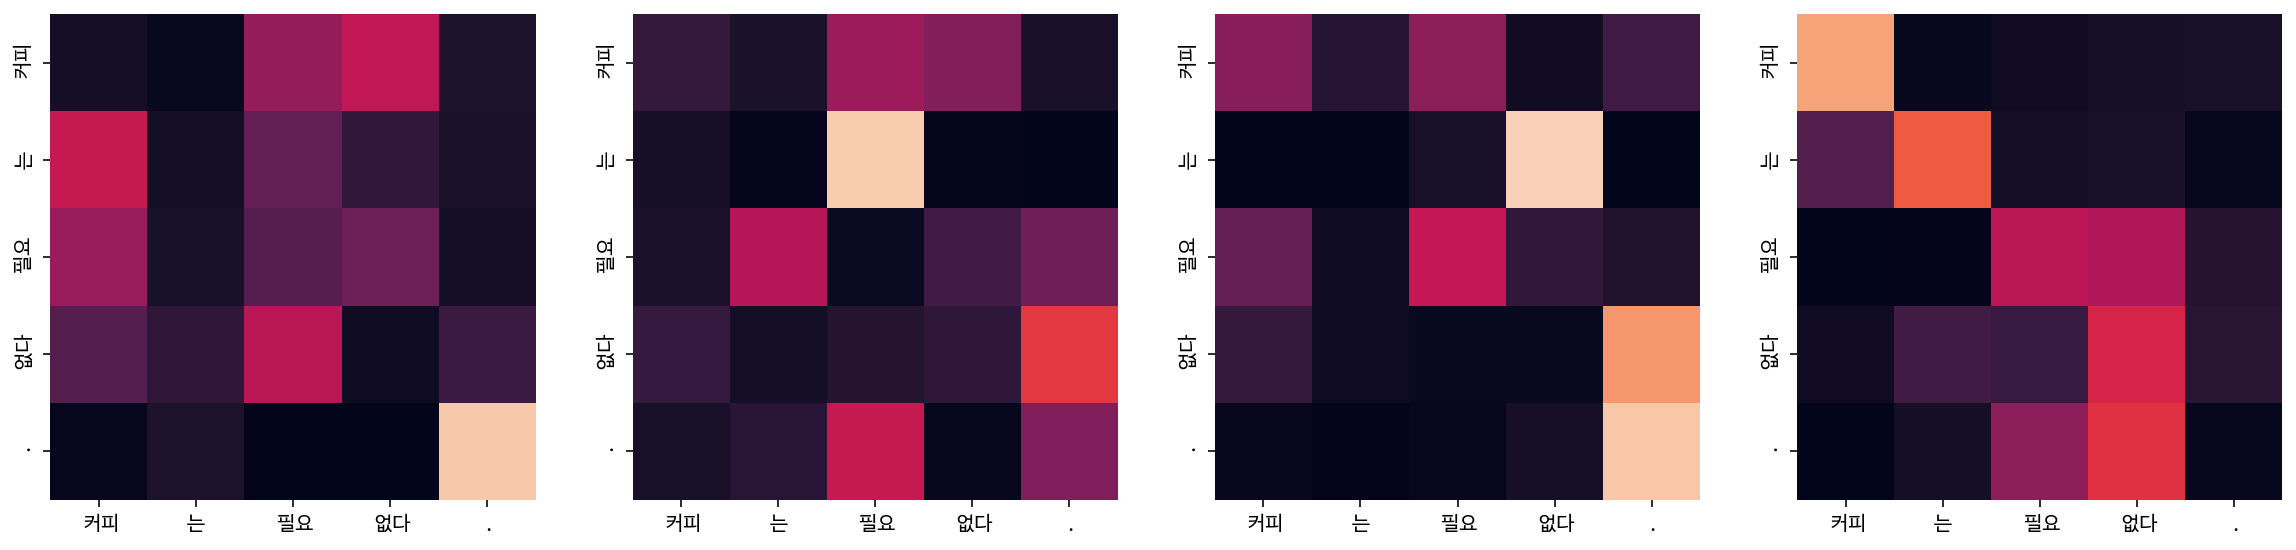

Encoder Layer 2


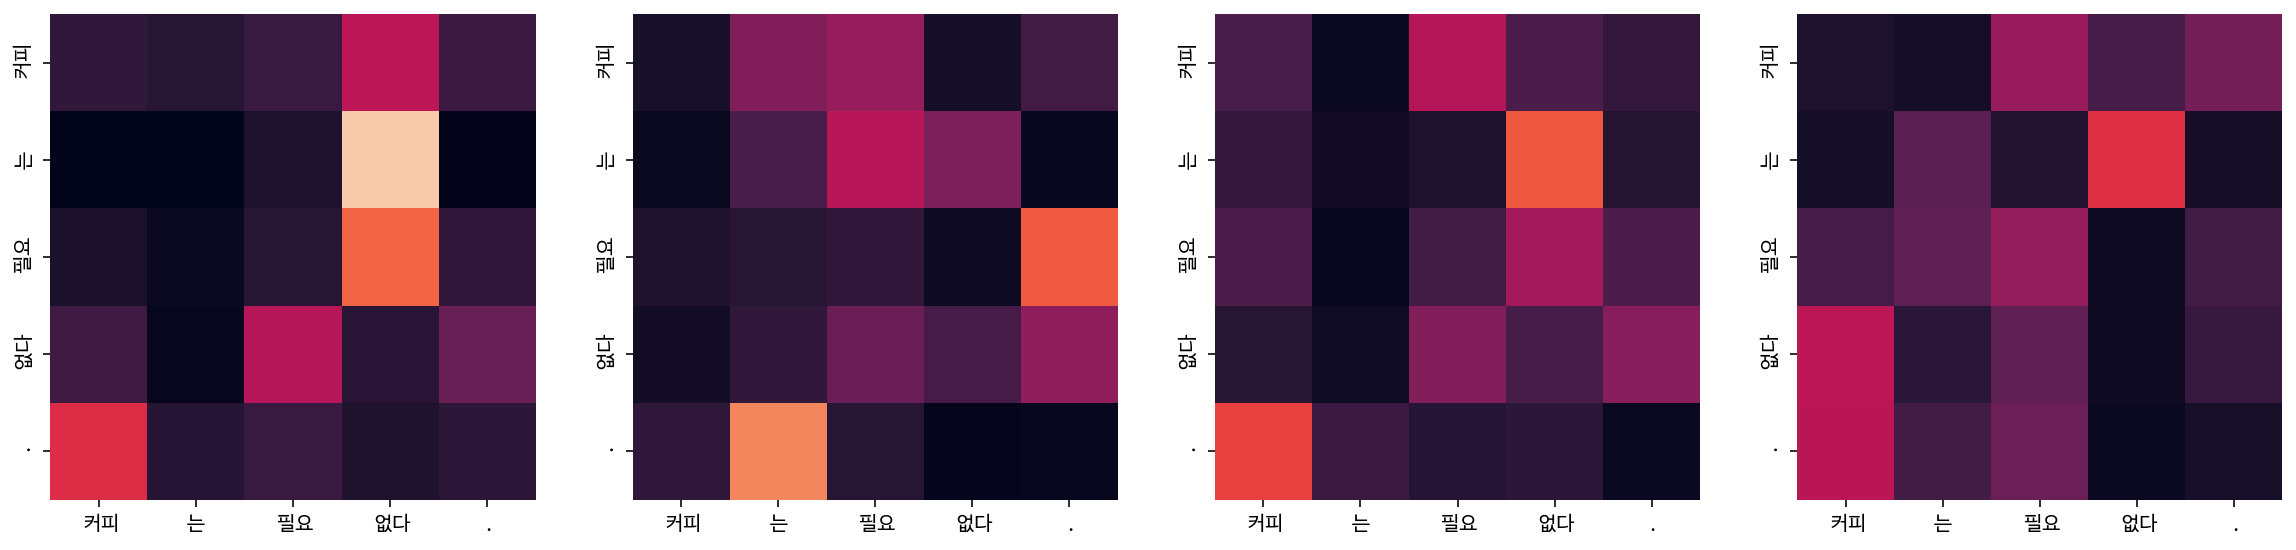

Decoder Self Layer 1


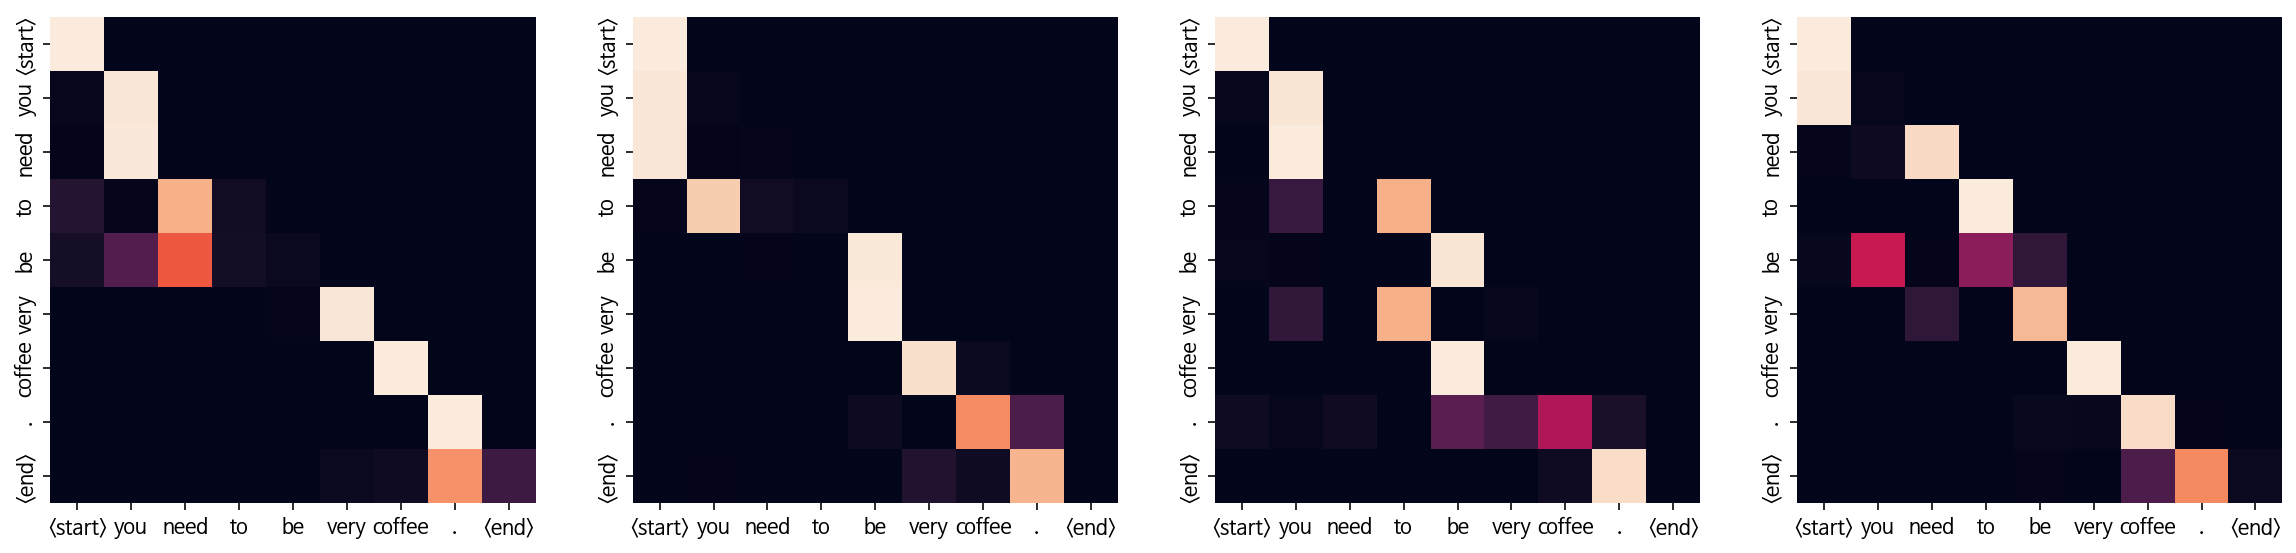

Decoder Src Layer 1


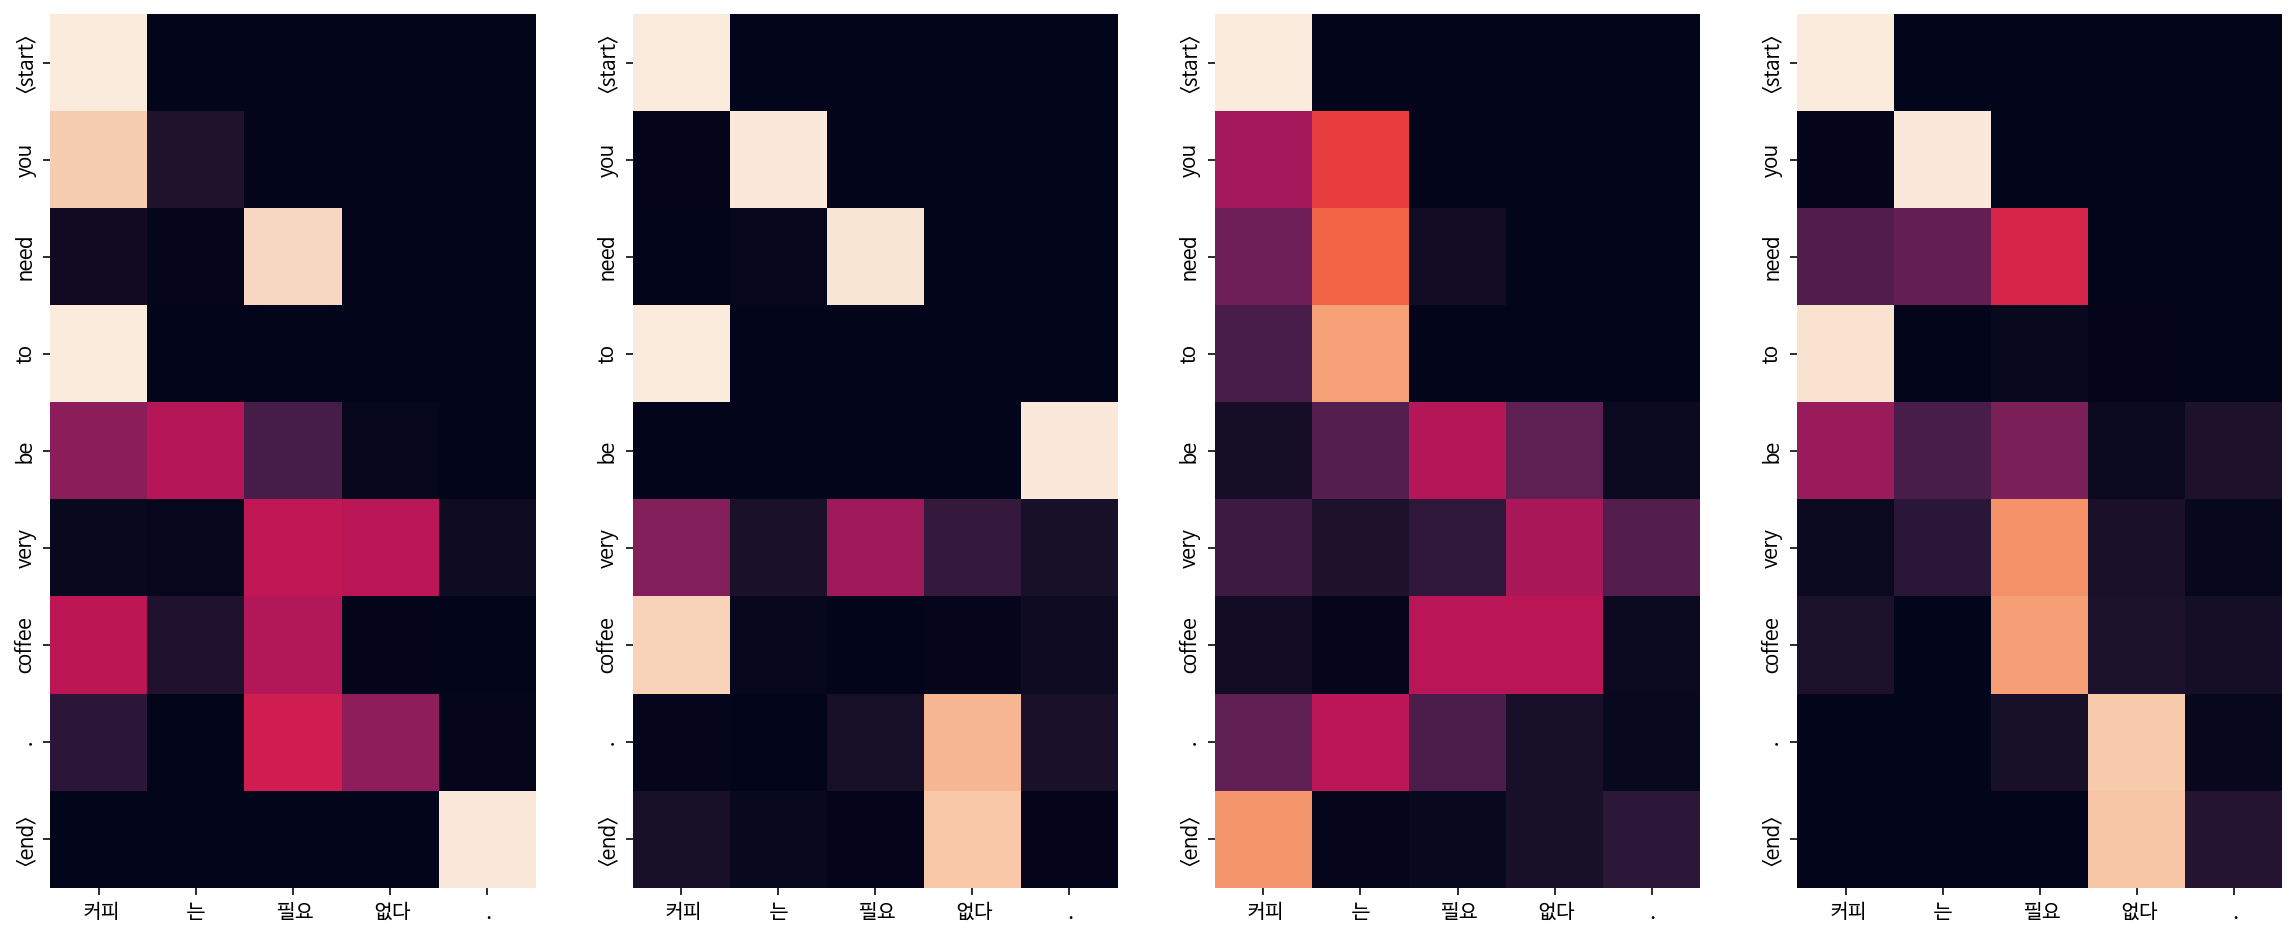

Decoder Self Layer 2


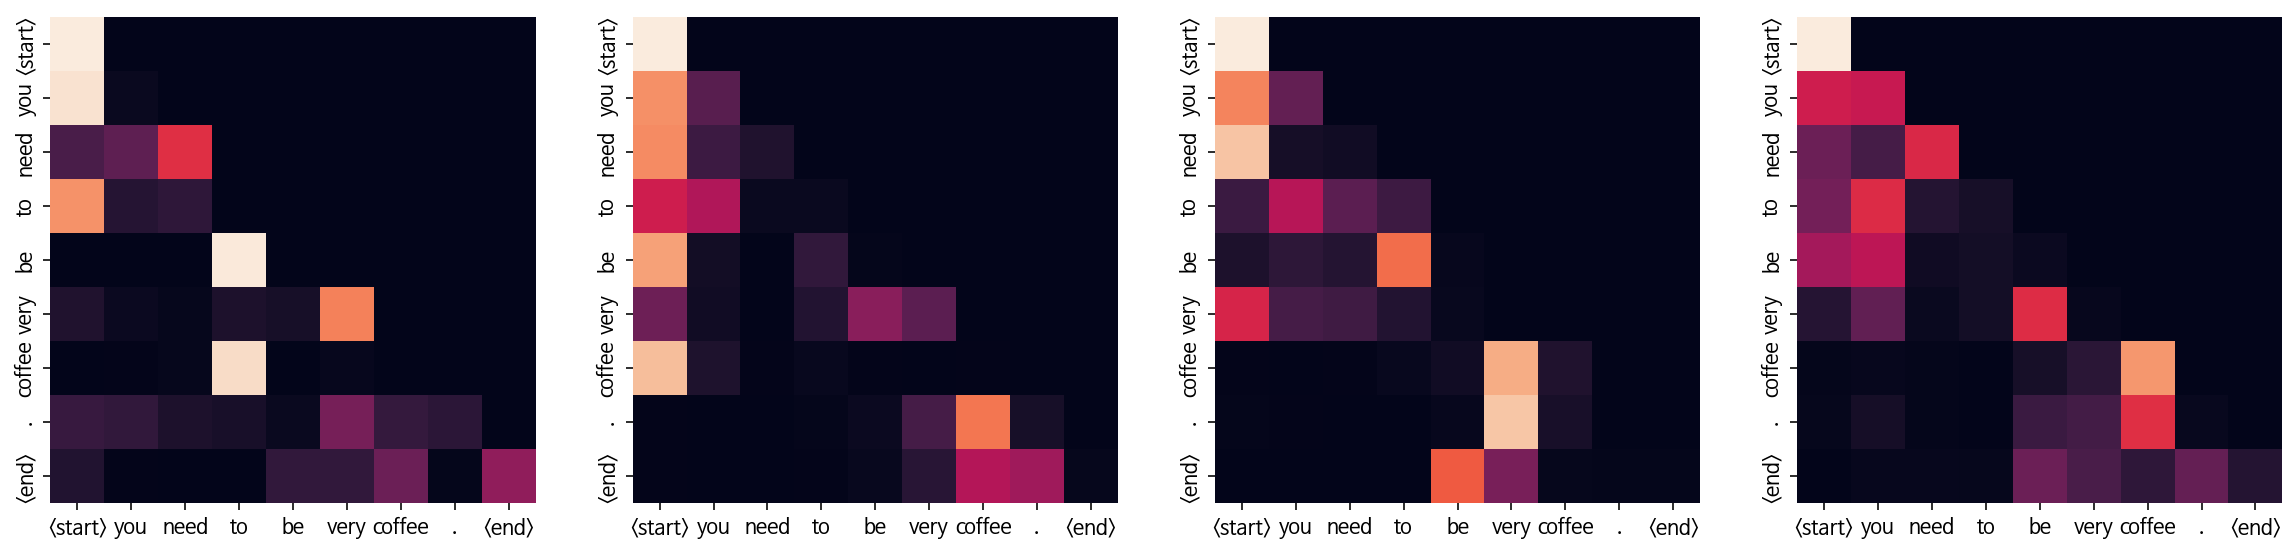

Decoder Src Layer 2


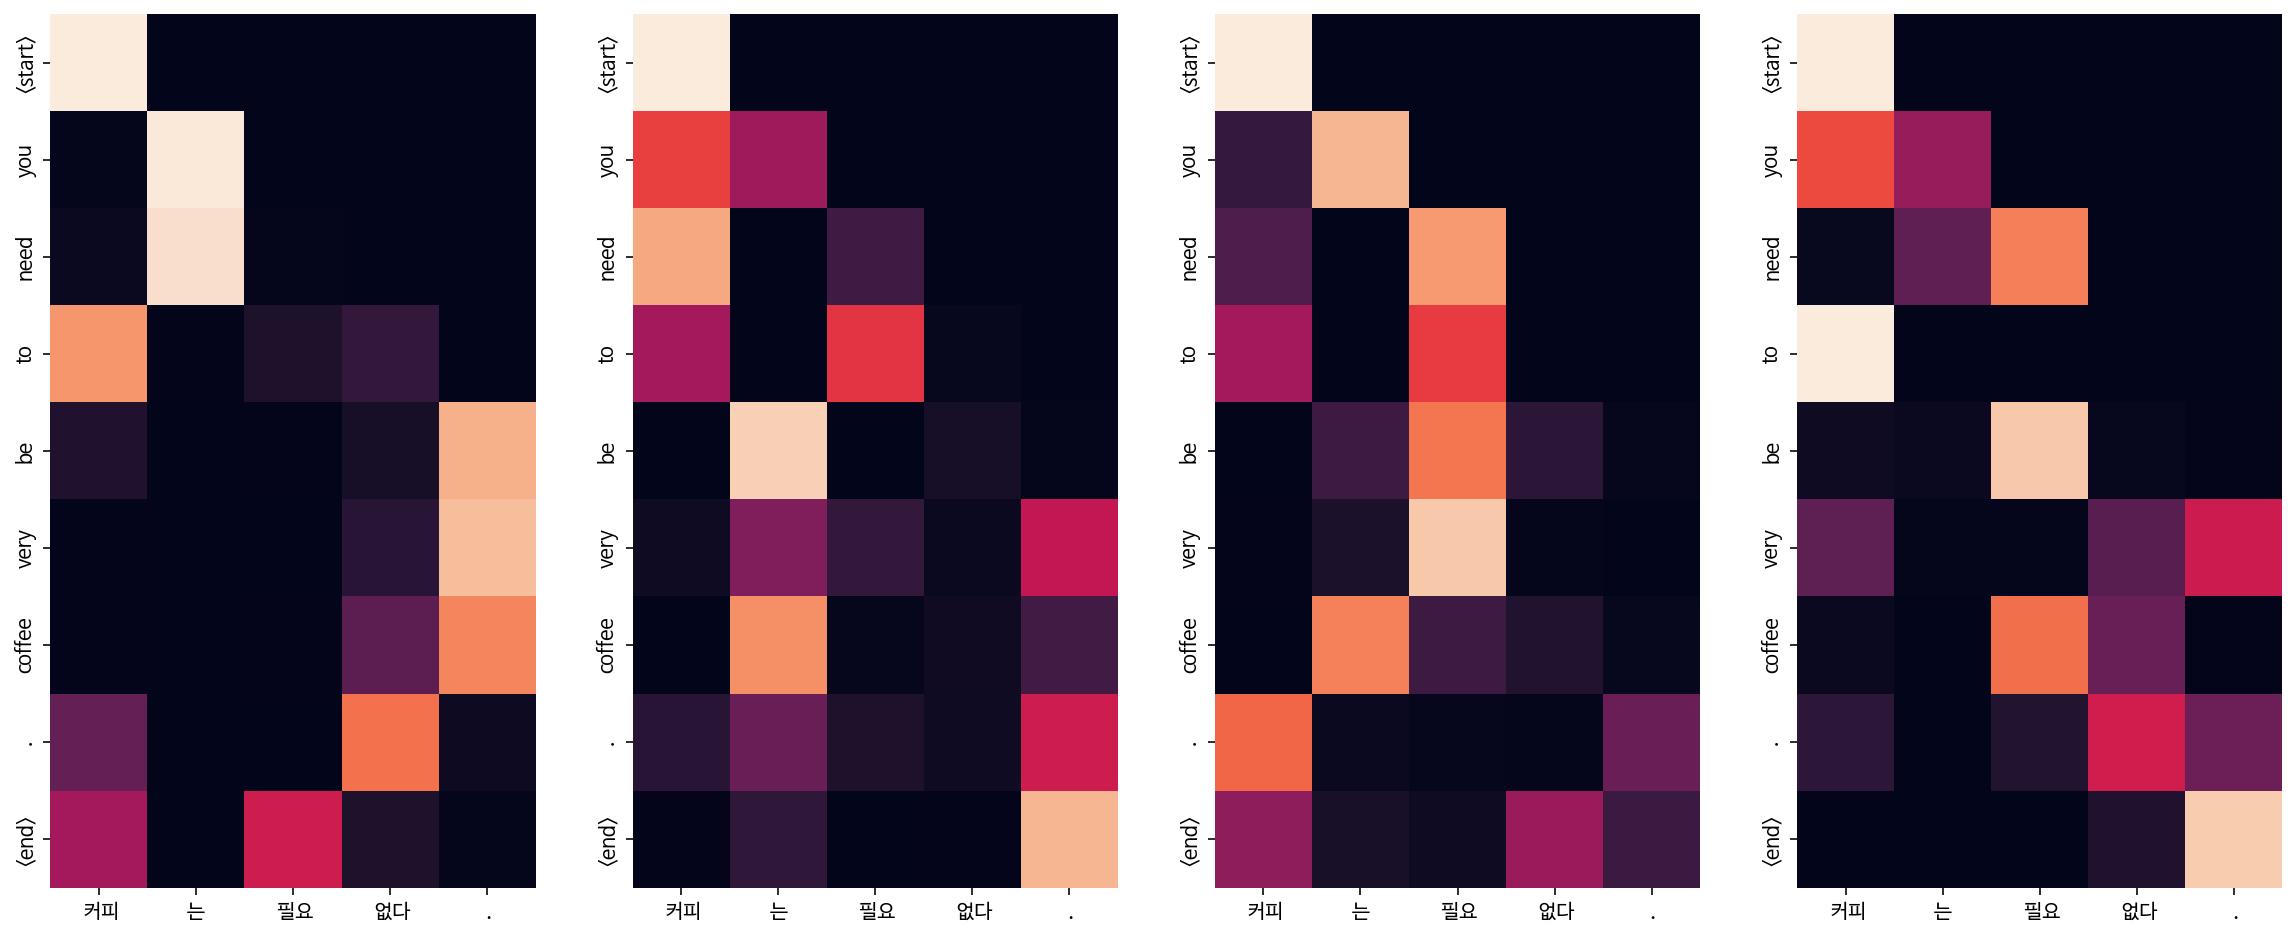

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <start> seven deaths were among the dead . <end>
Encoder Layer 1


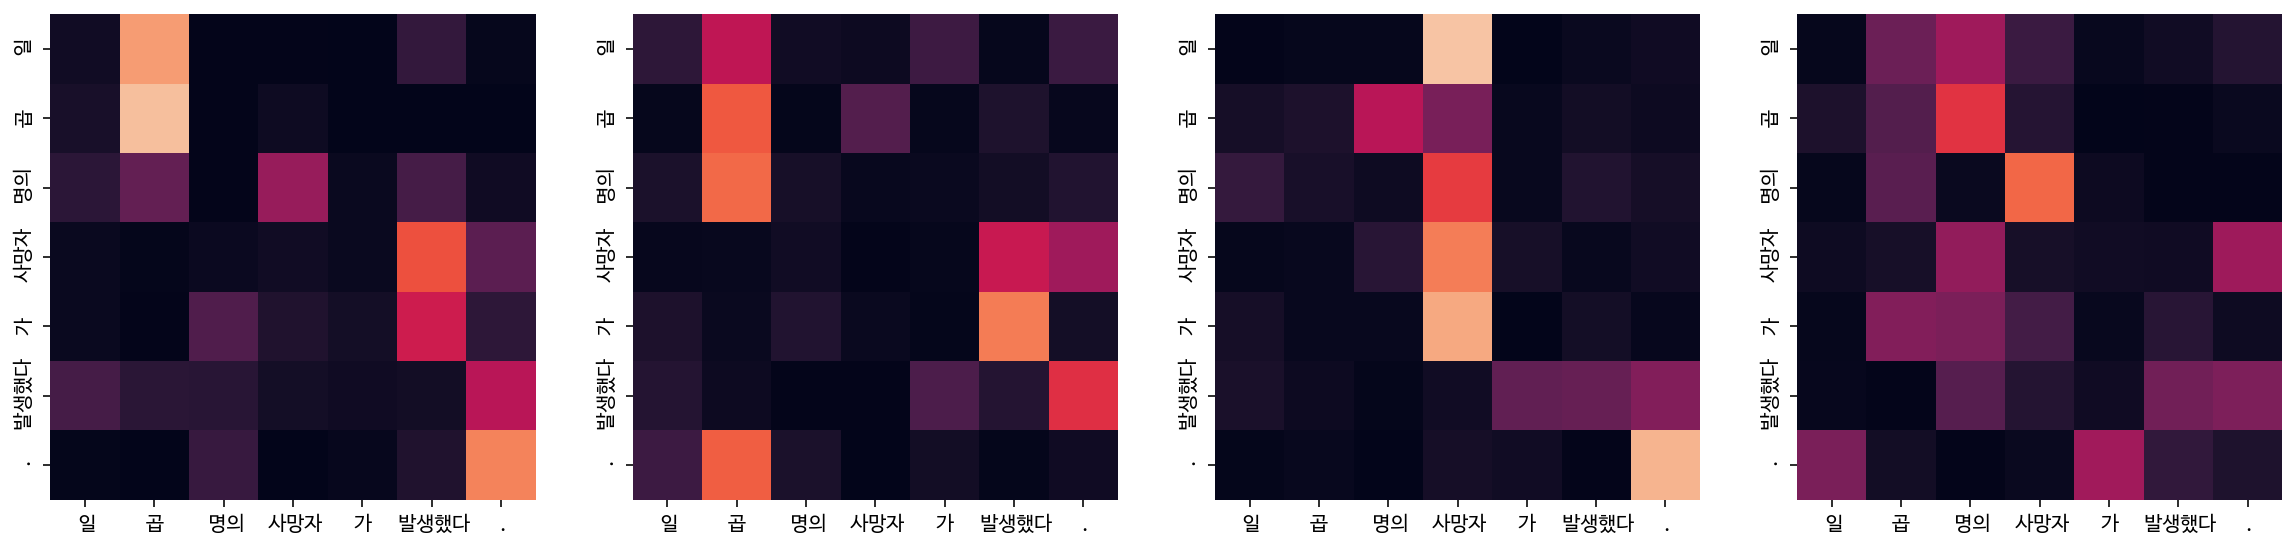

Encoder Layer 2


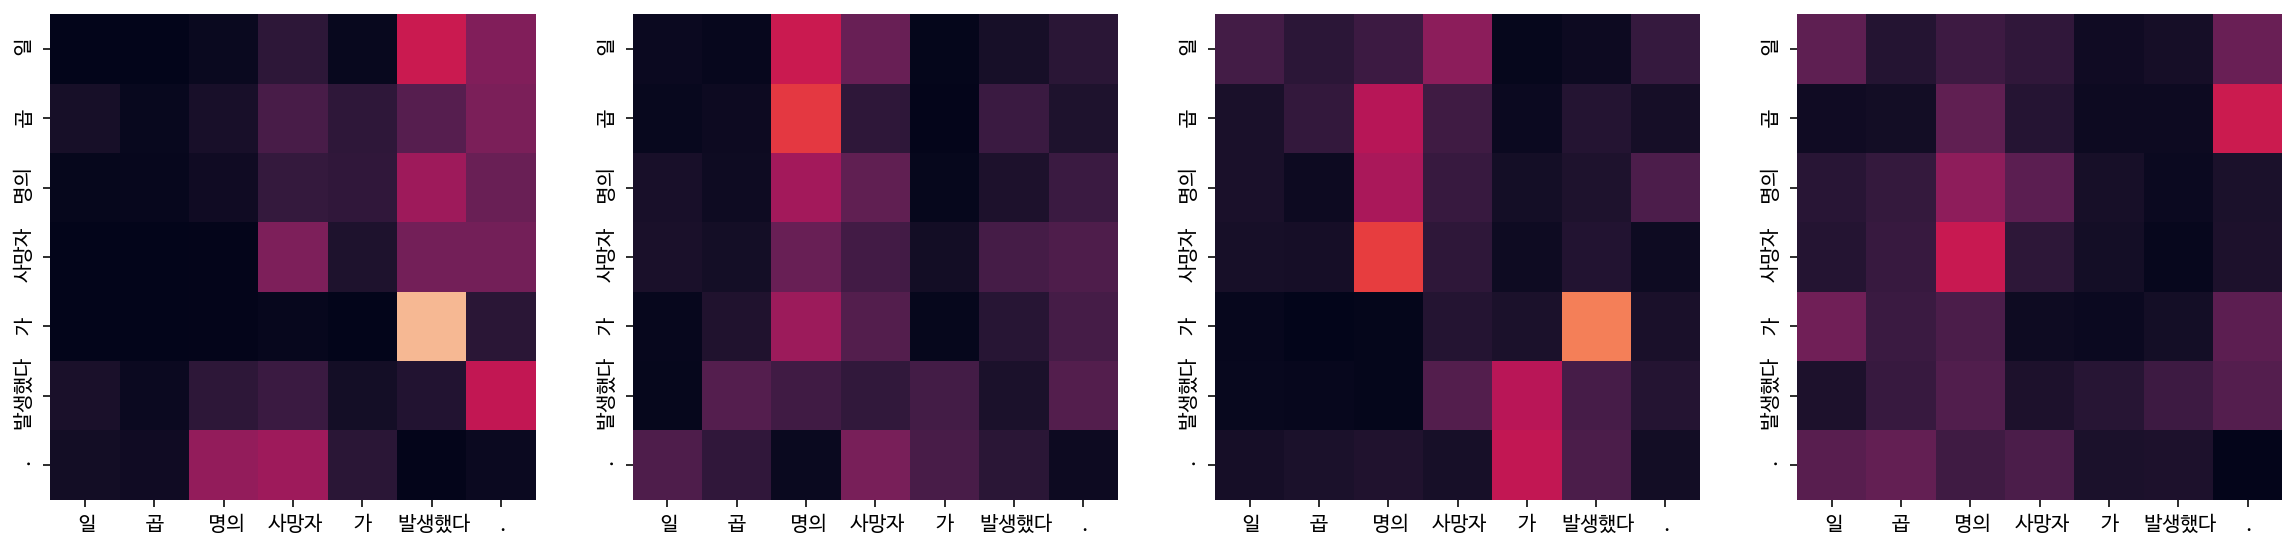

Decoder Self Layer 1


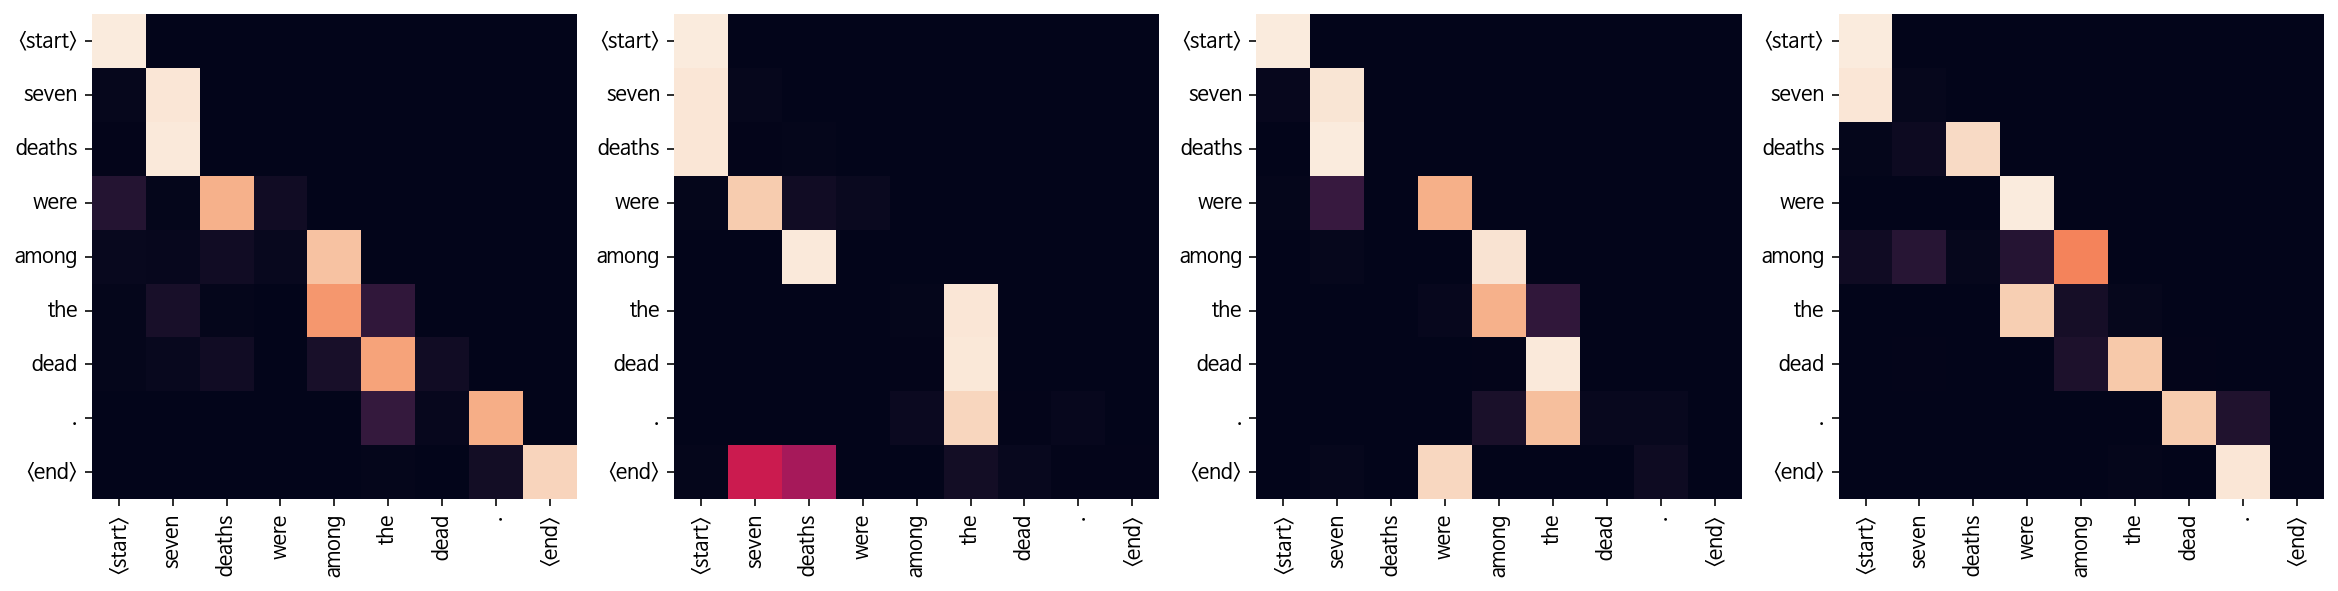

Decoder Src Layer 1


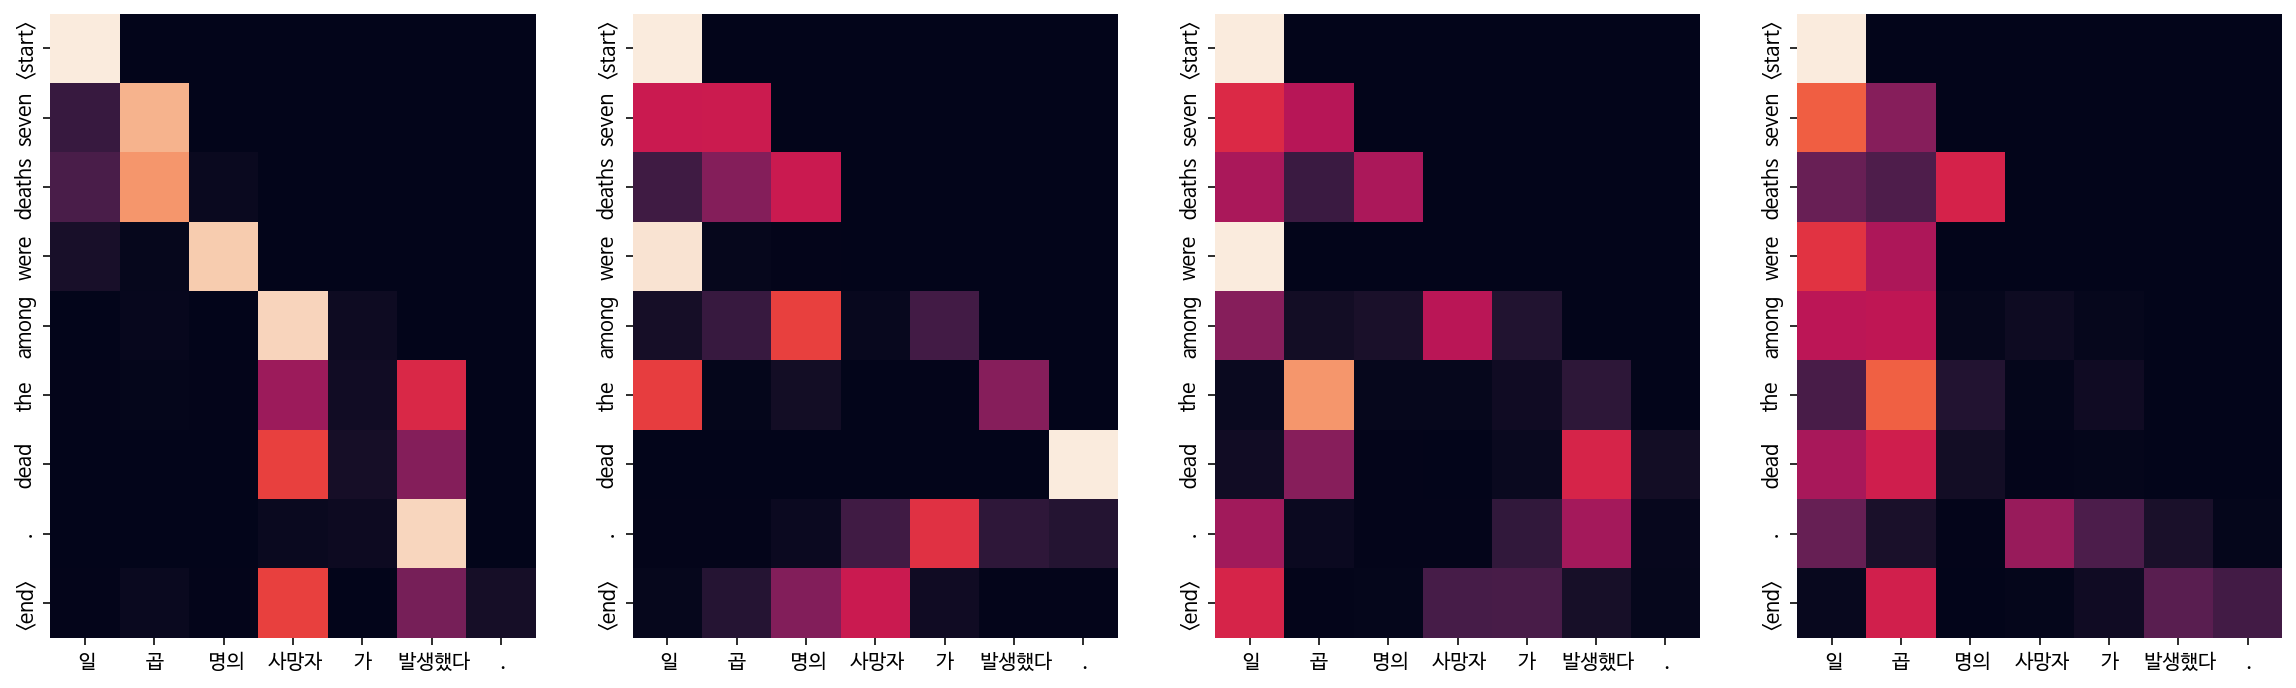

Decoder Self Layer 2


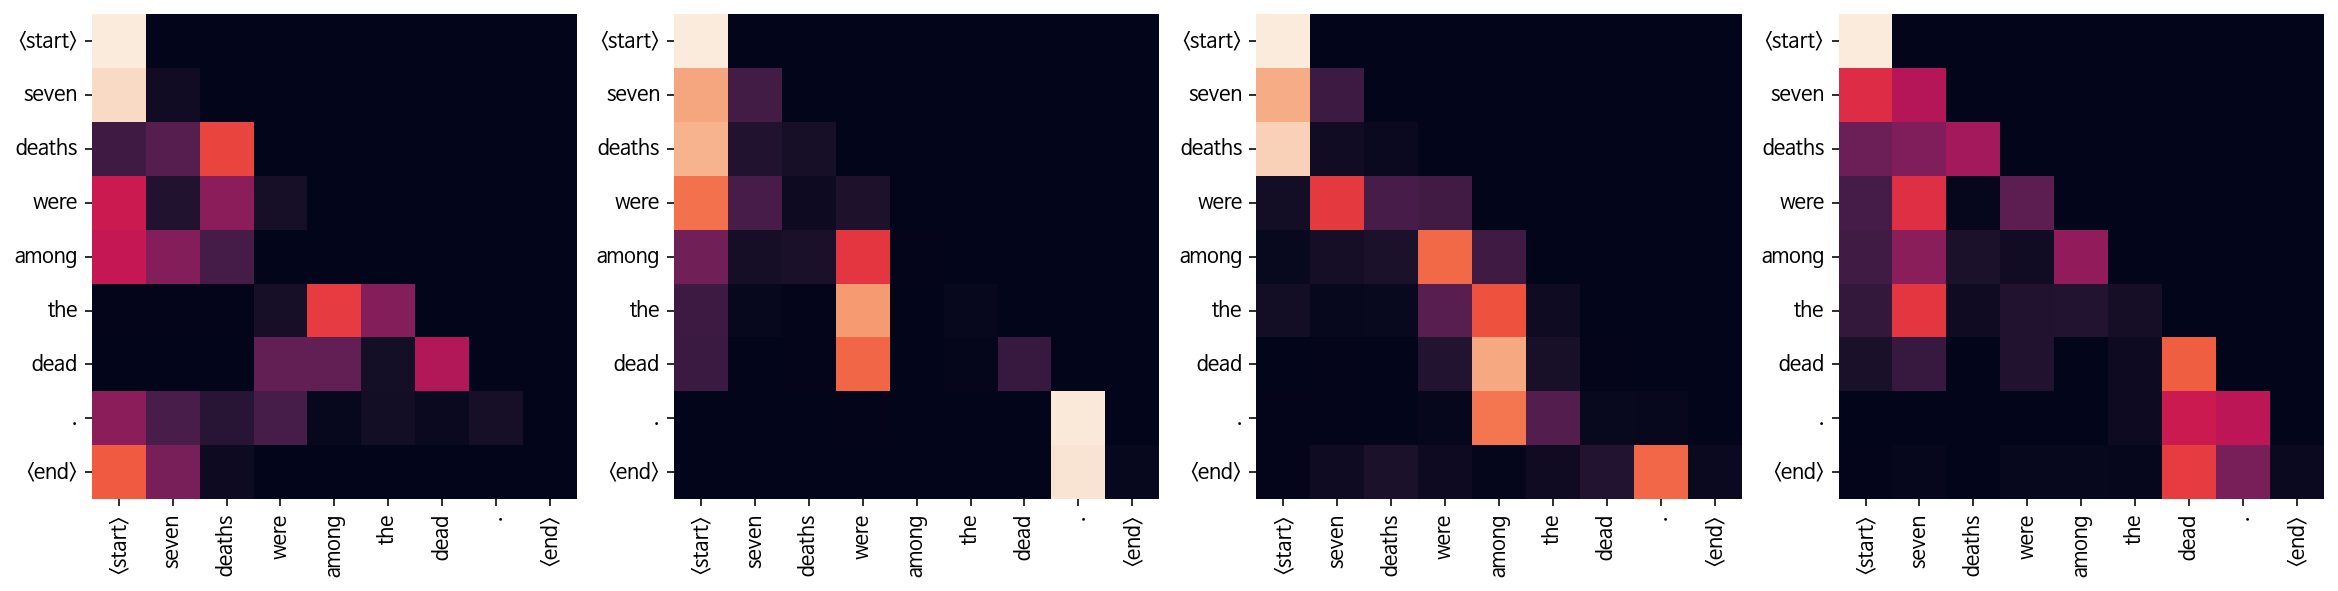

Decoder Src Layer 2


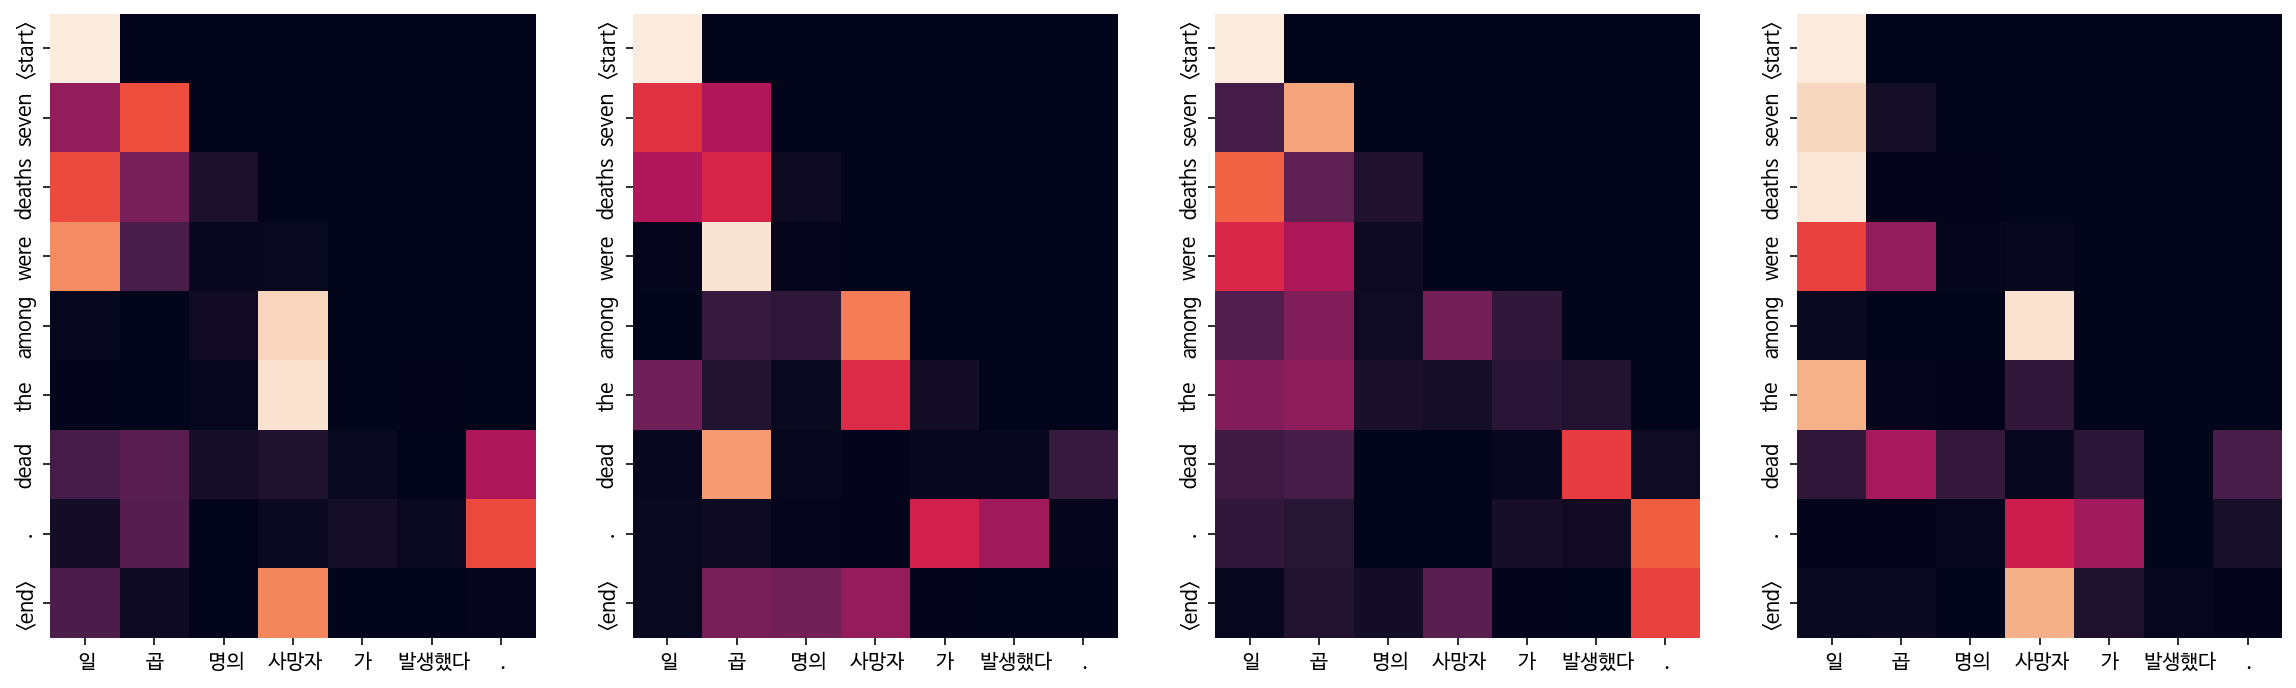

  0%|          | 0/3683 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [90]:
src_vocab_size = vocab_sizes
tgt_vocab_size = vocab_sizes

for epoch in epochs:
    for batch_size in batch_sizes:
        for vocab_size in vocab_sizes:
            src_vocab_size = vocab_size
            tgt_vocab_size = vocab_size

            train_evaluate(epoch, enc_train, dec_train, optimizer, ko_tokenizer, en_tokenizer, src_vocab_size, tgt_vocab_size)


### 모델 밖의 조력자들

In [ ]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()